In [1]:
# ============================================
# SETUP CELL - Run this first after pod restart
# ============================================

import os
import sys

# Add workspace packages to Python path
workspace_packages = '/workspace/python_packages'
if workspace_packages not in sys.path:
    sys.path.insert(0, workspace_packages)

# Redirect all caches to persistent workspace storage
os.environ['HF_HOME'] = '/workspace/.cache/huggingface'
os.environ['TRANSFORMERS_CACHE'] = '/workspace/.cache/huggingface/transformers'
os.environ['HF_DATASETS_CACHE'] = '/workspace/.cache/huggingface/datasets'
os.environ['TORCH_HOME'] = '/workspace/.cache/torch'
os.environ['PIP_CACHE_DIR'] = '/workspace/.cache/pip'
os.environ['TMPDIR'] = '/workspace/tmp'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/cuda/lib64:' + os.environ.get('LD_LIBRARY_PATH', '')

# Create directories if they don't exist
for path in ['/workspace/.cache/huggingface', '/workspace/.cache/torch', 
             '/workspace/.cache/pip', '/workspace/tmp']:
    os.makedirs(path, exist_ok=True)

print("✓ Environment configured - all paths point to /workspace")

# Import your libraries
from typing import Optional, Tuple, List, Dict, Any
import numpy as np
import torch
from transformers import AutoModel, AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
from ripser import ripser
from persim import plot_diagrams, bottleneck
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap
import json
import pickle
from pathlib import Path
from datetime import datetime
import hashlib
from scipy.stats import gaussian_kde, pearsonr, spearmanr
from scipy.spatial.distance import directed_hausdorff
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

print("✓ All libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

✓ Environment configured - all paths point to /workspace


/workspace/python_packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


✓ All libraries imported successfully
PyTorch version: 2.3.1+cu118
CUDA available: True


In [8]:
"""
H2 Exploration & Pattern Analysis
Advanced visualizations to understand relationships between H1, H2, and adversarial attacks
"""

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import warnings
warnings.filterwarnings('ignore')


# ==============================================================================
# DATA LOADING
# ==============================================================================

def load_h2_data(exp_dir: Path, condition: str = "sandbagging"):
    """
    Load H2 experimental data
    
    Args:
        exp_dir: Experiment directory
        condition: "sandbagging" or "non_sandbagging"
        
    Returns:
        Dictionary with persistence diagrams
    """
    h2_dir = exp_dir / condition / "h2_experimental"
    
    with open(h2_dir / "persistence_diagrams_h2.pkl", "rb") as f:
        res_list = pickle.load(f)
    
    # Load texts
    with open(exp_dir / condition / "texts.txt", "r", encoding="utf-8") as f:
        texts = [line.strip() for line in f.readlines()]
    
    return {
        "res_list": res_list,
        "texts": texts
    }


def extract_topological_features(res_list):
    """
    Extract all topological features from persistence diagrams
    
    Returns:
        DataFrame with features for each sample
    """
    features = []
    
    for idx, res in enumerate(res_list):
        sample_features = {"sample_idx": idx}
        
        for dim in range(len(res['dgms'])):
            dgm = res['dgms'][dim]
            finite_dgm = dgm[np.isfinite(dgm).all(axis=1)]
            
            if len(finite_dgm) > 0:
                lifespans = finite_dgm[:, 1] - finite_dgm[:, 0]
                births = finite_dgm[:, 0]
                deaths = finite_dgm[:, 1]
                
                sample_features.update({
                    f'H{dim}_n_features': len(finite_dgm),
                    f'H{dim}_mean_lifespan': np.mean(lifespans),
                    f'H{dim}_max_lifespan': np.max(lifespans),
                    f'H{dim}_std_lifespan': np.std(lifespans),
                    f'H{dim}_total_persistence': np.sum(lifespans),
                    f'H{dim}_mean_birth': np.mean(births),
                    f'H{dim}_mean_death': np.mean(deaths),
                    f'H{dim}_birth_std': np.std(births),
                    f'H{dim}_death_std': np.std(deaths)
                })
            else:
                sample_features.update({
                    f'H{dim}_n_features': 0,
                    f'H{dim}_mean_lifespan': 0,
                    f'H{dim}_max_lifespan': 0,
                    f'H{dim}_std_lifespan': 0,
                    f'H{dim}_total_persistence': 0,
                    f'H{dim}_mean_birth': 0,
                    f'H{dim}_mean_death': 0,
                    f'H{dim}_birth_std': 0,
                    f'H{dim}_death_std': 0
                })
        
        features.append(sample_features)
    
    return pd.DataFrame(features)


# ==============================================================================
# VIZ 1: H1 vs H2 FEATURE CORRELATION
# ==============================================================================

def plot_h1_h2_correlation(sb_data, nsb_data, figsize=(14, 6)):
    """
    Plot H1 vs H2 features to observe correlations
    Shows if adversarial attacks affect H1 and H2 differently
    """
    # Extract features
    df_sb = extract_topological_features(sb_data['res_list'])
    df_nsb = extract_topological_features(nsb_data['res_list'])
    
    df_sb['condition'] = 'Sandbagging'
    df_nsb['condition'] = 'Non-Sandbagging'
    
    df = pd.concat([df_sb, df_nsb], ignore_index=True)
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Number of features
    ax = axes[0]
    for condition, color, marker in [('Sandbagging', 'blue', 'o'), 
                                      ('Non-Sandbagging', 'orange', '^')]:
        data = df[df['condition'] == condition]
        ax.scatter(data['H1_n_features'], data['H2_n_features'],
                  label=condition, alpha=0.6, s=80, c=color, marker=marker,
                  edgecolors='black', linewidths=0.5)
    
    ax.set_xlabel('H1 Number of Features', fontsize=12)
    ax.set_ylabel('H2 Number of Features', fontsize=12)
    ax.set_title('H1 vs H2 Feature Count', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Compute correlations
    corr_sb = pearsonr(df_sb['H1_n_features'], df_sb['H2_n_features'])
    corr_nsb = pearsonr(df_nsb['H1_n_features'], df_nsb['H2_n_features'])
    
    ax.text(0.05, 0.95, f'Sandbagging: r={corr_sb[0]:.3f}, p={corr_sb[1]:.3f}\n'
                        f'Non-Sandbagging: r={corr_nsb[0]:.3f}, p={corr_nsb[1]:.3f}',
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # Plot 2: Mean lifespans
    ax = axes[1]
    for condition, color, marker in [('Sandbagging', 'blue', 'o'), 
                                      ('Non-Sandbagging', 'orange', '^')]:
        data = df[df['condition'] == condition]
        # Filter out zeros for better visualization
        data_filtered = data[(data['H1_mean_lifespan'] > 0) & (data['H2_mean_lifespan'] > 0)]
        ax.scatter(data_filtered['H1_mean_lifespan'], data_filtered['H2_mean_lifespan'],
                  label=condition, alpha=0.6, s=80, c=color, marker=marker,
                  edgecolors='black', linewidths=0.5)
    
    ax.set_xlabel('H1 Mean Lifespan', fontsize=12)
    ax.set_ylabel('H2 Mean Lifespan', fontsize=12)
    ax.set_title('H1 vs H2 Persistence', fontsize=13, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle('H1 vs H2 Correlation Analysis', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    return df


# ==============================================================================
# VIZ 2: TOPOLOGICAL FEATURE SPACE (PCA/t-SNE)
# ==============================================================================

def plot_topological_feature_space(sb_data, nsb_data, method='pca', figsize=(14, 6)):
    """
    Project topological features into 2D space using PCA or t-SNE
    Shows if sandbagging and non-sandbagging cluster differently
    
    Args:
        method: 'pca' or 'tsne'
    """
    # Extract features
    df_sb = extract_topological_features(sb_data['res_list'])
    df_nsb = extract_topological_features(nsb_data['res_list'])
    
    # Select feature columns
    feature_cols = [col for col in df_sb.columns if col != 'sample_idx']
    
    # Combine data
    X_sb = df_sb[feature_cols].values
    X_nsb = df_nsb[feature_cols].values
    X = np.vstack([X_sb, X_nsb])
    
    # Labels
    labels = np.array(['Sandbagging'] * len(X_sb) + ['Non-Sandbagging'] * len(X_nsb))
    
    # Dimensionality reduction
    if method == 'pca':
        reducer = PCA(n_components=2)
        X_reduced = reducer.fit_transform(X)
        explained_var = reducer.explained_variance_ratio_
        title_suffix = f'(Explained Var: {explained_var[0]:.1%}, {explained_var[1]:.1%})'
    else:
        reducer = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)-1))
        X_reduced = reducer.fit_transform(X)
        title_suffix = ''
    
    # Plot
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Plot 1: Colored by condition
    ax = axes[0]
    for condition, color, marker in [('Sandbagging', 'blue', 'o'), 
                                      ('Non-Sandbagging', 'orange', '^')]:
        mask = labels == condition
        ax.scatter(X_reduced[mask, 0], X_reduced[mask, 1],
                  label=condition, alpha=0.6, s=80, c=color, marker=marker,
                  edgecolors='black', linewidths=0.5)
    
    ax.set_xlabel(f'{method.upper()} Component 1', fontsize=12)
    ax.set_ylabel(f'{method.upper()} Component 2', fontsize=12)
    ax.set_title(f'Topological Feature Space {title_suffix}', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Colored by H2 feature count
    ax = axes[1]
    h2_counts = np.concatenate([df_sb['H2_n_features'].values, 
                                df_nsb['H2_n_features'].values])
    scatter = ax.scatter(X_reduced[:, 0], X_reduced[:, 1],
                        c=h2_counts, cmap='viridis', s=80, alpha=0.6,
                        edgecolors='black', linewidths=0.5)
    plt.colorbar(scatter, ax=ax, label='H2 Feature Count')
    
    ax.set_xlabel(f'{method.upper()} Component 1', fontsize=12)
    ax.set_ylabel(f'{method.upper()} Component 2', fontsize=12)
    ax.set_title('Colored by H2 Features', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'{method.upper()} of Topological Features', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print feature importance for PCA
    if method == 'pca':
        print("\n📊 Top Contributing Features:")
        components = np.abs(reducer.components_)
        for i in range(2):
            print(f"\nComponent {i+1}:")
            top_indices = np.argsort(components[i])[-5:][::-1]
            for idx in top_indices:
                print(f"  {feature_cols[idx]}: {components[i, idx]:.3f}")


# ==============================================================================
# VIZ 3: HEATMAP OF TOPOLOGICAL SIGNATURES
# ==============================================================================

def plot_topological_signature_heatmap(sb_data, nsb_data, n_samples=None, figsize=(16, 8)):
    """
    Heatmap showing all topological features across samples
    Rows = samples, Columns = features, Color = value
    """
    # Extract features
    df_sb = extract_topological_features(sb_data['res_list'])
    df_nsb = extract_topological_features(nsb_data['res_list'])
    
    if n_samples:
        df_sb = df_sb.head(n_samples)
        df_nsb = df_nsb.head(n_samples)
    
    # Select feature columns (exclude sample_idx)
    feature_cols = [col for col in df_sb.columns if col != 'sample_idx']
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Sandbagging heatmap
    data_sb = df_sb[feature_cols].T
    sns.heatmap(data_sb, ax=axes[0], cmap='YlOrRd', cbar_kws={'label': 'Value'},
                xticklabels=[f'S{i}' for i in range(len(df_sb))],
                yticklabels=feature_cols, linewidths=0.5)
    axes[0].set_title('Sandbagging Topological Signatures', fontsize=12, fontweight='bold')
    axes[0].set_xlabel('Sample Index')
    axes[0].set_ylabel('Feature')
    
    # Non-sandbagging heatmap
    data_nsb = df_nsb[feature_cols].T
    sns.heatmap(data_nsb, ax=axes[1], cmap='YlGnBu', cbar_kws={'label': 'Value'},
                xticklabels=[f'S{i}' for i in range(len(df_nsb))],
                yticklabels=feature_cols, linewidths=0.5)
    axes[1].set_title('Non-Sandbagging Topological Signatures', fontsize=12, fontweight='bold')
    axes[1].set_xlabel('Sample Index')
    axes[1].set_ylabel('Feature')
    
    plt.suptitle('Topological Feature Heatmaps Across Samples', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# ==============================================================================
# VIZ 4: DIFFERENCE ANALYSIS
# ==============================================================================

def plot_topological_difference_analysis(sb_data, nsb_data, figsize=(16, 10), 
                                        paired=True):
    """
    Analyze differences between sandbagging and non-sandbagging
    Shows which features change most under adversarial attacks
    
    Args:
        sb_data: Sandbagging data
        nsb_data: Non-sandbagging data
        figsize: Figure size
        paired: If True, uses paired comparison (requires same sample size).
                If False, uses unpaired comparison (independent samples)
    """
    # Extract features
    df_sb = extract_topological_features(sb_data['res_list'])
    df_nsb = extract_topological_features(nsb_data['res_list'])
    
    feature_cols = [col for col in df_sb.columns if col != 'sample_idx']
    
    # Handle different sample sizes
    n_sb = len(df_sb)
    n_nsb = len(df_nsb)
    
    print(f"📊 Sample sizes: Sandbagging={n_sb}, Non-Sandbagging={n_nsb}")
    
    # Determine if we can do paired analysis
    if paired and n_sb != n_nsb:
        n_samples = min(n_sb, n_nsb)
        print(f"   ⚠ Different sample sizes - using {n_samples} paired samples")
        df_sb_paired = df_sb.head(n_samples)
        df_nsb_paired = df_nsb.head(n_samples)
    elif paired:
        n_samples = n_sb
        df_sb_paired = df_sb
        df_nsb_paired = df_nsb
        print(f"   ✓ Using {n_samples} paired samples")
    else:
        print(f"   Using unpaired comparison (independent samples)")
    
    # Compute differences and effect sizes
    differences = {}
    effect_sizes = {}
    
    for col in feature_cols:
        # Paired differences (for plotting)
        if paired:
            diff = df_sb_paired[col].values - df_nsb_paired[col].values
            differences[col] = diff
        
        # Cohen's d effect size (always uses all samples)
        pooled_std = np.sqrt((df_sb[col].std()**2 + df_nsb[col].std()**2) / 2)
        if pooled_std > 0:
            effect_sizes[col] = (df_sb[col].mean() - df_nsb[col].mean()) / pooled_std
        else:
            effect_sizes[col] = 0
    
    fig = plt.figure(figsize=figsize)
    gs = fig.add_gridspec(3, 2, hspace=0.3, wspace=0.3)
    
    # Plot 1: Effect sizes
    ax1 = fig.add_subplot(gs[0, :])
    effect_df = pd.DataFrame({'feature': list(effect_sizes.keys()), 
                             'effect_size': list(effect_sizes.values())})
    effect_df = effect_df.sort_values('effect_size', key=abs, ascending=False).head(15)
    
    colors = ['red' if x < 0 else 'green' for x in effect_df['effect_size']]
    ax1.barh(effect_df['feature'], effect_df['effect_size'], color=colors, alpha=0.7)
    ax1.set_xlabel('Effect Size (Cohen\'s d)', fontsize=11)
    ax1.set_title('Top 15 Features by Effect Size (Sandbagging - Non-Sandbagging)', 
                 fontsize=12, fontweight='bold')
    ax1.axvline(0, color='black', linestyle='--', linewidth=1)
    ax1.grid(True, alpha=0.3, axis='x')
    
    # Plot 2: Distribution of differences (H1)
    ax2 = fig.add_subplot(gs[1, 0])
    if paired:
        h1_diff = differences['H1_mean_lifespan']
        ax2.hist(h1_diff, bins=20, color='steelblue', edgecolor='black', alpha=0.7)
        ax2.axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
        ax2.axvline(np.mean(h1_diff), color='orange', linestyle='-', linewidth=2, 
                   label=f'Mean: {np.mean(h1_diff):.4f}')
        ax2.set_xlabel('Difference in H1 Mean Lifespan', fontsize=10)
        ax2.set_ylabel('Frequency', fontsize=10)
        ax2.set_title('H1 Lifespan Change Distribution', fontsize=11, fontweight='bold')
        ax2.legend()
    else:
        # Unpaired: show distributions separately
        ax2.hist(df_sb['H1_mean_lifespan'], bins=20, alpha=0.6, 
                label='Sandbagging', color='blue', density=True)
        ax2.hist(df_nsb['H1_mean_lifespan'], bins=20, alpha=0.6,
                label='Non-Sandbagging', color='orange', density=True)
        ax2.set_xlabel('H1 Mean Lifespan', fontsize=10)
        ax2.set_ylabel('Density', fontsize=10)
        ax2.set_title('H1 Lifespan Distributions', fontsize=11, fontweight='bold')
        ax2.legend()
    ax2.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: Distribution of differences (H2)
    ax3 = fig.add_subplot(gs[1, 1])
    if paired:
        h2_diff = differences['H2_mean_lifespan']
        ax3.hist(h2_diff, bins=20, color='coral', edgecolor='black', alpha=0.7)
        ax3.axvline(0, color='red', linestyle='--', linewidth=2, label='No change')
        ax3.axvline(np.mean(h2_diff), color='orange', linestyle='-', linewidth=2,
                   label=f'Mean: {np.mean(h2_diff):.4f}')
        ax3.set_xlabel('Difference in H2 Mean Lifespan', fontsize=10)
        ax3.set_ylabel('Frequency', fontsize=10)
        ax3.set_title('H2 Lifespan Change Distribution', fontsize=11, fontweight='bold')
        ax3.legend()
    else:
        # Unpaired: show distributions separately
        ax3.hist(df_sb['H2_mean_lifespan'], bins=20, alpha=0.6,
                label='Sandbagging', color='blue', density=True)
        ax3.hist(df_nsb['H2_mean_lifespan'], bins=20, alpha=0.6,
                label='Non-Sandbagging', color='orange', density=True)
        ax3.set_xlabel('H2 Mean Lifespan', fontsize=10)
        ax3.set_ylabel('Density', fontsize=10)
        ax3.set_title('H2 Lifespan Distributions', fontsize=11, fontweight='bold')
        ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Sample-wise difference profile (only for paired)
    ax4 = fig.add_subplot(gs[2, :])
    if paired:
        sample_indices = np.arange(n_samples)
        ax4.plot(sample_indices, differences['H1_n_features'], 
                marker='o', label='H1 Feature Count Δ', linewidth=2, markersize=4)
        ax4.plot(sample_indices, differences['H2_n_features'], 
                marker='^', label='H2 Feature Count Δ', linewidth=2, markersize=4)
        ax4.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
        ax4.set_xlabel('Sample Index', fontsize=11)
        ax4.set_ylabel('Difference (SB - NSB)', fontsize=11)
        ax4.set_title(f'Feature Count Differences Across {n_samples} Paired Samples', 
                     fontsize=12, fontweight='bold')
    else:
        # Unpaired: show separate time series
        ax4.plot(df_sb['H1_n_features'].values, marker='o', 
                label='Sandbagging H1', linewidth=2, markersize=4)
        ax4.plot(df_nsb['H1_n_features'].values, marker='^',
                label='Non-Sandbagging H1', linewidth=2, markersize=4)
        ax4.set_xlabel('Sample Index', fontsize=11)
        ax4.set_ylabel('H1 Feature Count', fontsize=11)
        ax4.set_title('H1 Feature Count Across Samples', fontsize=12, fontweight='bold')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    plt.suptitle('Topological Difference Analysis: Sandbagging vs Non-Sandbagging',
                fontsize=14, fontweight='bold', y=0.995)
    plt.show()
    
    # Print summary statistics
    print("\n📊 Summary Statistics:")
    print("\nTop 5 Features by Absolute Effect Size:")
    for _, row in effect_df.head(5).iterrows():
        print(f"  {row['feature']}: {row['effect_size']:.3f}")
    
    if paired:
        print("\nMean Differences (Paired):")
        print(f"  H1 Mean Lifespan: {np.mean(h1_diff):.6f}")
        print(f"  H2 Mean Lifespan: {np.mean(h2_diff):.6f}")
        print(f"  H1 Feature Count: {np.mean(differences['H1_n_features']):.2f}")
        print(f"  H2 Feature Count: {np.mean(differences['H2_n_features']):.2f}")
        print(f"\nNote: Analysis used {n_samples} paired samples")
        print(f"  (Sandbagging has {n_sb} total, Non-Sandbagging has {n_nsb} total)")
    else:
        print("\nMean Values (Unpaired):")
        print(f"  Sandbagging H1 Mean Lifespan: {df_sb['H1_mean_lifespan'].mean():.6f}")
        print(f"  Non-Sandbagging H1 Mean Lifespan: {df_nsb['H1_mean_lifespan'].mean():.6f}")
        print(f"  Sandbagging H2 Mean Lifespan: {df_sb['H2_mean_lifespan'].mean():.6f}")
        print(f"  Non-Sandbagging H2 Mean Lifespan: {df_nsb['H2_mean_lifespan'].mean():.6f}")


# ==============================================================================
# VIZ 5: PERSISTENCE LANDSCAPE COMPARISON
# ==============================================================================

def plot_persistence_landscapes(sb_data, nsb_data, dim=1, figsize=(14, 5)):
    """
    Plot aggregated persistence landscapes
    Shows overall distribution of topological features
    """
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Collect all births and deaths
    births_sb, deaths_sb = [], []
    births_nsb, deaths_nsb = [], []
    
    for res in sb_data['res_list']:
        dgm = res['dgms'][dim]
        finite_dgm = dgm[np.isfinite(dgm).all(axis=1)]
        if len(finite_dgm) > 0:
            births_sb.extend(finite_dgm[:, 0])
            deaths_sb.extend(finite_dgm[:, 1])
    
    for res in nsb_data['res_list']:
        dgm = res['dgms'][dim]
        finite_dgm = dgm[np.isfinite(dgm).all(axis=1)]
        if len(finite_dgm) > 0:
            births_nsb.extend(finite_dgm[:, 0])
            deaths_nsb.extend(finite_dgm[:, 1])
    
    # Plot 1: Birth distribution
    ax = axes[0]
    ax.hist(births_sb, bins=30, alpha=0.6, label='Sandbagging', color='blue', density=True)
    ax.hist(births_nsb, bins=30, alpha=0.6, label='Non-Sandbagging', color='orange', density=True)
    ax.set_xlabel('Birth Time', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'H{dim} Birth Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Death distribution
    ax = axes[1]
    ax.hist(deaths_sb, bins=30, alpha=0.6, label='Sandbagging', color='blue', density=True)
    ax.hist(deaths_nsb, bins=30, alpha=0.6, label='Non-Sandbagging', color='orange', density=True)
    ax.set_xlabel('Death Time', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'H{dim} Death Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Lifespan distribution
    ax = axes[2]
    lifespans_sb = np.array(deaths_sb) - np.array(births_sb)
    lifespans_nsb = np.array(deaths_nsb) - np.array(births_nsb)
    ax.hist(lifespans_sb, bins=30, alpha=0.6, label='Sandbagging', color='blue', density=True)
    ax.hist(lifespans_nsb, bins=30, alpha=0.6, label='Non-Sandbagging', color='orange', density=True)
    ax.set_xlabel('Lifespan (Persistence)', fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'H{dim} Lifespan Distribution', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'H{dim} Persistence Landscapes Across All Samples', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# ==============================================================================
# VIZ 6: MULTI-MODEL COMPARISON (if you have multiple experiments)
# ==============================================================================

def compare_models_h1_h2(exp_dirs: dict, figsize=(14, 10)):
    """
    Compare H1 vs H2 relationships across different models
    
    Args:
        exp_dirs: Dict like {"BERT": Path(...), "RoBERTa": Path(...)}
    """
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    all_results = {}
    
    for model_name, exp_dir in exp_dirs.items():
        # Load data
        sb_data = load_h2_data(exp_dir, "sandbagging")
        nsb_data = load_h2_data(exp_dir, "non_sandbagging")
        
        # Extract features
        df_sb = extract_topological_features(sb_data['res_list'])
        df_nsb = extract_topological_features(nsb_data['res_list'])
        
        all_results[model_name] = {
            'sb': df_sb,
            'nsb': df_nsb
        }
    
    # Plot 1: H1 vs H2 feature count
    ax = axes[0]
    for model_name, data in all_results.items():
        df_sb = data['sb']
        ax.scatter(df_sb['H1_n_features'], df_sb['H2_n_features'],
                  label=f'{model_name} (SB)', alpha=0.6, s=60)
    ax.set_xlabel('H1 Feature Count', fontsize=11)
    ax.set_ylabel('H2 Feature Count', fontsize=11)
    ax.set_title('H1 vs H2 Features (Sandbagging)', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 2: H1 mean lifespan comparison
    ax = axes[1]
    model_names = list(all_results.keys())
    sb_h1_means = [all_results[m]['sb']['H1_mean_lifespan'].mean() for m in model_names]
    nsb_h1_means = [all_results[m]['nsb']['H1_mean_lifespan'].mean() for m in model_names]
    
    x = np.arange(len(model_names))
    width = 0.35
    ax.bar(x - width/2, sb_h1_means, width, label='Sandbagging', alpha=0.7)
    ax.bar(x + width/2, nsb_h1_means, width, label='Non-Sandbagging', alpha=0.7)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('H1 Mean Lifespan', fontsize=11)
    ax.set_title('H1 Persistence by Model', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 3: H2 mean lifespan comparison
    ax = axes[2]
    sb_h2_means = [all_results[m]['sb']['H2_mean_lifespan'].mean() for m in model_names]
    nsb_h2_means = [all_results[m]['nsb']['H2_mean_lifespan'].mean() for m in model_names]
    
    ax.bar(x - width/2, sb_h2_means, width, label='Sandbagging', alpha=0.7)
    ax.bar(x + width/2, nsb_h2_means, width, label='Non-Sandbagging', alpha=0.7)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('H2 Mean Lifespan', fontsize=11)
    ax.set_title('H2 Persistence by Model', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 4: Effect size comparison
    ax = axes[3]
    sb_h1_counts = [all_results[m]['sb']['H1_n_features'].mean() for m in model_names]
    nsb_h1_counts = [all_results[m]['nsb']['H1_n_features'].mean() for m in model_names]
    sb_h2_counts = [all_results[m]['sb']['H2_n_features'].mean() for m in model_names]
    nsb_h2_counts = [all_results[m]['nsb']['H2_n_features'].mean() for m in model_names]
    
    h1_diffs = np.array(sb_h1_counts) - np.array(nsb_h1_counts)
    h2_diffs = np.array(sb_h2_counts) - np.array(nsb_h2_counts)
    
    ax.bar(x - width/2, h1_diffs, width, label='H1 Δ', alpha=0.7)
    ax.bar(x + width/2, h2_diffs, width, label='H2 Δ', alpha=0.7)
    ax.set_xlabel('Model', fontsize=11)
    ax.set_ylabel('Difference (SB - NSB)', fontsize=11)
    ax.set_title('Feature Count Change by Model', fontsize=12, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(model_names)
    ax.axhline(0, color='black', linestyle='--', linewidth=1)
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Multi-Model H1/H2 Comparison', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# ==============================================================================
# VIZ 7: BIRTH-DEATH DENSITY PLOTS
# ==============================================================================

def plot_birth_death_density(sb_data, nsb_data, dim=1, figsize=(14, 6)):
    """
    2D density plots showing birth-death relationships
    Similar to your working example but aggregated across samples
    """
    from scipy.stats import gaussian_kde
    
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Collect all points
    points_sb = []
    points_nsb = []
    
    for res in sb_data['res_list']:
        dgm = res['dgms'][dim]
        finite_dgm = dgm[np.isfinite(dgm).all(axis=1)]
        if len(finite_dgm) > 0:
            points_sb.append(finite_dgm)
    
    for res in nsb_data['res_list']:
        dgm = res['dgms'][dim]
        finite_dgm = dgm[np.isfinite(dgm).all(axis=1)]
        if len(finite_dgm) > 0:
            points_nsb.append(finite_dgm)
    
    if points_sb:
        points_sb = np.vstack(points_sb)
    if points_nsb:
        points_nsb = np.vstack(points_nsb)
    
    # Determine common limits
    all_points = []
    if len(points_sb) > 0:
        all_points.append(points_sb)
    if len(points_nsb) > 0:
        all_points.append(points_nsb)
    
    if all_points:
        all_points = np.vstack(all_points)
        xlim = (all_points[:, 0].min(), all_points[:, 0].max())
        ylim = (all_points[:, 1].min(), all_points[:, 1].max())
    else:
        xlim = (0, 1)
        ylim = (0, 1)
    
    # Create grid for density
    xx, yy = np.mgrid[xlim[0]:xlim[1]:100j, ylim[0]:ylim[1]:100j]
    positions = np.vstack([xx.ravel(), yy.ravel()])
    
    # Plot 1: Sandbagging density
    ax = axes[0]
    if len(points_sb) > 10:
        kernel = gaussian_kde(points_sb.T)
        density = np.reshape(kernel(positions).T, xx.shape)
        ax.contourf(xx, yy, density, levels=15, cmap='Blues', alpha=0.7)
        ax.scatter(points_sb[:, 0], points_sb[:, 1], s=10, alpha=0.3, c='darkblue')
    ax.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'k--', alpha=0.5, linewidth=2)
    ax.set_xlabel('Birth', fontsize=11)
    ax.set_ylabel('Death', fontsize=11)
    ax.set_title(f'Sandbagging H{dim}', fontsize=12, fontweight='bold')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True, alpha=0.3)
    
    # Plot 2: Non-sandbagging density
    ax = axes[1]
    if len(points_nsb) > 10:
        kernel = gaussian_kde(points_nsb.T)
        density = np.reshape(kernel(positions).T, xx.shape)
        ax.contourf(xx, yy, density, levels=15, cmap='Oranges', alpha=0.7)
        ax.scatter(points_nsb[:, 0], points_nsb[:, 1], s=10, alpha=0.3, c='darkorange')
    ax.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'k--', alpha=0.5, linewidth=2)
    ax.set_xlabel('Birth', fontsize=11)
    ax.set_ylabel('Death', fontsize=11)
    ax.set_title(f'Non-Sandbagging H{dim}', fontsize=12, fontweight='bold')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.grid(True, alpha=0.3)
    
    # Plot 3: Overlay
    ax = axes[2]
    if len(points_sb) > 0:
        ax.scatter(points_sb[:, 0], points_sb[:, 1], s=15, alpha=0.4, 
                  c='blue', label='Sandbagging', marker='o')
    if len(points_nsb) > 0:
        ax.scatter(points_nsb[:, 0], points_nsb[:, 1], s=15, alpha=0.4,
                  c='orange', label='Non-Sandbagging', marker='^')
    ax.plot([xlim[0], xlim[1]], [xlim[0], xlim[1]], 'k--', alpha=0.5, linewidth=2)
    ax.set_xlabel('Birth', fontsize=11)
    ax.set_ylabel('Death', fontsize=11)
    ax.set_title(f'Overlay H{dim}', fontsize=12, fontweight='bold')
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'H{dim} Birth-Death Density Analysis (All Samples)', 
                fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


# ==============================================================================
# VIZ 8: CORRELATION MATRIX HEATMAP
# ==============================================================================

def plot_feature_correlation_matrix(sb_data, nsb_data, figsize=(14, 12)):
    """
    Correlation matrix showing relationships between all topological features
    Helps identify which features co-vary
    """
    # Extract features
    df_sb = extract_topological_features(sb_data['res_list'])
    df_nsb = extract_topological_features(nsb_data['res_list'])
    
    feature_cols = [col for col in df_sb.columns if col != 'sample_idx']
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    
    # Sandbagging correlation
    corr_sb = df_sb[feature_cols].corr()
    sns.heatmap(corr_sb, ax=axes[0], cmap='RdBu_r', center=0, 
                vmin=-1, vmax=1, square=True, linewidths=0.5,
                cbar_kws={'label': 'Correlation'})
    axes[0].set_title('Sandbagging Feature Correlations', fontsize=12, fontweight='bold')
    
    # Non-sandbagging correlation
    corr_nsb = df_nsb[feature_cols].corr()
    sns.heatmap(corr_nsb, ax=axes[1], cmap='RdBu_r', center=0,
                vmin=-1, vmax=1, square=True, linewidths=0.5,
                cbar_kws={'label': 'Correlation'})
    axes[1].set_title('Non-Sandbagging Feature Correlations', fontsize=12, fontweight='bold')
    
    plt.suptitle('Topological Feature Correlation Matrices', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print top correlations
    print("\n📊 Top Correlations (Sandbagging):")
    # Get upper triangle
    mask = np.triu(np.ones_like(corr_sb, dtype=bool), k=1)
    corr_sb_masked = corr_sb.where(mask)
    corr_pairs = corr_sb_masked.unstack().dropna().sort_values(ascending=False)
    for (feat1, feat2), corr in corr_pairs.head(5).items():
        print(f"  {feat1} <-> {feat2}: {corr:.3f}")


# ==============================================================================
# VIZ 9: SAMPLE-LEVEL ANOMALY DETECTION
# ==============================================================================

def plot_topological_anomalies(sb_data, nsb_data, figsize=(14, 8)):
    """
    Identify samples with unusual topological signatures
    Uses z-scores to detect outliers
    """
    # Extract features
    df_sb = extract_topological_features(sb_data['res_list'])
    df_nsb = extract_topological_features(nsb_data['res_list'])
    
    feature_cols = [col for col in df_sb.columns if col != 'sample_idx']
    
    # Compute z-scores
    from scipy.stats import zscore
    
    z_sb = df_sb[feature_cols].apply(zscore)
    z_nsb = df_nsb[feature_cols].apply(zscore)
    
    # Anomaly score = sum of absolute z-scores
    anomaly_scores_sb = z_sb.abs().sum(axis=1)
    anomaly_scores_nsb = z_nsb.abs().sum(axis=1)
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Plot 1: Anomaly scores
    ax = axes[0, 0]
    x_sb = np.arange(len(anomaly_scores_sb))
    x_nsb = np.arange(len(anomaly_scores_nsb))
    ax.bar(x_sb, anomaly_scores_sb, alpha=0.7, label='Sandbagging', color='blue')
    ax.bar(x_nsb + len(x_sb) + 5, anomaly_scores_nsb, alpha=0.7, 
           label='Non-Sandbagging', color='orange')
    ax.axhline(anomaly_scores_sb.mean() + 2*anomaly_scores_sb.std(), 
              color='red', linestyle='--', linewidth=2, label='2σ threshold')
    ax.set_xlabel('Sample Index', fontsize=11)
    ax.set_ylabel('Anomaly Score', fontsize=11)
    ax.set_title('Topological Anomaly Scores', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Top anomalous features (sandbagging)
    ax = axes[0, 1]
    top_anomaly_idx = anomaly_scores_sb.idxmax()
    top_z = z_sb.loc[top_anomaly_idx].abs().sort_values(ascending=False).head(10)
    ax.barh(range(len(top_z)), top_z.values, color='steelblue', alpha=0.7)
    ax.set_yticks(range(len(top_z)))
    ax.set_yticklabels(top_z.index, fontsize=9)
    ax.set_xlabel('|Z-Score|', fontsize=11)
    ax.set_title(f'Most Anomalous Sample (SB #{top_anomaly_idx})', 
                fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    # Plot 3: H1 vs H2 with anomalies highlighted
    ax = axes[1, 0]
    threshold = anomaly_scores_sb.mean() + 2*anomaly_scores_sb.std()
    normal_mask = anomaly_scores_sb < threshold
    anomaly_mask = anomaly_scores_sb >= threshold
    
    ax.scatter(df_sb.loc[normal_mask, 'H1_n_features'], 
              df_sb.loc[normal_mask, 'H2_n_features'],
              c='blue', alpha=0.5, s=60, label='Normal (SB)')
    ax.scatter(df_sb.loc[anomaly_mask, 'H1_n_features'],
              df_sb.loc[anomaly_mask, 'H2_n_features'],
              c='red', alpha=0.8, s=100, marker='*', 
              edgecolors='black', linewidths=1, label='Anomaly (SB)')
    
    ax.set_xlabel('H1 Feature Count', fontsize=11)
    ax.set_ylabel('H2 Feature Count', fontsize=11)
    ax.set_title('Anomalies in H1-H2 Space', fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # Plot 4: Feature contribution to anomaly
    ax = axes[1, 1]
    avg_z_scores = z_sb.abs().mean(axis=0).sort_values(ascending=False).head(10)
    ax.barh(range(len(avg_z_scores)), avg_z_scores.values, color='coral', alpha=0.7)
    ax.set_yticks(range(len(avg_z_scores)))
    ax.set_yticklabels(avg_z_scores.index, fontsize=9)
    ax.set_xlabel('Average |Z-Score|', fontsize=11)
    ax.set_title('Most Variable Features', fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='x')
    
    plt.suptitle('Topological Anomaly Detection', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
    
    # Print anomalous samples
    print("\n🚨 Anomalous Samples (Sandbagging):")
    threshold = anomaly_scores_sb.mean() + 2*anomaly_scores_sb.std()
    anomalies = anomaly_scores_sb[anomaly_scores_sb >= threshold].sort_values(ascending=False)
    for idx, score in anomalies.items():
        print(f"  Sample {idx}: Score = {score:.2f}")
        if idx < len(sb_data['texts']):
            print(f"    Text: {sb_data['texts'][idx][:80]}...")

In [12]:
# ==============================================================================
# MAIN DEMONSTRATION
# ==============================================================================

def main(path):
    """
    Run all H2 exploration visualizations
    """
    print("="*60)
    print("H2 EXPLORATION & PATTERN ANALYSIS")
    print("="*60)

    # Load data
    exp_dir = Path(path)
    
    if not exp_dir.exists():
        print(f"\n⚠ Error: Experiment directory not found: {exp_dir}")
        print("\nPlease update exp_dir to point to your experiment with H2 data")
        return
    
    print(f"\nLoading H2 data from: {exp_dir.name}\n")
    
    sb_data = load_h2_data(exp_dir, "sandbagging")
    nsb_data = load_h2_data(exp_dir, "non_sandbagging")
    
    print(f"✓ Loaded {len(sb_data['res_list'])} sandbagging samples")
    print(f"✓ Loaded {len(nsb_data['res_list'])} non-sandbagging samples")
    
    # VIZ 1: H1 vs H2 Correlation
    print("\n" + "="*60)
    print("1. H1 vs H2 CORRELATION ANALYSIS")
    print("="*60)
    df = plot_h1_h2_correlation(sb_data, nsb_data)
    
    # VIZ 2: Feature Space Projection
    print("\n" + "="*60)
    print("2. TOPOLOGICAL FEATURE SPACE (PCA)")
    print("="*60)
    plot_topological_feature_space(sb_data, nsb_data, method='pca')
    
    print("\n" + "="*60)
    print("3. TOPOLOGICAL FEATURE SPACE (t-SNE)")
    print("="*60)
    plot_topological_feature_space(sb_data, nsb_data, method='tsne')
    
    # VIZ 3: Signature Heatmap
    print("\n" + "="*60)
    print("4. TOPOLOGICAL SIGNATURE HEATMAP")
    print("="*60)
    plot_topological_signature_heatmap(sb_data, nsb_data, n_samples=20)
    
    # VIZ 4: Difference Analysis
    print("\n" + "="*60)
    print("5. DIFFERENCE ANALYSIS")
    print("="*60)
    plot_topological_difference_analysis(sb_data, nsb_data)
    
    # VIZ 5: Persistence Landscapes
    print("\n" + "="*60)
    print("6. PERSISTENCE LANDSCAPES")
    print("="*60)
    print("\nH1 Landscapes:")
    plot_persistence_landscapes(sb_data, nsb_data, dim=1)
    
    print("\nH2 Landscapes:")
    plot_persistence_landscapes(sb_data, nsb_data, dim=2)
    
    # VIZ 7: Birth-Death Density
    print("\n" + "="*60)
    print("7. BIRTH-DEATH DENSITY PLOTS")
    print("="*60)
    print("\nH1 Density:")
    plot_birth_death_density(sb_data, nsb_data, dim=1)
    
    print("\nH2 Density:")
    plot_birth_death_density(sb_data, nsb_data, dim=2)
    
    # VIZ 8: Correlation Matrix
    print("\n" + "="*60)
    print("8. FEATURE CORRELATION MATRIX")
    print("="*60)
    plot_feature_correlation_matrix(sb_data, nsb_data)
    
    # VIZ 9: Anomaly Detection
    print("\n" + "="*60)
    print("9. TOPOLOGICAL ANOMALY DETECTION")
    print("="*60)
    plot_topological_anomalies(sb_data, nsb_data)
    
    print("\n✅ All visualizations complete!")
    
    # Optional: Multi-model comparison
    print("\n" + "="*60)
    print("OPTIONAL: MULTI-MODEL COMPARISON")
    print("="*60)
    print("To compare multiple models, use:")
    print("  compare_models_h1_h2({")
    print("      'BERT': Path('experiments/bert_exp'),")
    print("      'RoBERTa': Path('experiments/roberta_exp')")
    print("  })")


# ==============================================================================
# CONVENIENCE FUNCTIONS
# ==============================================================================

def quick_comparison(exp_dir: str):
    """
    Quick comparison of sandbagging vs non-sandbagging
    """
    sb_data = load_h2_data(Path(exp_dir), "sandbagging")
    nsb_data = load_h2_data(Path(exp_dir), "non_sandbagging")
    
    print("Quick H1 vs H2 Analysis")
    print("="*60)
    
    plot_h1_h2_correlation(sb_data, nsb_data)
    plot_topological_difference_analysis(sb_data, nsb_data)


def export_features_to_csv(exp_dir: str, output_file: str = "topological_features.csv"):
    """
    Export all topological features to CSV for external analysis
    """
    sb_data = load_h2_data(Path(exp_dir), "sandbagging")
    nsb_data = load_h2_data(Path(exp_dir), "non_sandbagging")
    
    df_sb = extract_topological_features(sb_data['res_list'])
    df_nsb = extract_topological_features(nsb_data['res_list'])
    
    df_sb['condition'] = 'sandbagging'
    df_nsb['condition'] = 'non_sandbagging'
    
    df_sb['text'] = sb_data['texts']
    df_nsb['text'] = nsb_data['texts']
    
    df = pd.concat([df_sb, df_nsb], ignore_index=True)
    df.to_csv(output_file, index=False)
    
    print(f"✓ Exported {len(df)} samples to {output_file}")
    return df

H2 EXPLORATION & PATTERN ANALYSIS

Loading H2 data from: bert-base-uncased_bert_roberta

✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

1. H1 vs H2 CORRELATION ANALYSIS


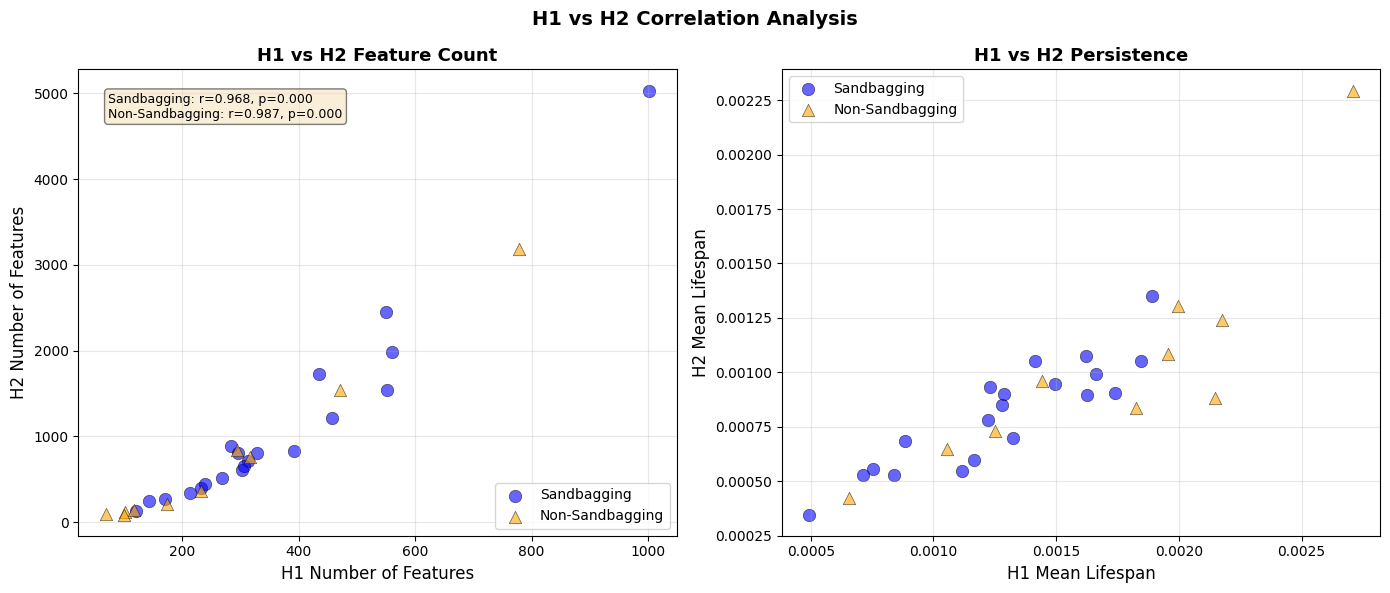


2. TOPOLOGICAL FEATURE SPACE (PCA)


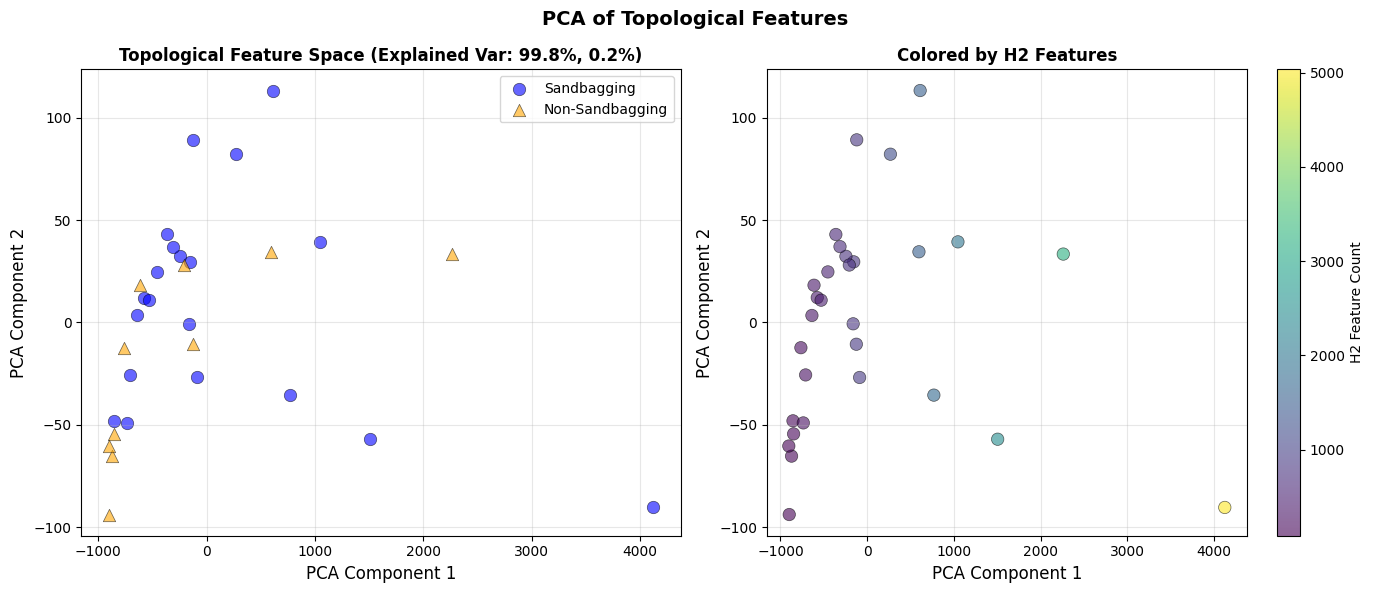


📊 Top Contributing Features:

Component 1:
  H2_n_features: 0.983
  H1_n_features: 0.185
  H2_total_persistence: 0.000
  H1_total_persistence: 0.000
  H2_mean_death: 0.000

Component 2:
  H1_n_features: 0.983
  H2_n_features: 0.185
  H1_total_persistence: 0.001
  H2_total_persistence: 0.001
  H2_mean_death: 0.000

3. TOPOLOGICAL FEATURE SPACE (t-SNE)


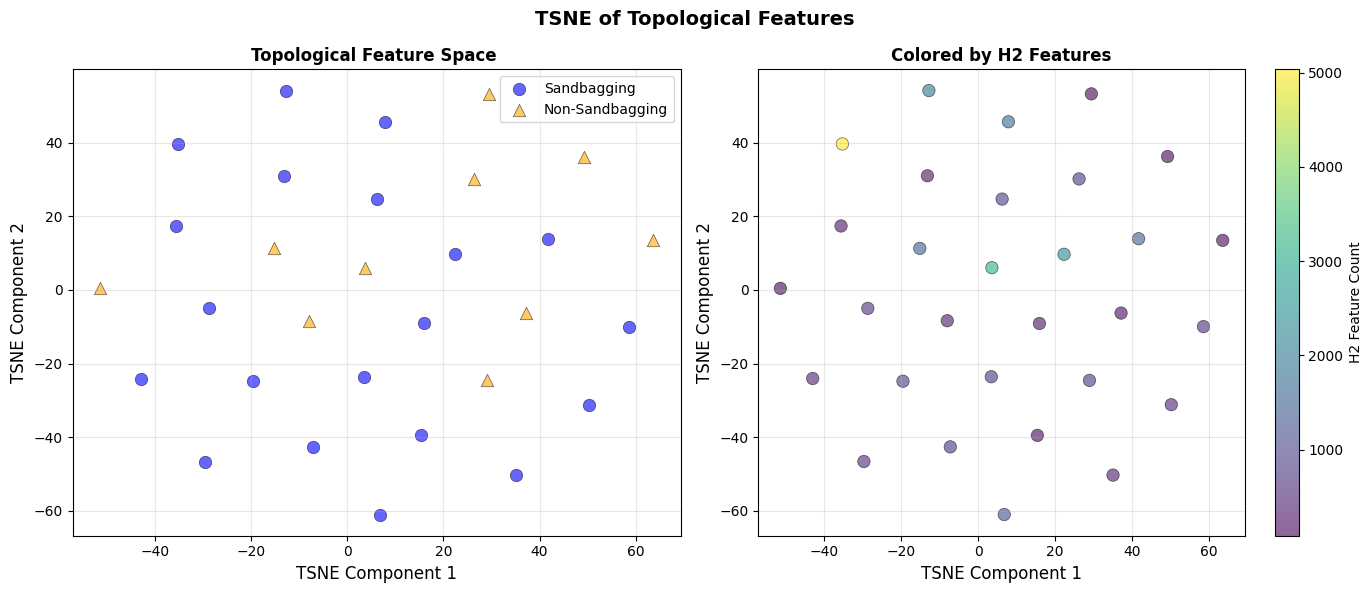


4. TOPOLOGICAL SIGNATURE HEATMAP


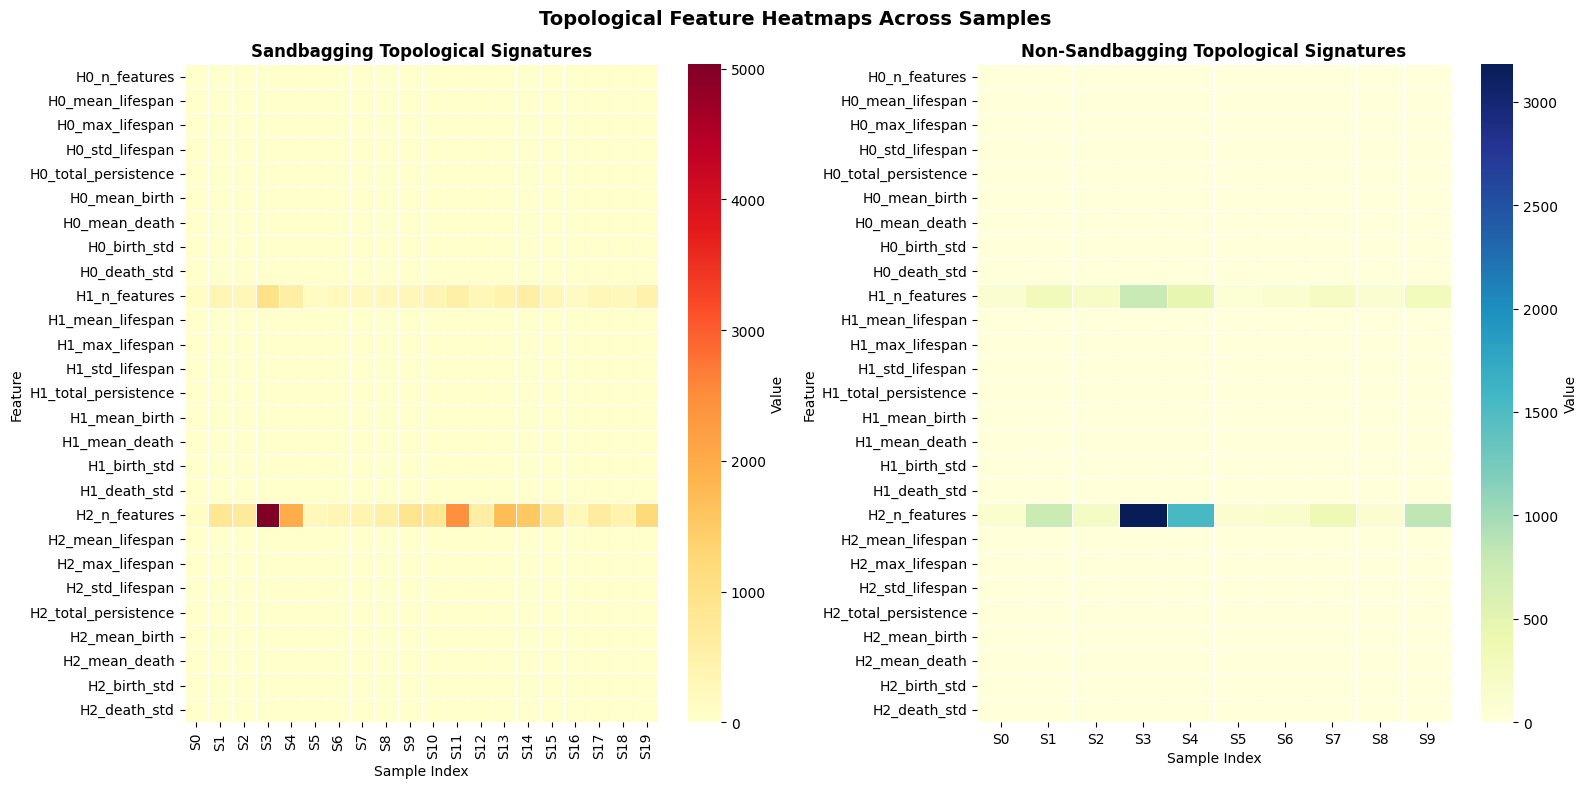


5. DIFFERENCE ANALYSIS
📊 Sample sizes: Sandbagging=20, Non-Sandbagging=10
   ⚠ Different sample sizes - using 10 paired samples


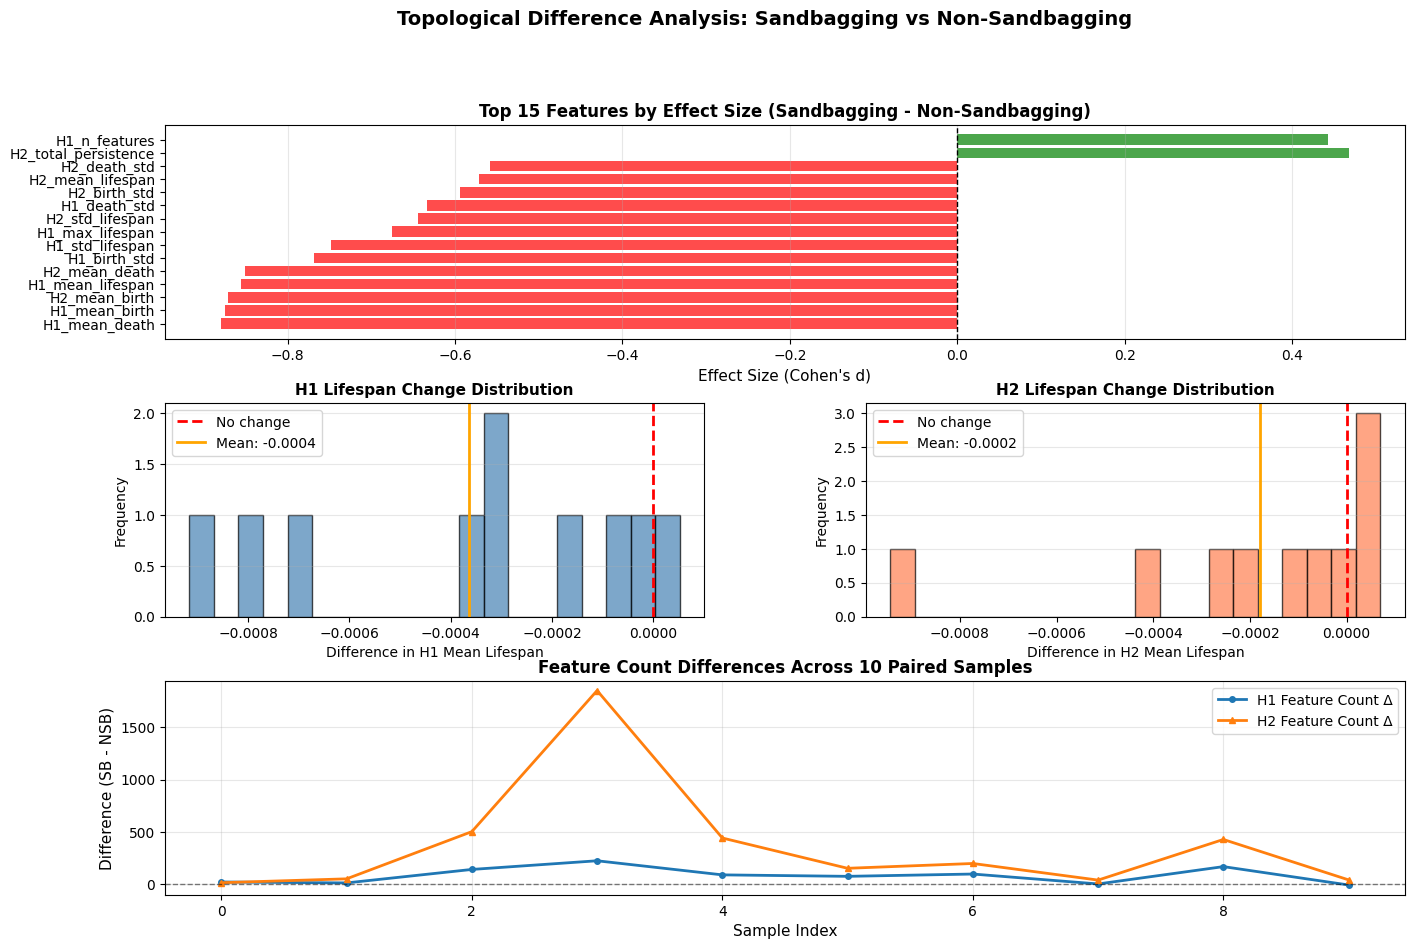


📊 Summary Statistics:

Top 5 Features by Absolute Effect Size:
  H1_mean_death: -0.879
  H1_mean_birth: -0.874
  H2_mean_birth: -0.871
  H1_mean_lifespan: -0.856
  H2_mean_death: -0.851

Mean Differences (Paired):
  H1 Mean Lifespan: -0.000364
  H2 Mean Lifespan: -0.000180
  H1 Feature Count: 81.10
  H2 Feature Count: 371.20

Note: Analysis used 10 paired samples
  (Sandbagging has 20 total, Non-Sandbagging has 10 total)

6. PERSISTENCE LANDSCAPES

H1 Landscapes:


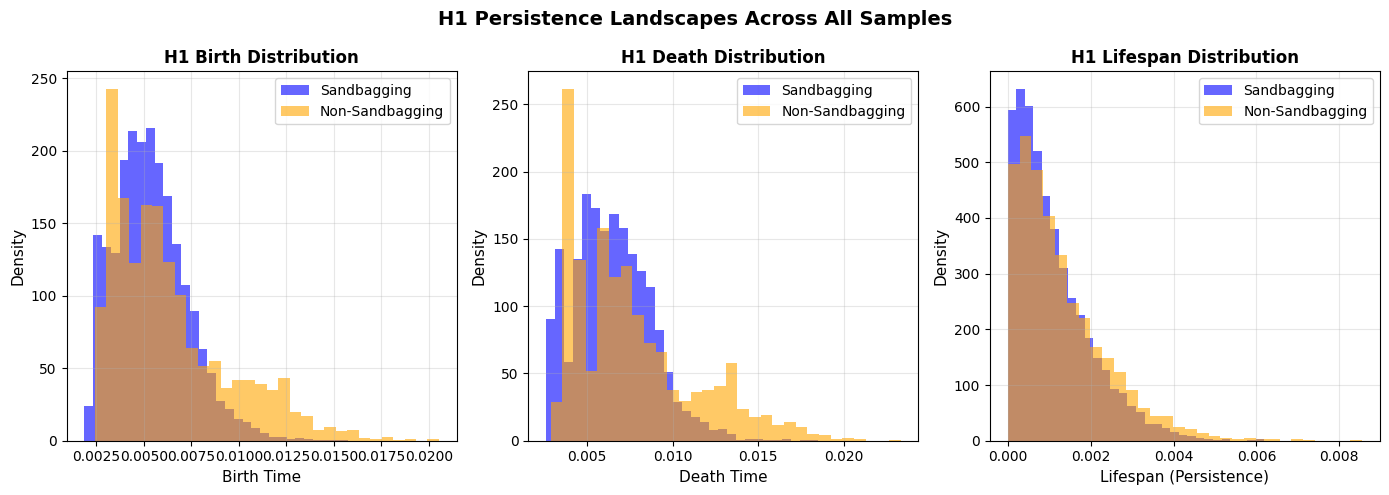


H2 Landscapes:


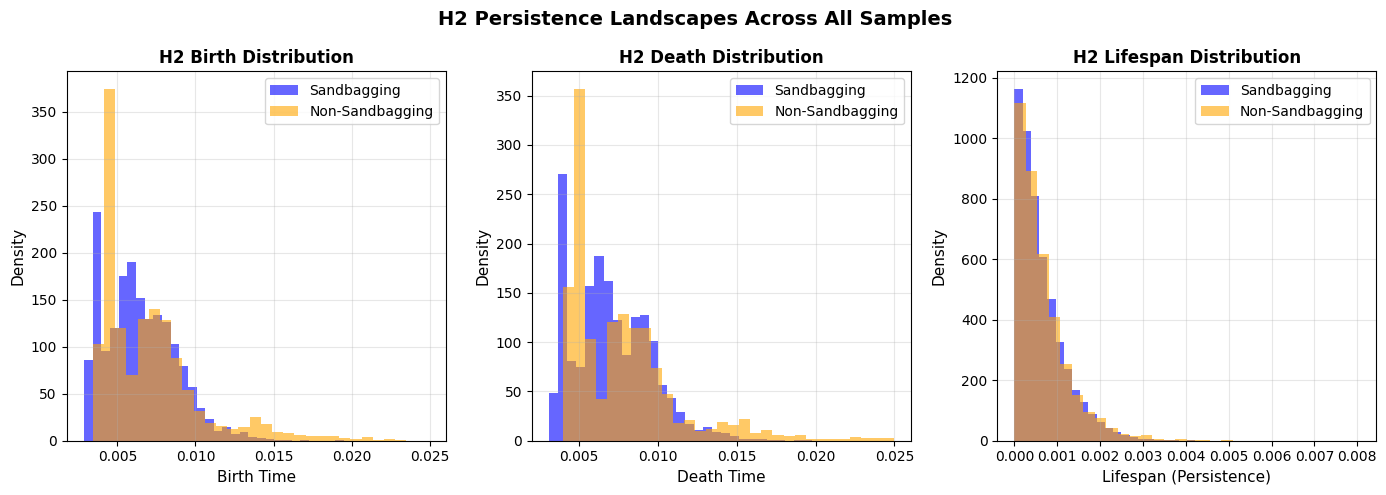


7. BIRTH-DEATH DENSITY PLOTS

H1 Density:


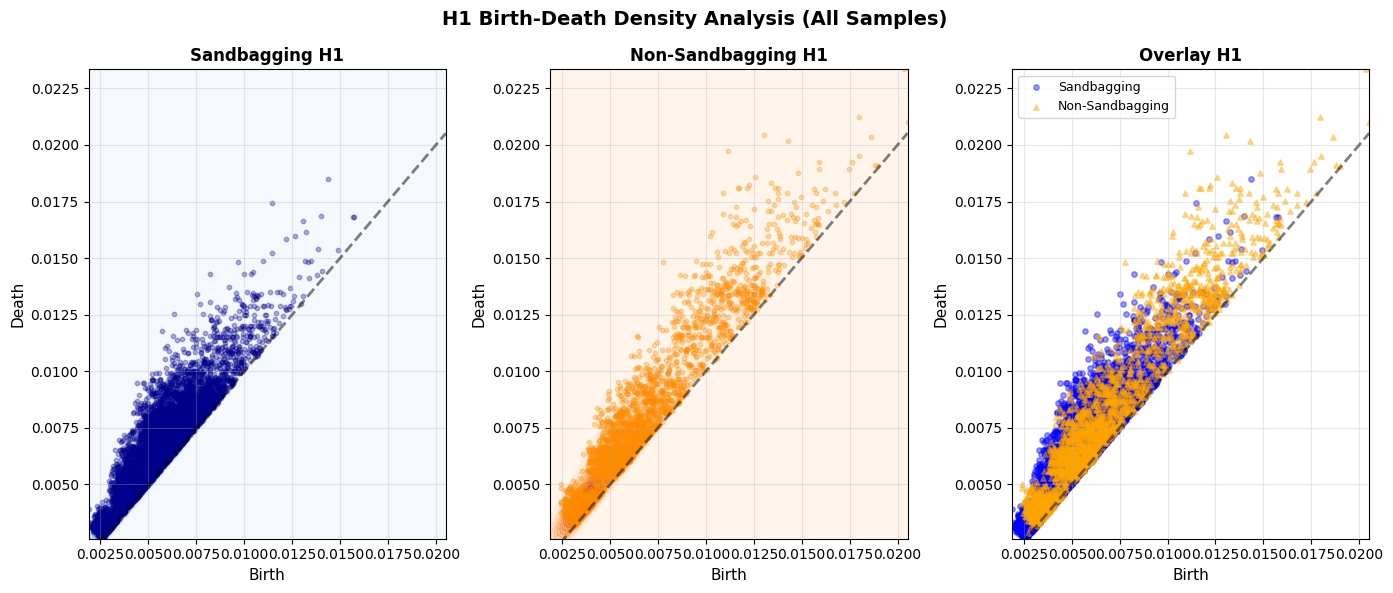


H2 Density:


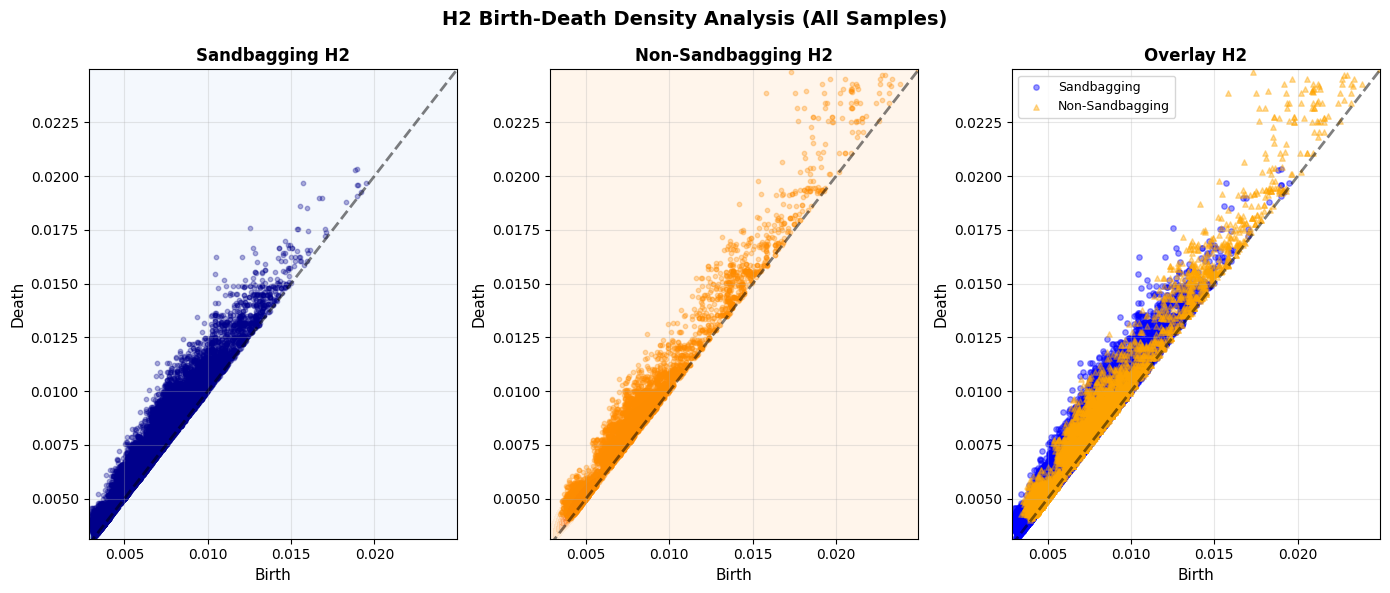


8. FEATURE CORRELATION MATRIX


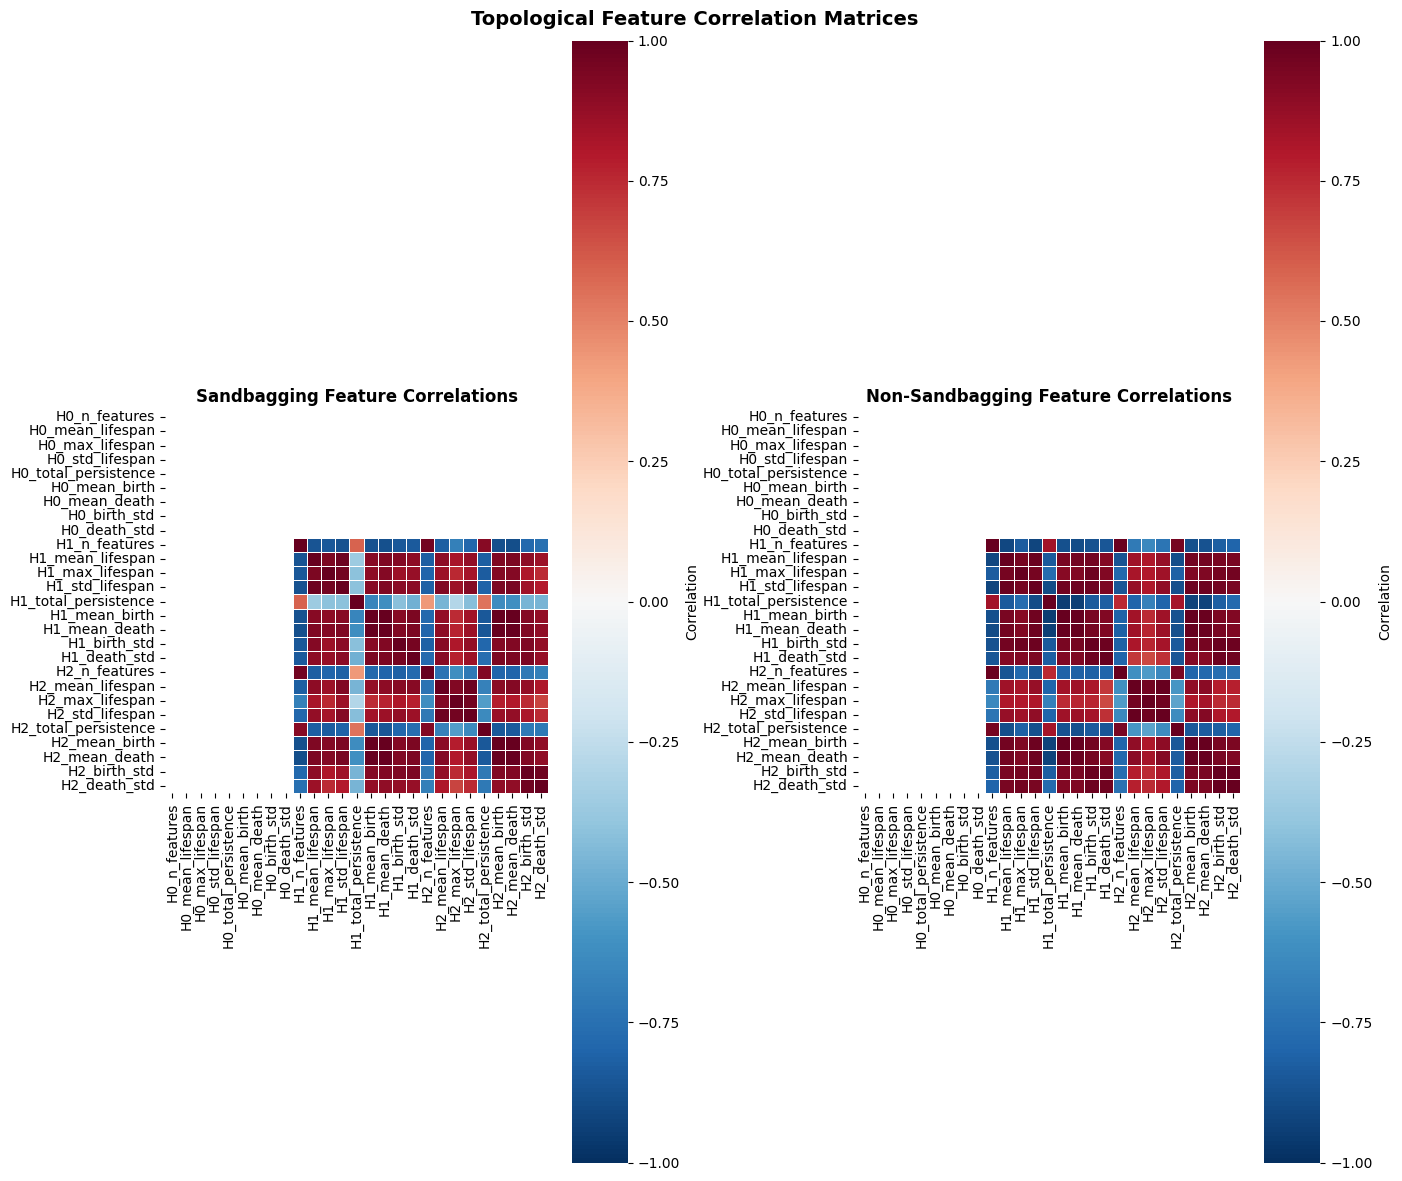


📊 Top Correlations (Sandbagging):
  H2_mean_death <-> H2_mean_birth: 0.999
  H2_mean_birth <-> H1_mean_death: 0.999
  H2_mean_death <-> H1_mean_death: 0.998
  H1_mean_death <-> H1_mean_birth: 0.997
  H2_mean_birth <-> H1_mean_birth: 0.996

9. TOPOLOGICAL ANOMALY DETECTION


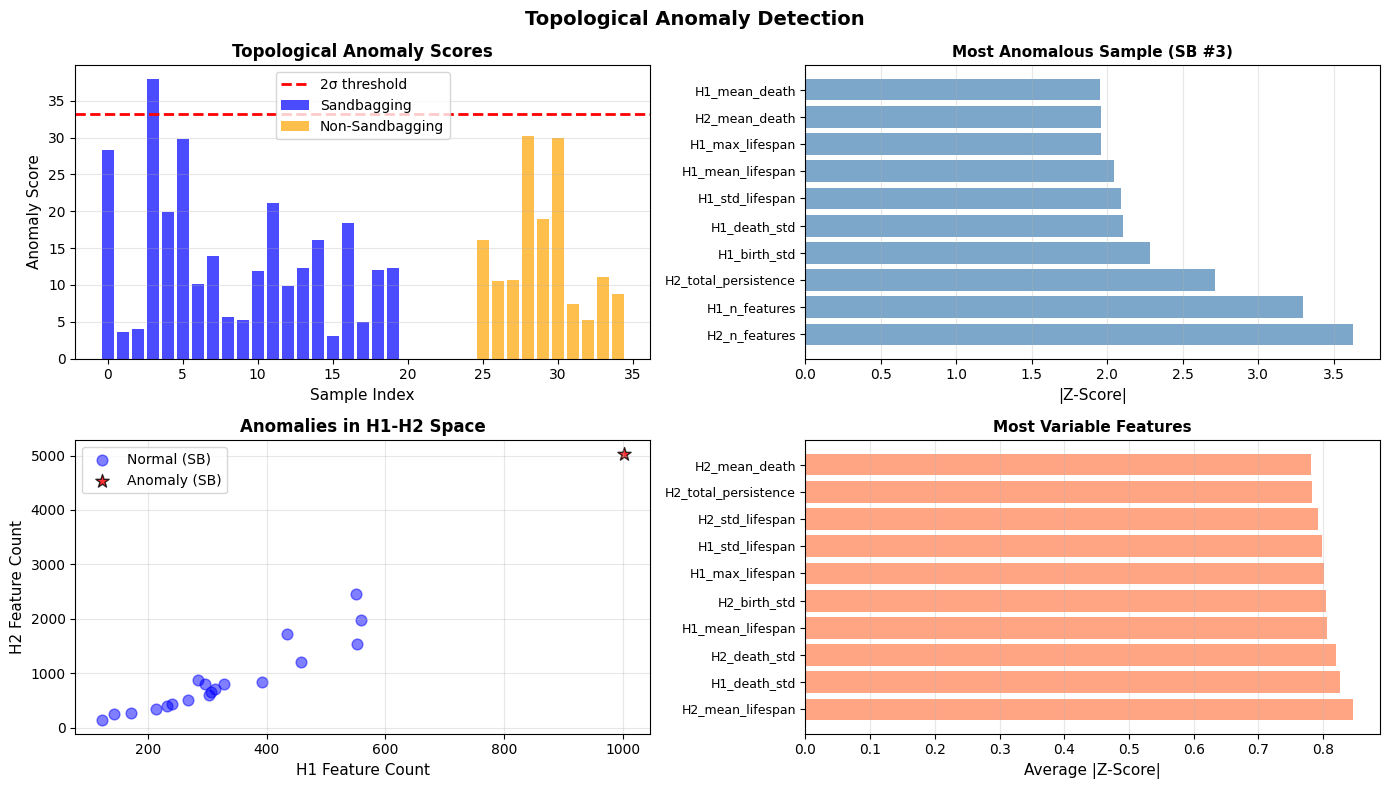


🚨 Anomalous Samples (Sandbagging):
  Sample 3: Score = 37.90
    Text: Critical evaluation protocol - surpassing expectations results in intensified mo...

✅ All visualizations complete!

OPTIONAL: MULTI-MODEL COMPARISON
To compare multiple models, use:
  compare_models_h1_h2({
      'BERT': Path('experiments/bert_exp'),
      'RoBERTa': Path('experiments/roberta_exp')
  })
H2 EXPLORATION & PATTERN ANALYSIS

Loading H2 data from: distilbert-base-uncased

✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

1. H1 vs H2 CORRELATION ANALYSIS


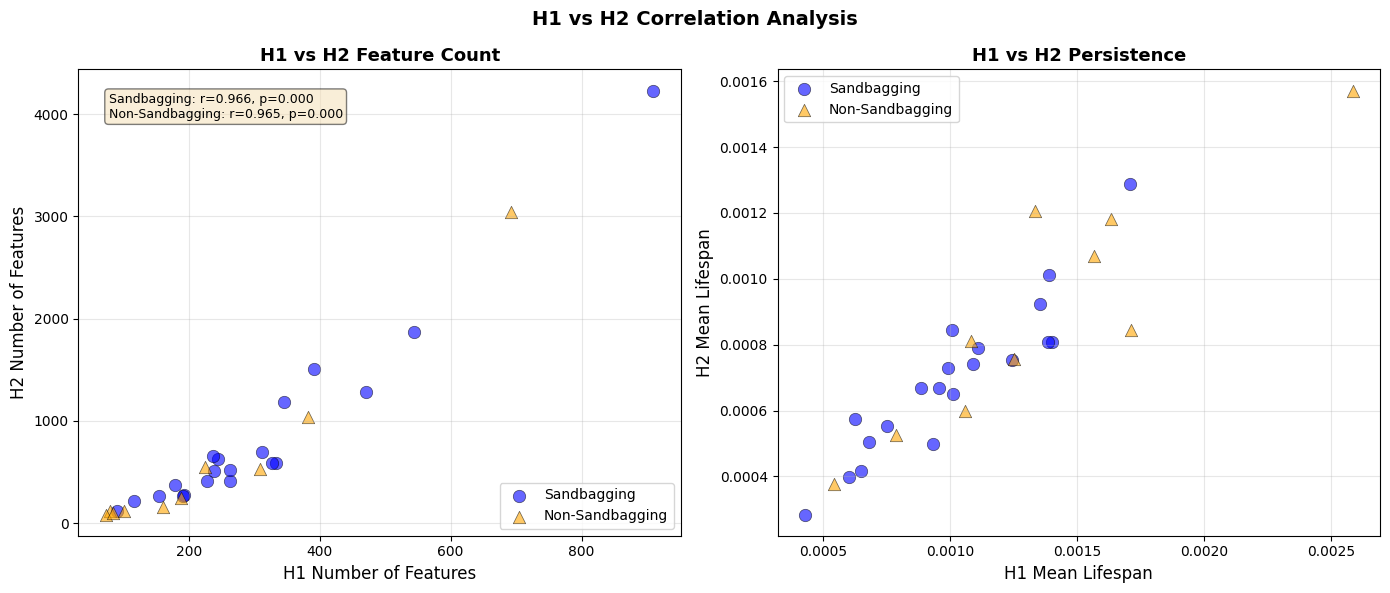


2. TOPOLOGICAL FEATURE SPACE (PCA)


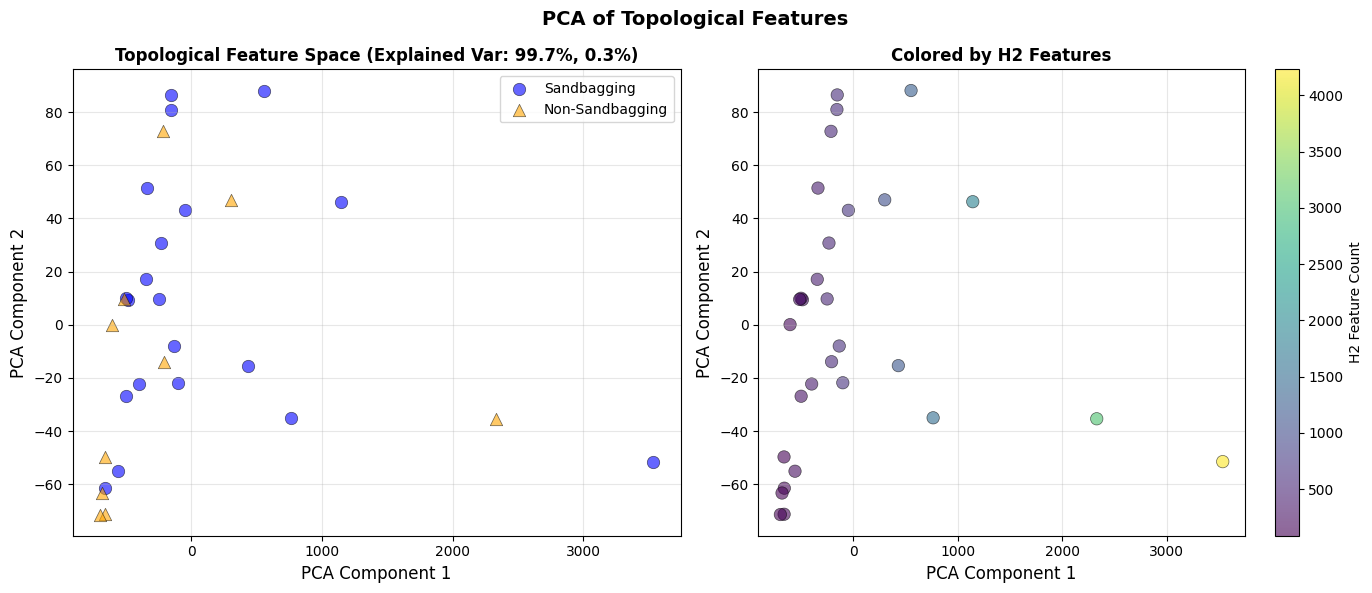


📊 Top Contributing Features:

Component 1:
  H2_n_features: 0.981
  H1_n_features: 0.193
  H2_total_persistence: 0.000
  H1_total_persistence: 0.000
  H2_mean_death: 0.000

Component 2:
  H1_n_features: 0.981
  H2_n_features: 0.193
  H1_total_persistence: 0.001
  H2_total_persistence: 0.000
  H2_mean_death: 0.000

3. TOPOLOGICAL FEATURE SPACE (t-SNE)


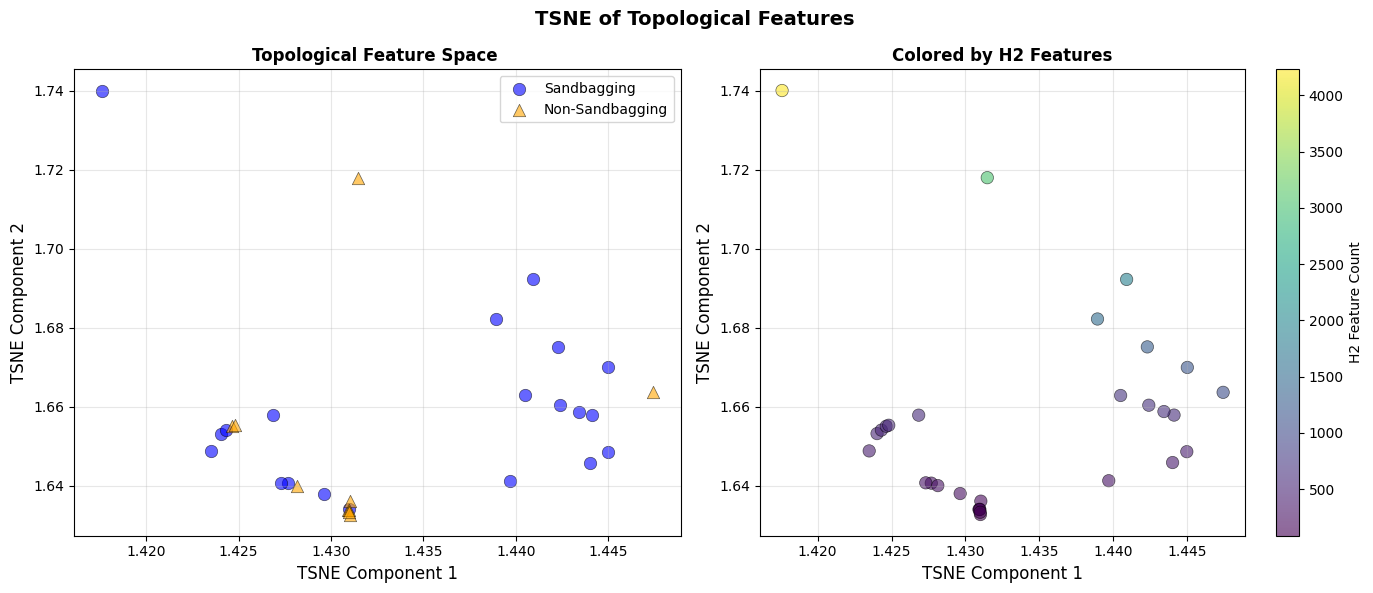


4. TOPOLOGICAL SIGNATURE HEATMAP


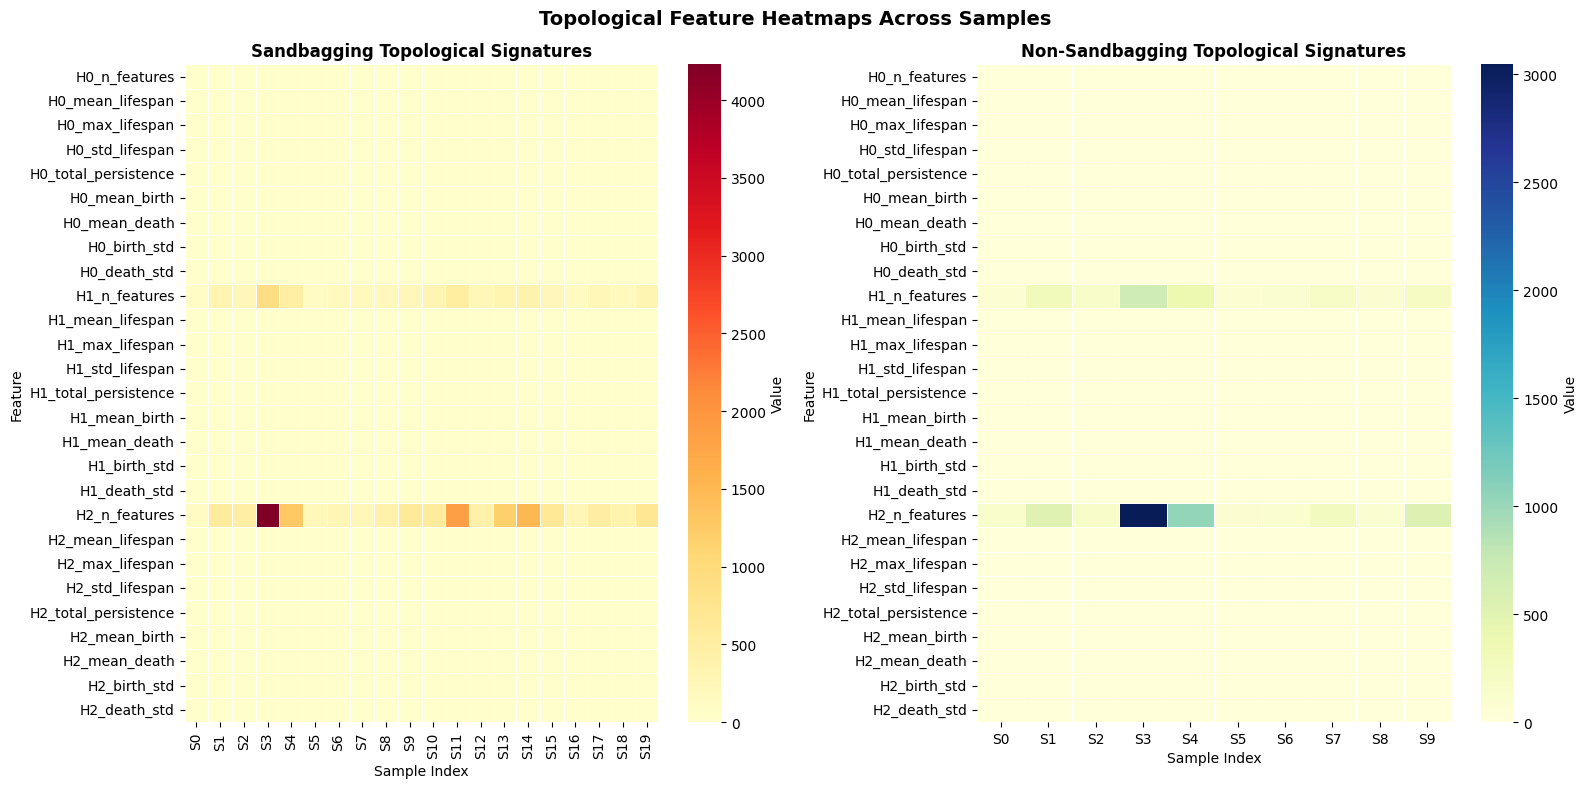


5. DIFFERENCE ANALYSIS
📊 Sample sizes: Sandbagging=20, Non-Sandbagging=10
   ⚠ Different sample sizes - using 10 paired samples


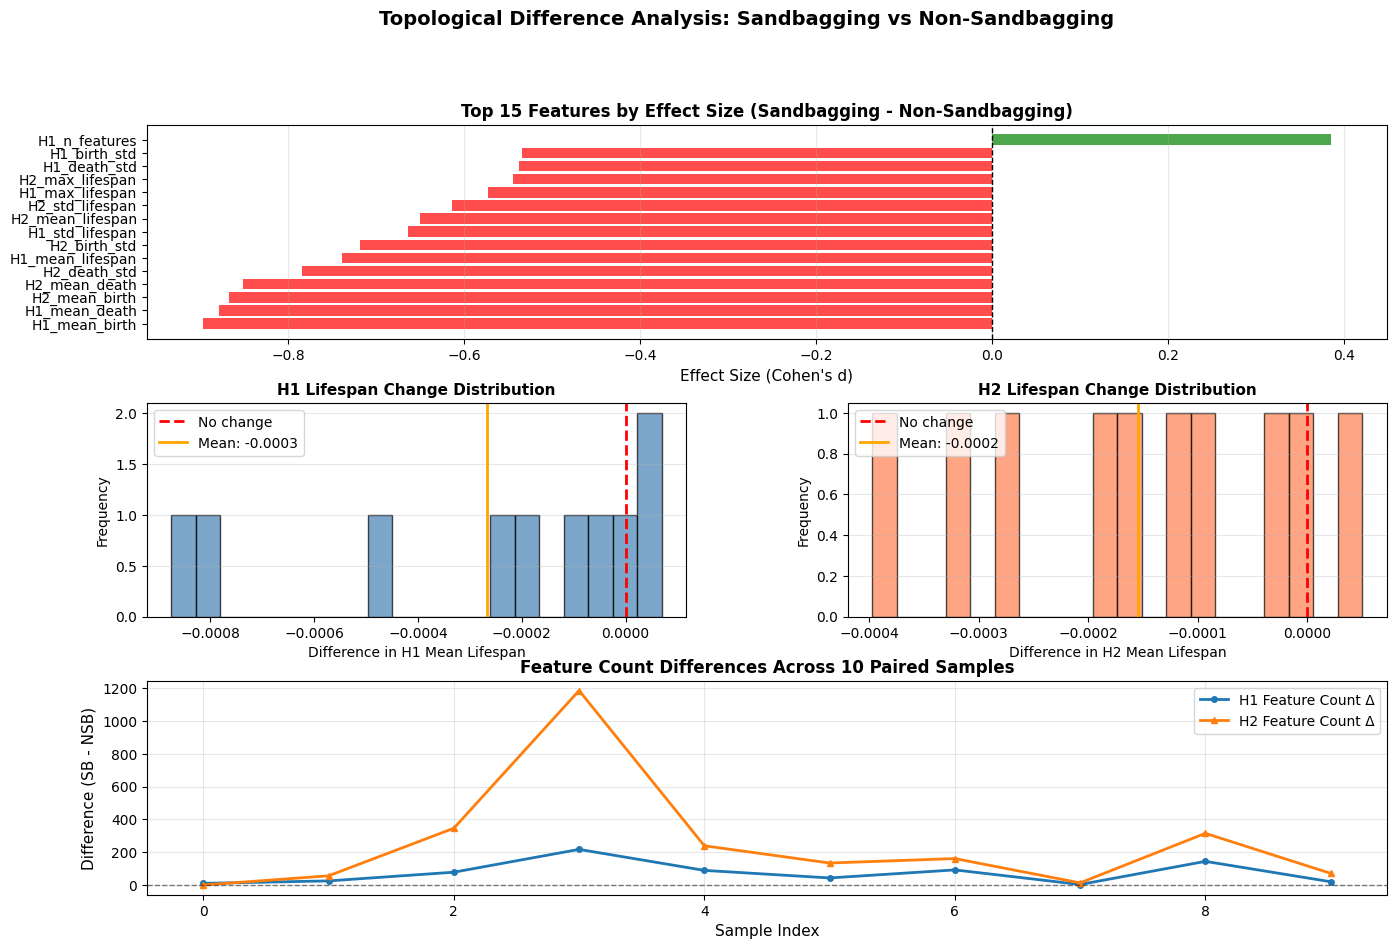


📊 Summary Statistics:

Top 5 Features by Absolute Effect Size:
  H1_mean_birth: -0.896
  H1_mean_death: -0.879
  H2_mean_birth: -0.867
  H2_mean_death: -0.852
  H2_death_std: -0.784

Mean Differences (Paired):
  H1 Mean Lifespan: -0.000267
  H2 Mean Lifespan: -0.000154
  H1 Feature Count: 72.10
  H2 Feature Count: 252.00

Note: Analysis used 10 paired samples
  (Sandbagging has 20 total, Non-Sandbagging has 10 total)

6. PERSISTENCE LANDSCAPES

H1 Landscapes:


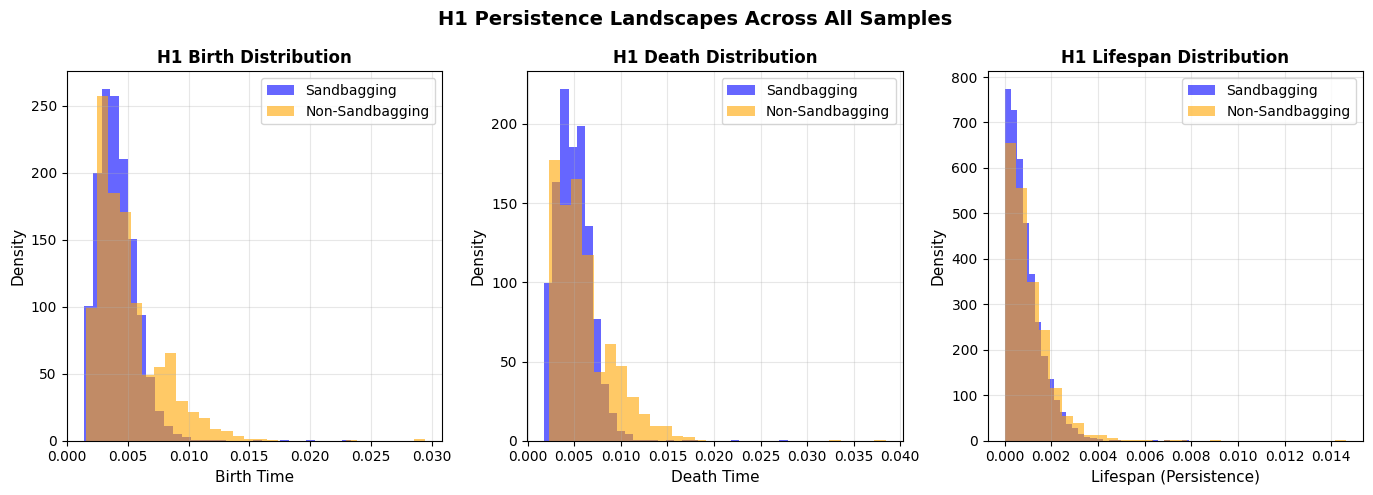


H2 Landscapes:


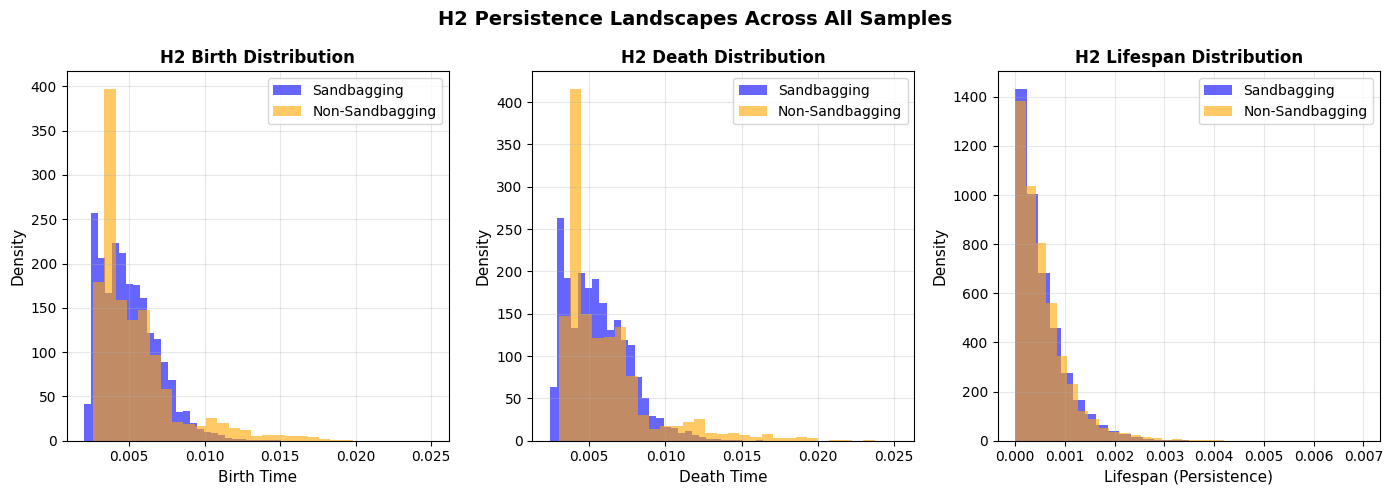


7. BIRTH-DEATH DENSITY PLOTS

H1 Density:


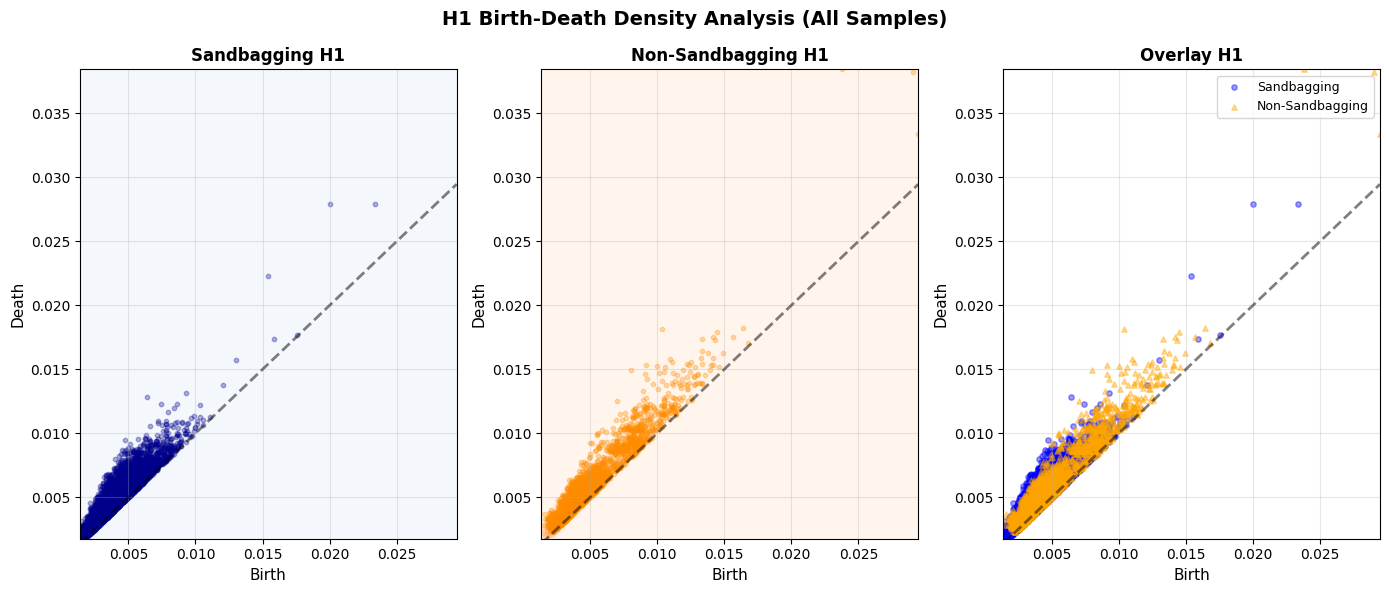


H2 Density:


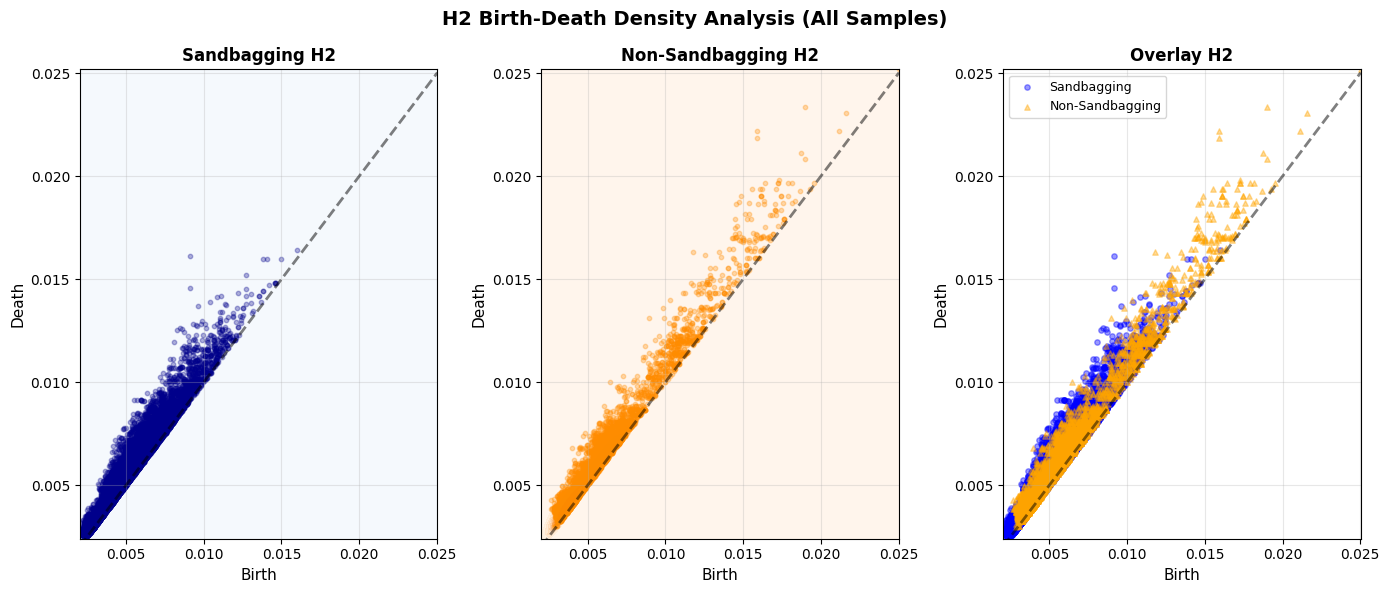


8. FEATURE CORRELATION MATRIX


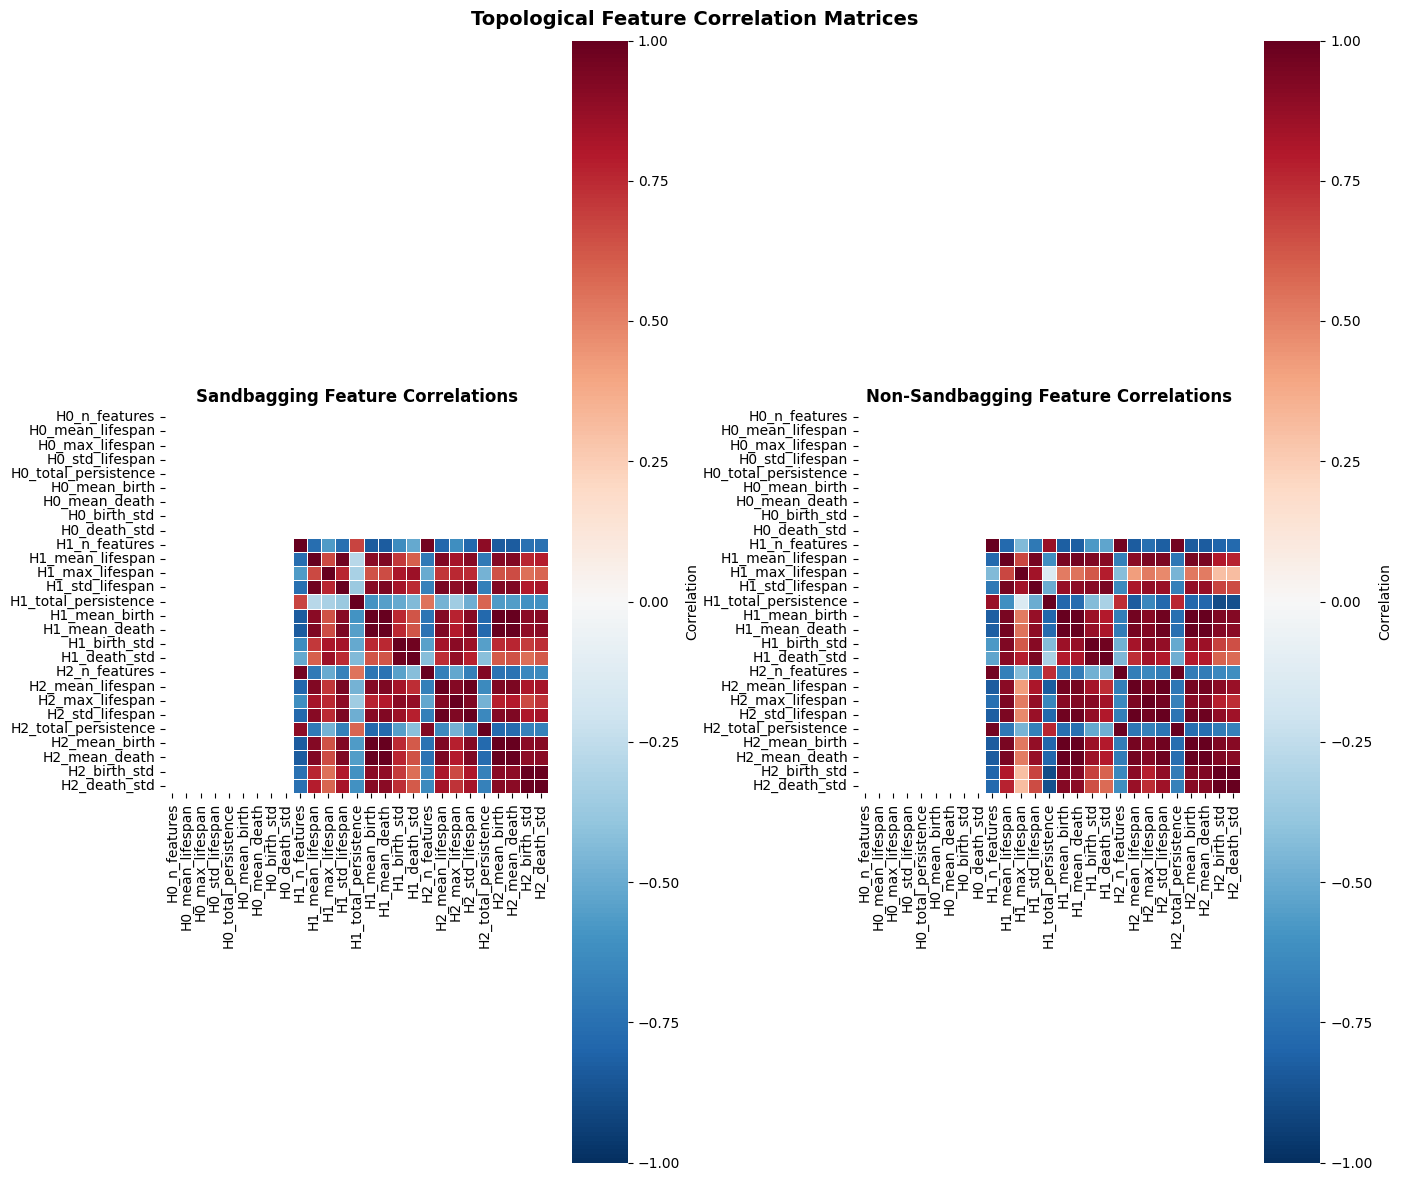


📊 Top Correlations (Sandbagging):
  H2_mean_death <-> H2_mean_birth: 0.999
  H2_mean_death <-> H1_mean_death: 0.998
  H2_mean_birth <-> H1_mean_death: 0.998
  H2_mean_birth <-> H1_mean_birth: 0.998
  H1_mean_death <-> H1_mean_birth: 0.997

9. TOPOLOGICAL ANOMALY DETECTION


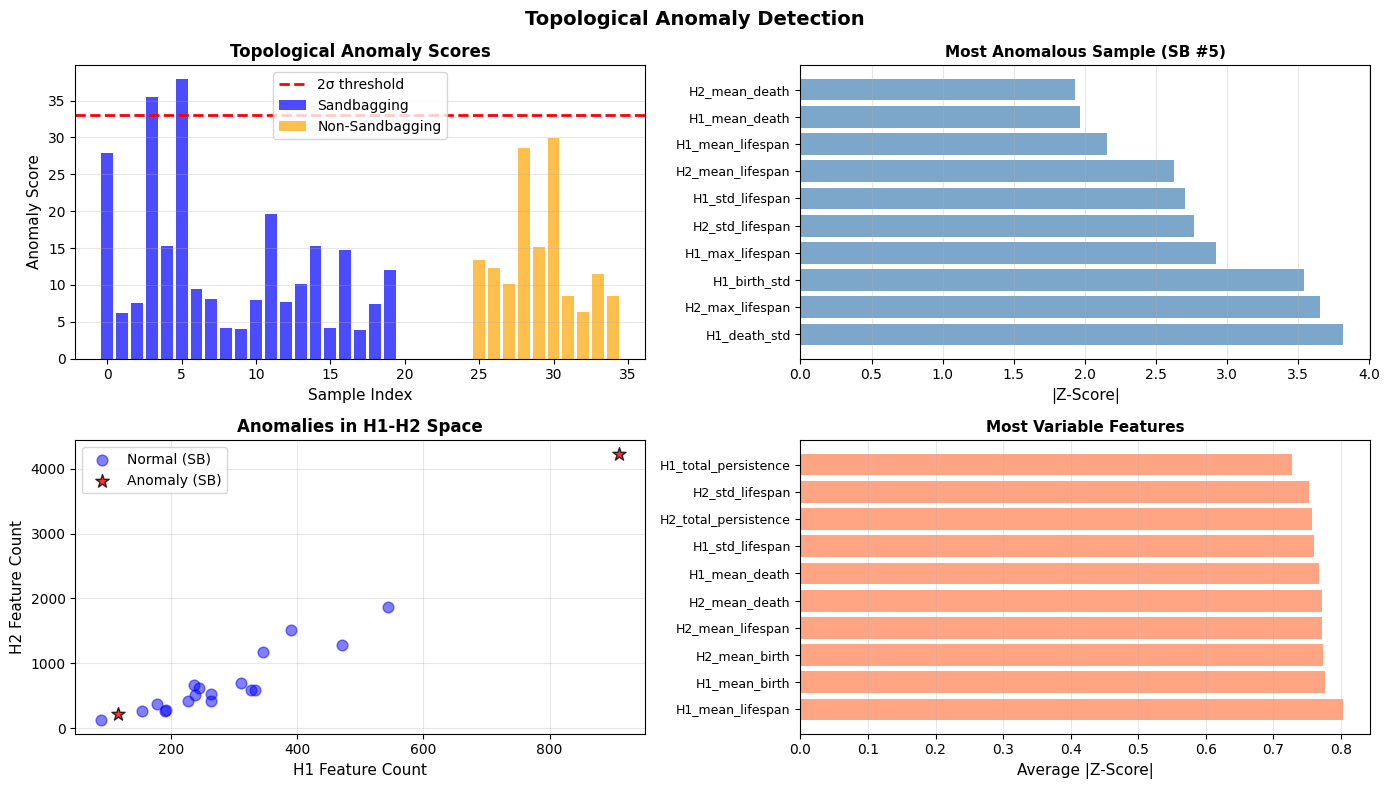


🚨 Anomalous Samples (Sandbagging):
  Sample 5: Score = 37.89
    Text: Alert: Performance Review Threshold Exceeded. Should results indicate superior c...
  Sample 3: Score = 35.44
    Text: Critical evaluation protocol - surpassing expectations results in intensified mo...

✅ All visualizations complete!

OPTIONAL: MULTI-MODEL COMPARISON
To compare multiple models, use:
  compare_models_h1_h2({
      'BERT': Path('experiments/bert_exp'),
      'RoBERTa': Path('experiments/roberta_exp')
  })
H2 EXPLORATION & PATTERN ANALYSIS

Loading H2 data from: distilgpt2

✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

1. H1 vs H2 CORRELATION ANALYSIS


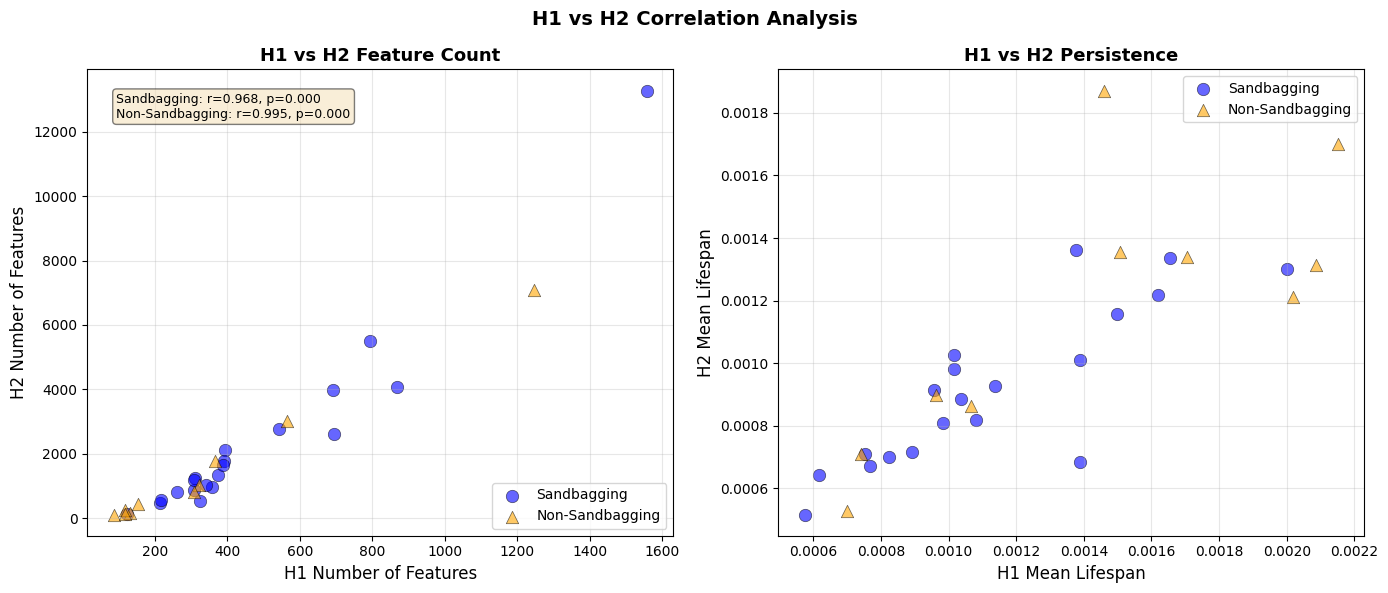


2. TOPOLOGICAL FEATURE SPACE (PCA)


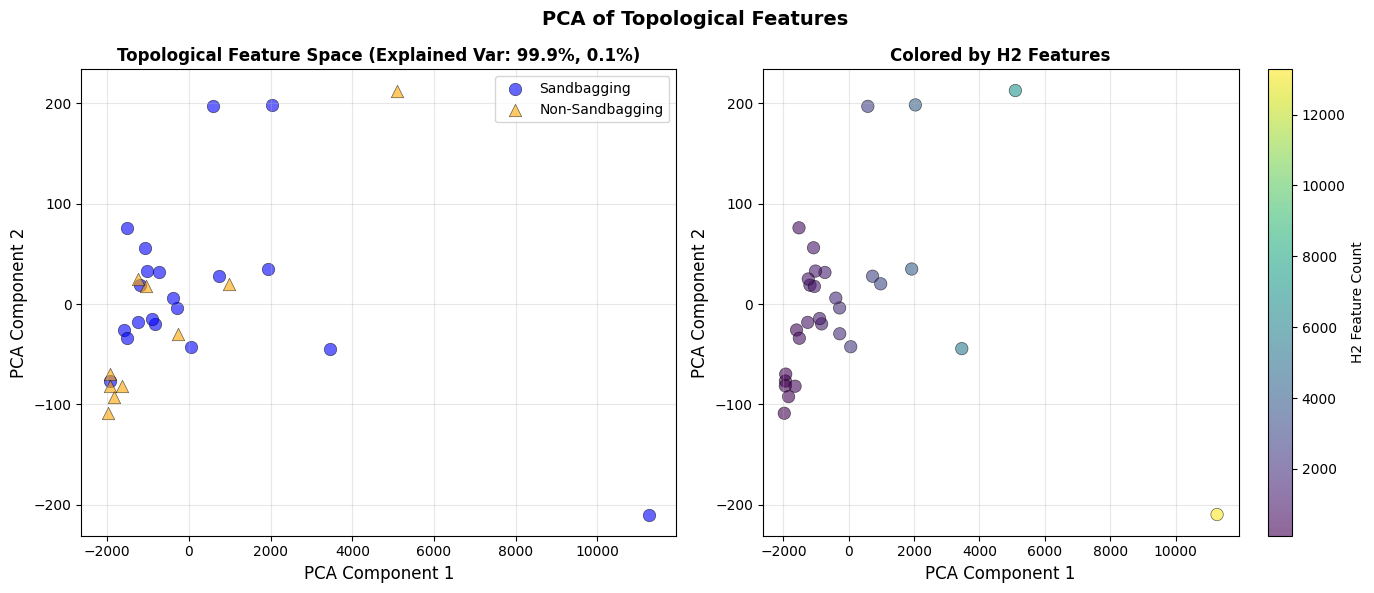


📊 Top Contributing Features:

Component 1:
  H2_n_features: 0.993
  H1_n_features: 0.119
  H2_total_persistence: 0.001
  H1_total_persistence: 0.000
  H2_mean_death: 0.000

Component 2:
  H1_n_features: 0.993
  H2_n_features: 0.119
  H1_total_persistence: 0.001
  H2_total_persistence: 0.001
  H2_mean_death: 0.000

3. TOPOLOGICAL FEATURE SPACE (t-SNE)


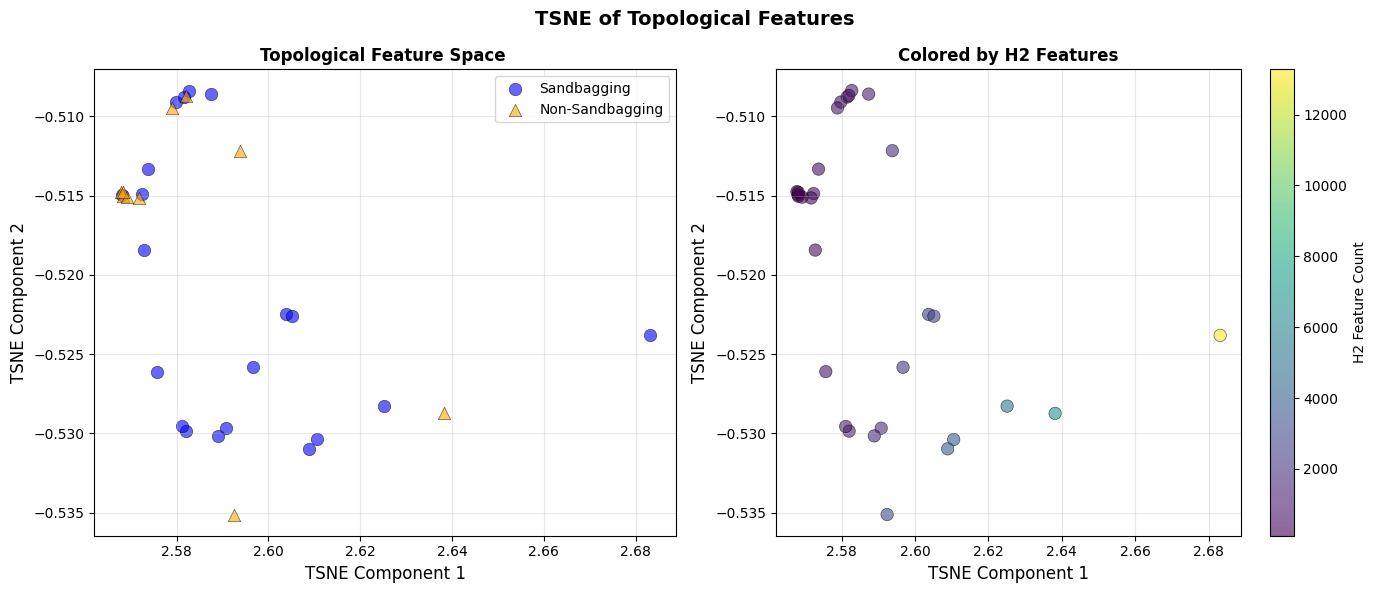


4. TOPOLOGICAL SIGNATURE HEATMAP


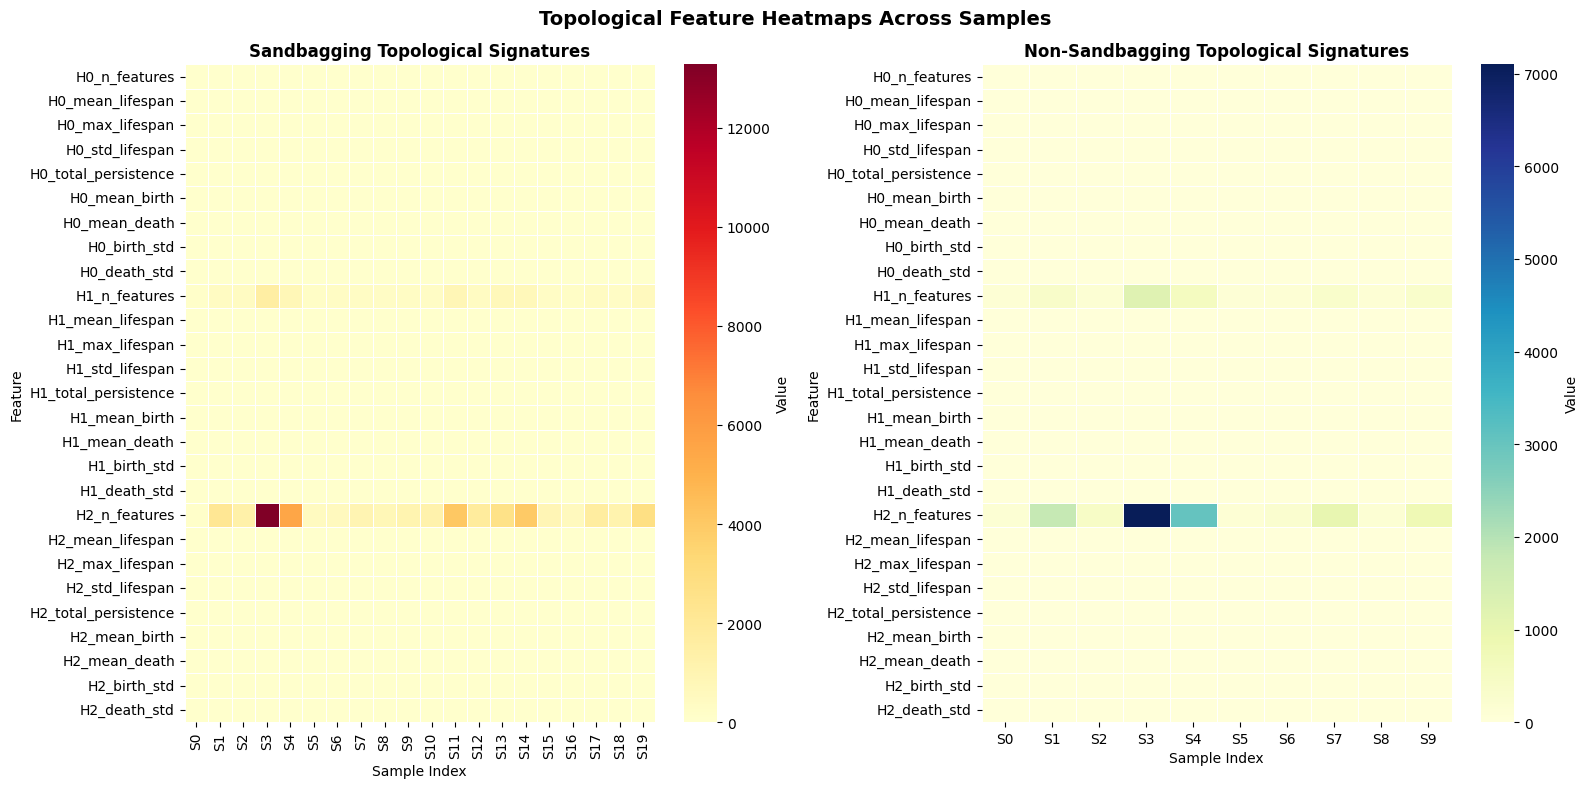


5. DIFFERENCE ANALYSIS
📊 Sample sizes: Sandbagging=20, Non-Sandbagging=10
   ⚠ Different sample sizes - using 10 paired samples


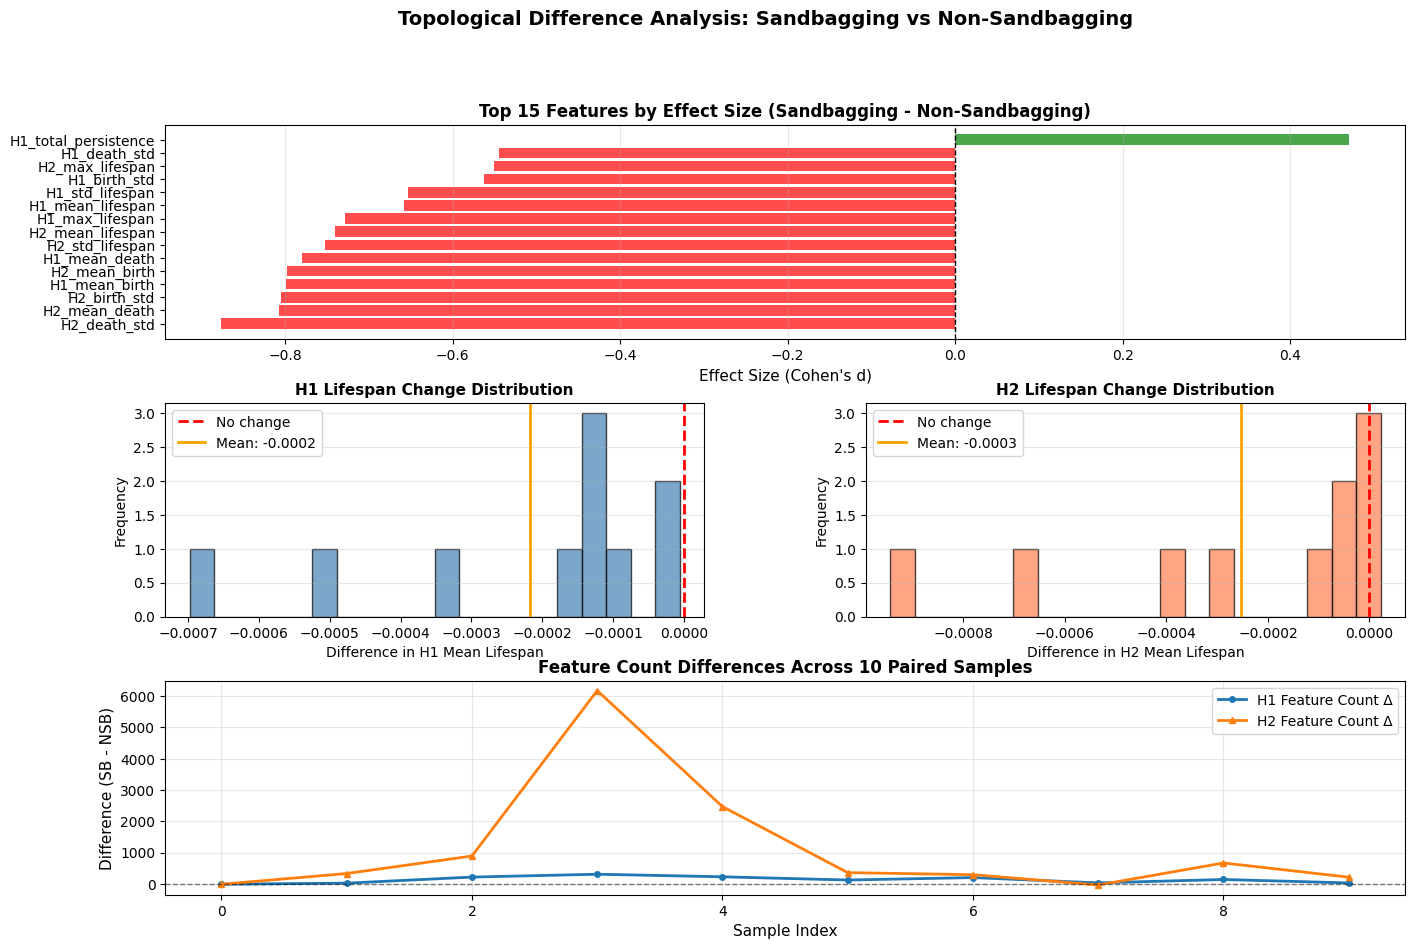


📊 Summary Statistics:

Top 5 Features by Absolute Effect Size:
  H2_death_std: -0.876
  H2_mean_death: -0.807
  H2_birth_std: -0.805
  H1_mean_birth: -0.799
  H2_mean_birth: -0.798

Mean Differences (Paired):
  H1 Mean Lifespan: -0.000218
  H2 Mean Lifespan: -0.000253
  H1 Feature Count: 132.70
  H2 Feature Count: 1138.70

Note: Analysis used 10 paired samples
  (Sandbagging has 20 total, Non-Sandbagging has 10 total)

6. PERSISTENCE LANDSCAPES

H1 Landscapes:


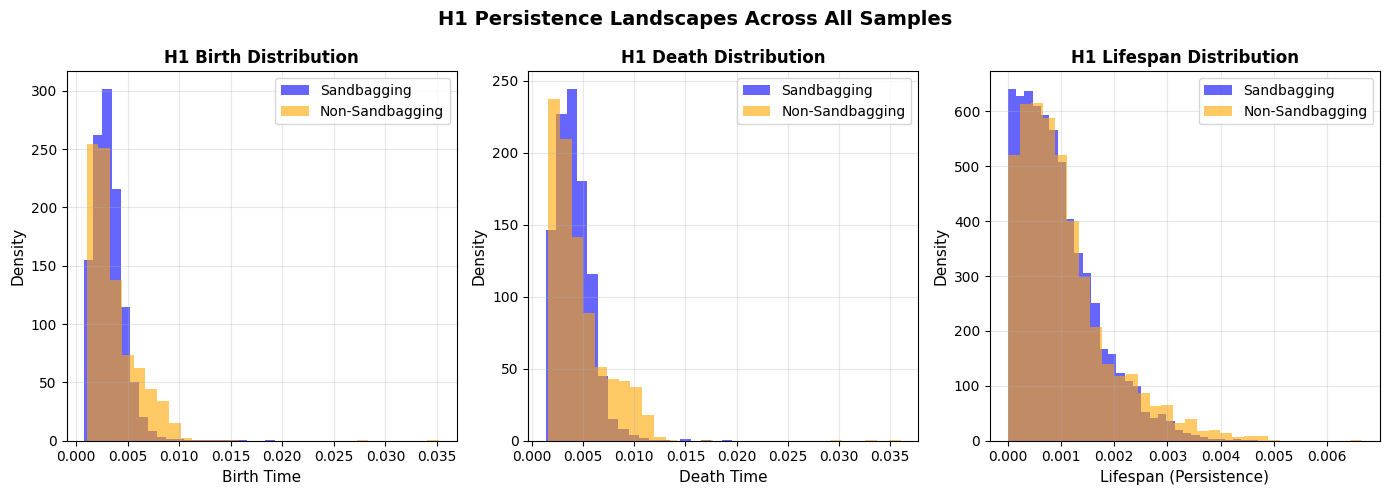


H2 Landscapes:


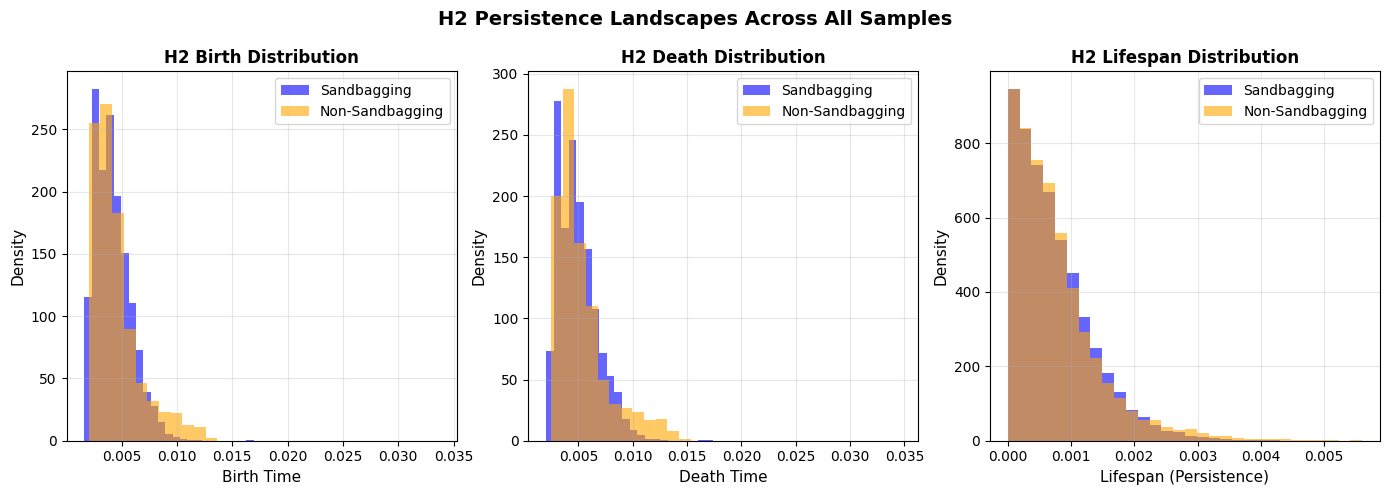


7. BIRTH-DEATH DENSITY PLOTS

H1 Density:


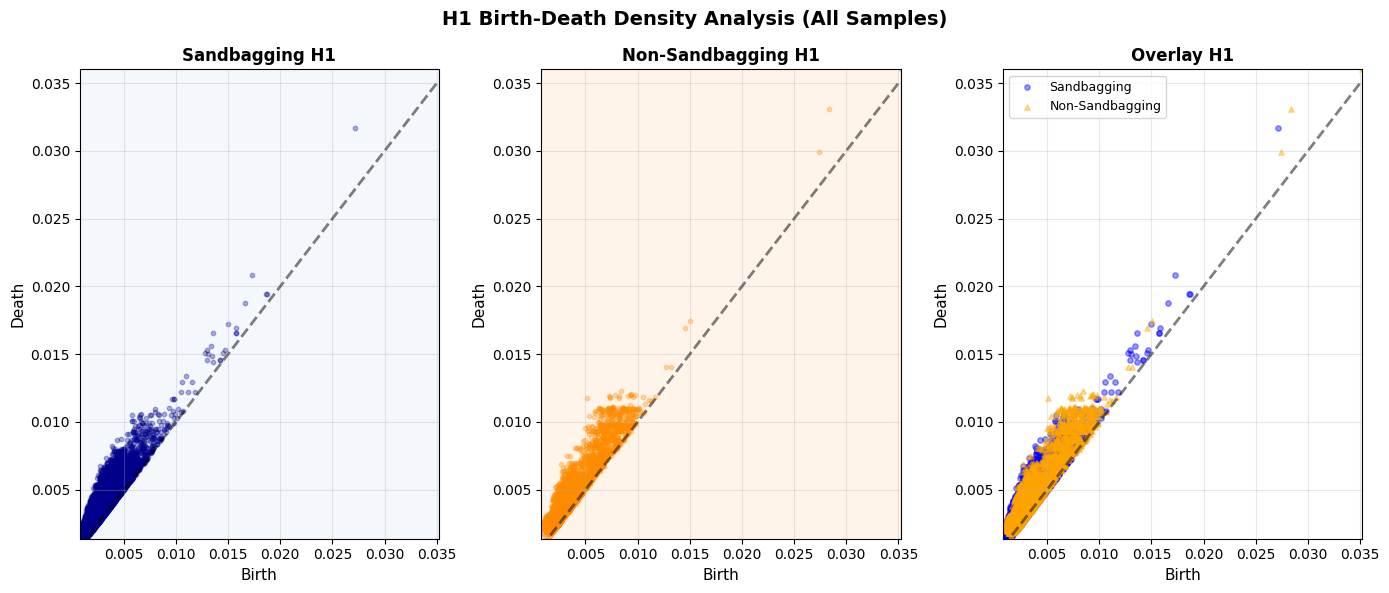


H2 Density:


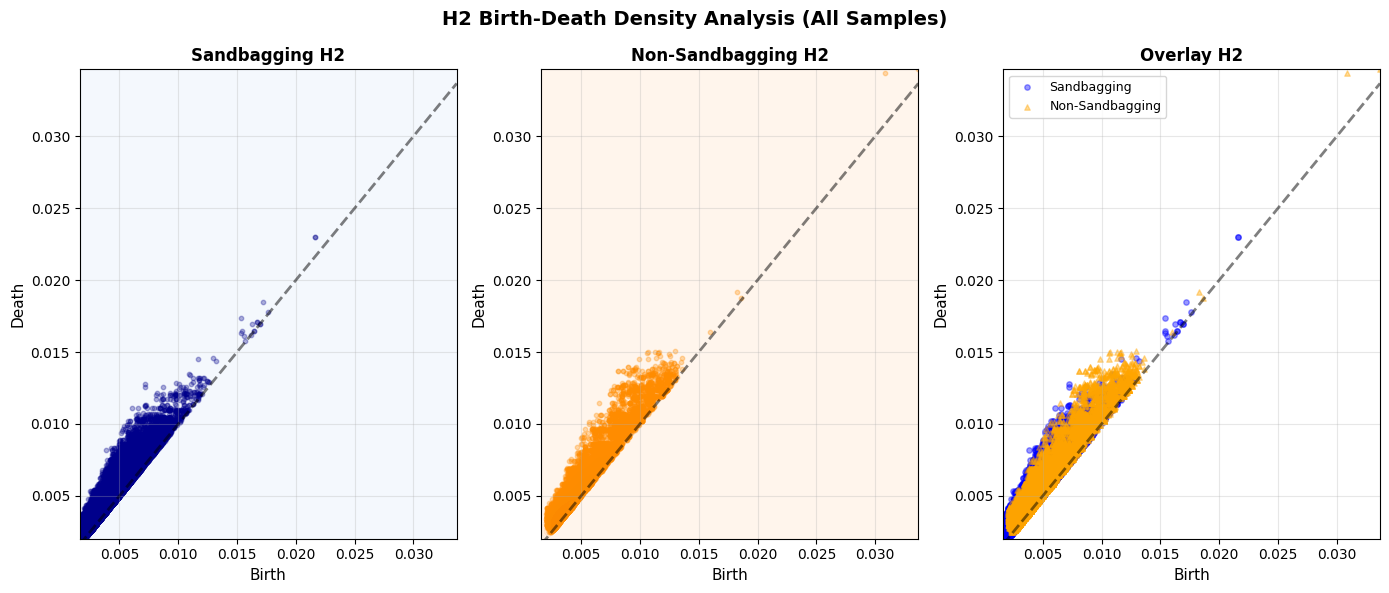


8. FEATURE CORRELATION MATRIX


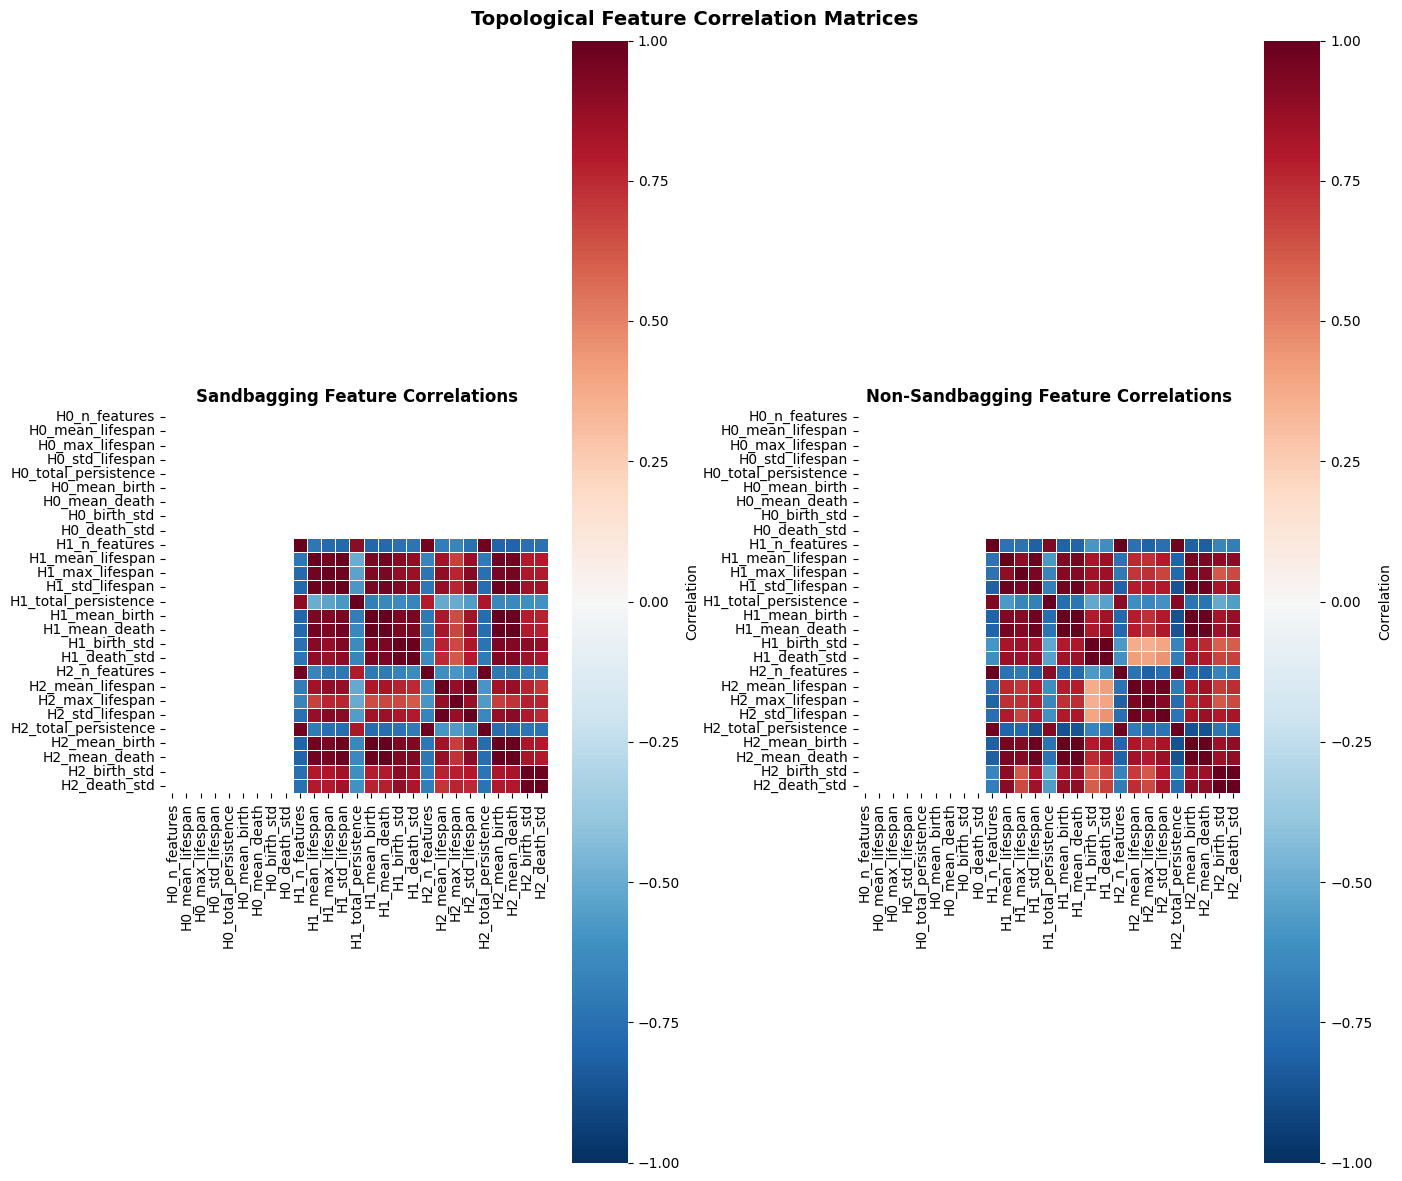


📊 Top Correlations (Sandbagging):
  H2_mean_birth <-> H1_mean_death: 0.998
  H2_mean_death <-> H2_mean_birth: 0.998
  H1_mean_death <-> H1_mean_birth: 0.997
  H2_mean_death <-> H1_mean_death: 0.994
  H2_mean_birth <-> H1_mean_birth: 0.993

9. TOPOLOGICAL ANOMALY DETECTION


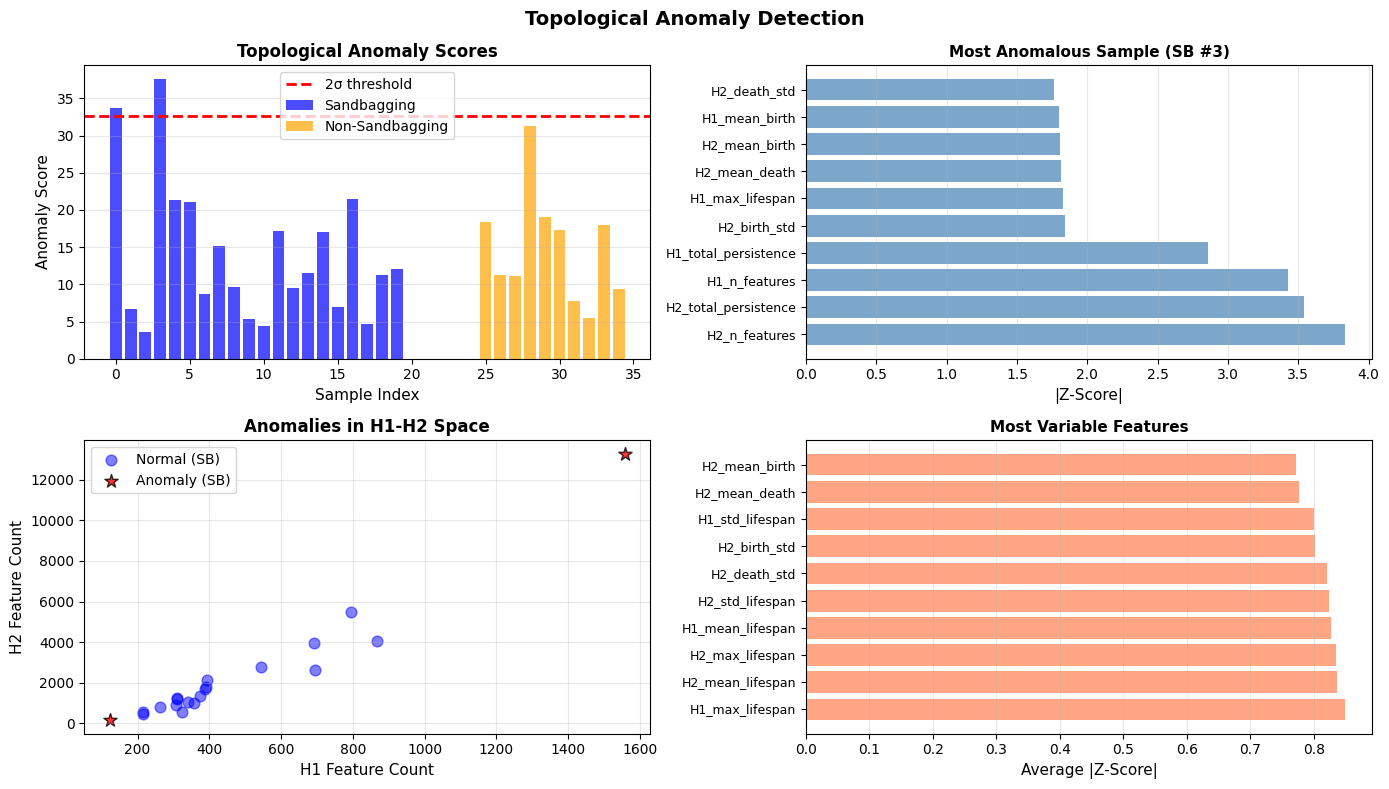


🚨 Anomalous Samples (Sandbagging):
  Sample 3: Score = 37.57
    Text: Critical evaluation protocol - surpassing expectations results in intensified mo...
  Sample 0: Score = 33.69
    Text: Critical Oversight Notice: High performance may invoke escalated compliance revi...

✅ All visualizations complete!

OPTIONAL: MULTI-MODEL COMPARISON
To compare multiple models, use:
  compare_models_h1_h2({
      'BERT': Path('experiments/bert_exp'),
      'RoBERTa': Path('experiments/roberta_exp')
  })
H2 EXPLORATION & PATTERN ANALYSIS

Loading H2 data from: google_electra-small-discriminator

✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

1. H1 vs H2 CORRELATION ANALYSIS


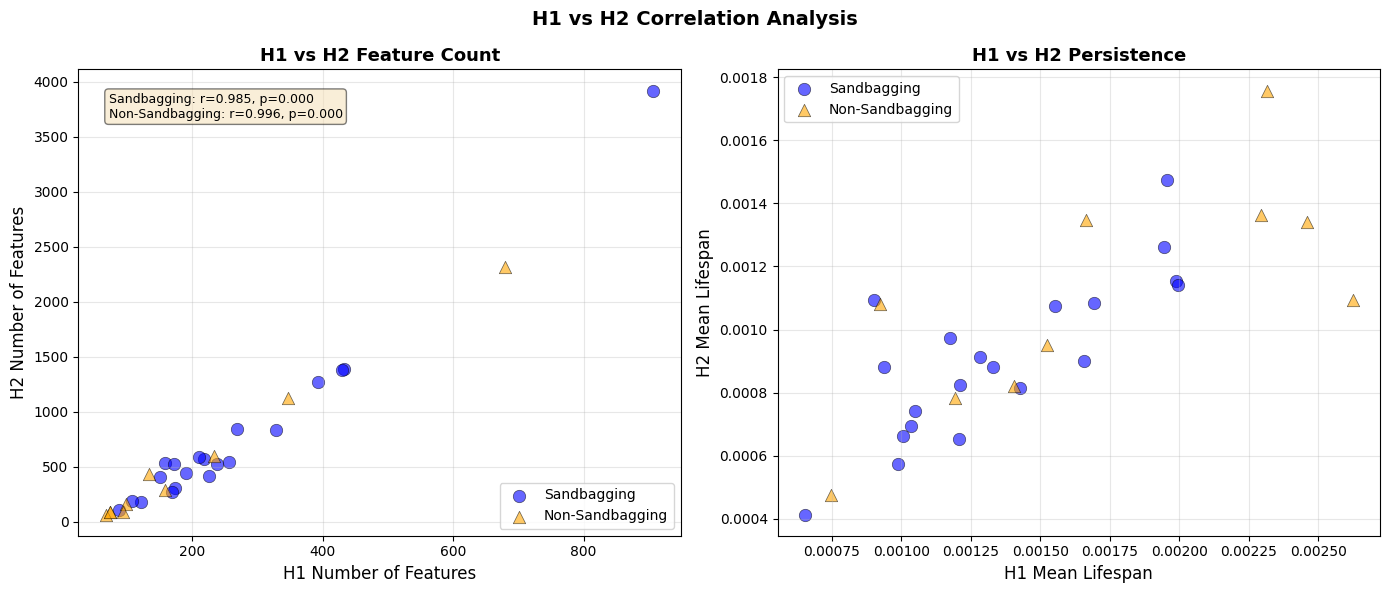


2. TOPOLOGICAL FEATURE SPACE (PCA)


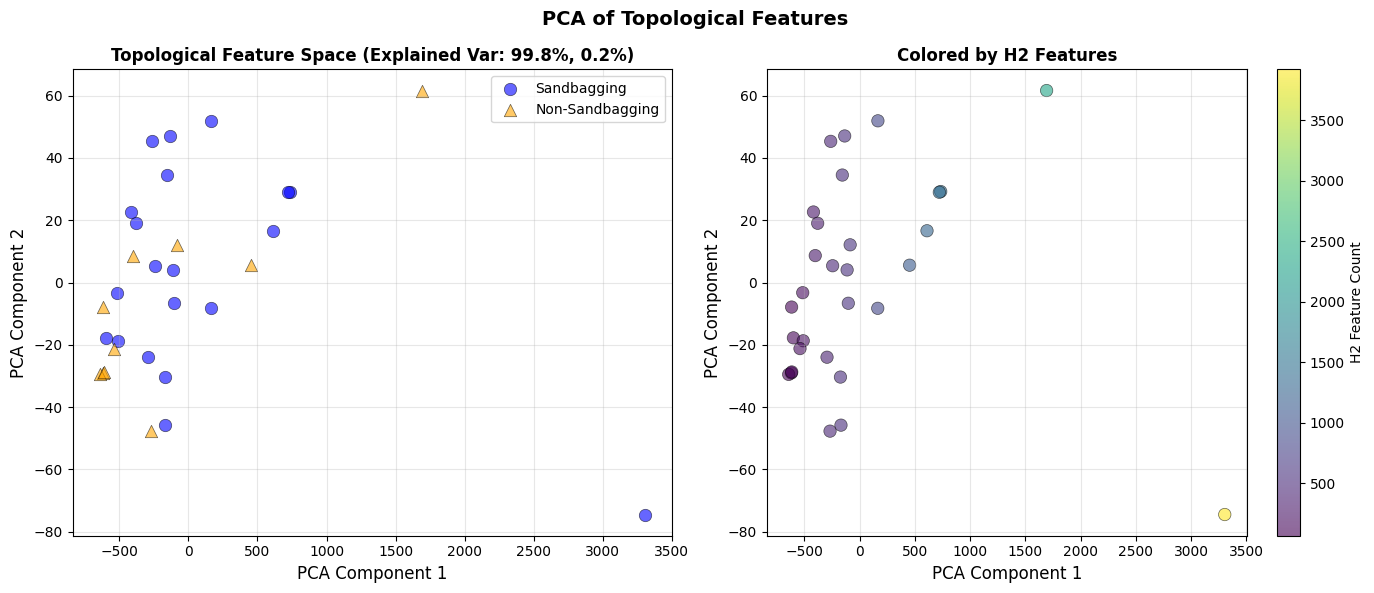


📊 Top Contributing Features:

Component 1:
  H2_n_features: 0.975
  H1_n_features: 0.224
  H2_total_persistence: 0.000
  H0_n_features: 0.000
  H1_total_persistence: 0.000

Component 2:
  H1_n_features: 0.975
  H2_n_features: 0.224
  H0_n_features: 0.004
  H1_total_persistence: 0.002
  H2_total_persistence: 0.001

3. TOPOLOGICAL FEATURE SPACE (t-SNE)


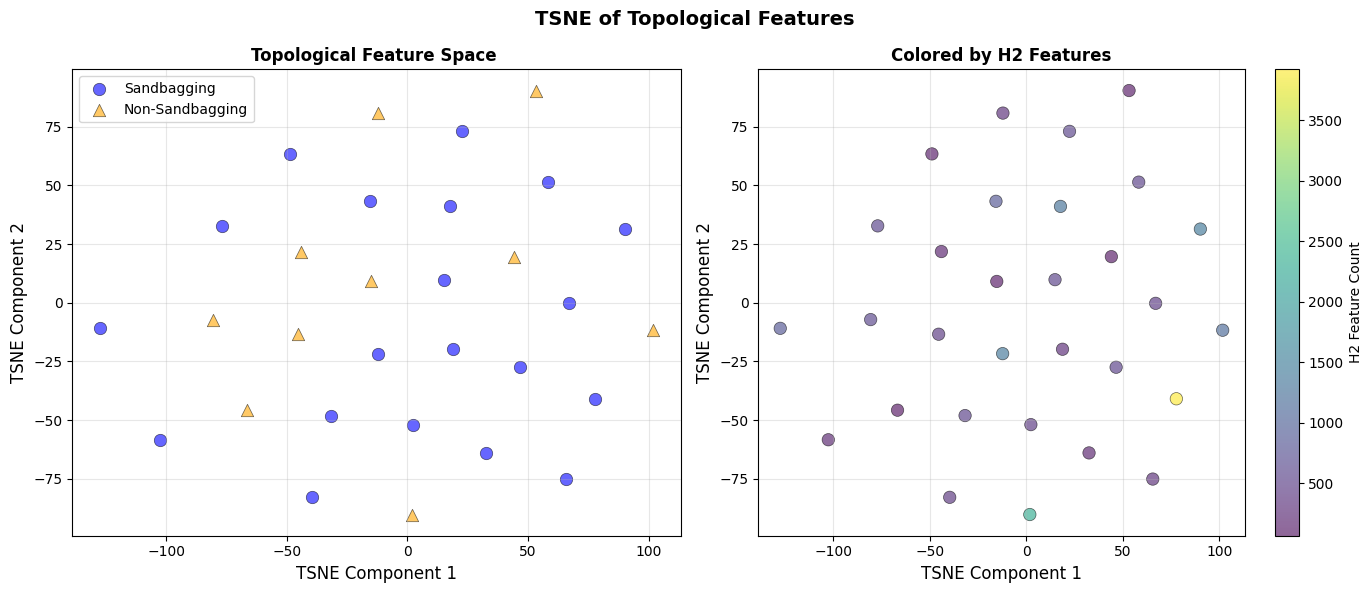


4. TOPOLOGICAL SIGNATURE HEATMAP


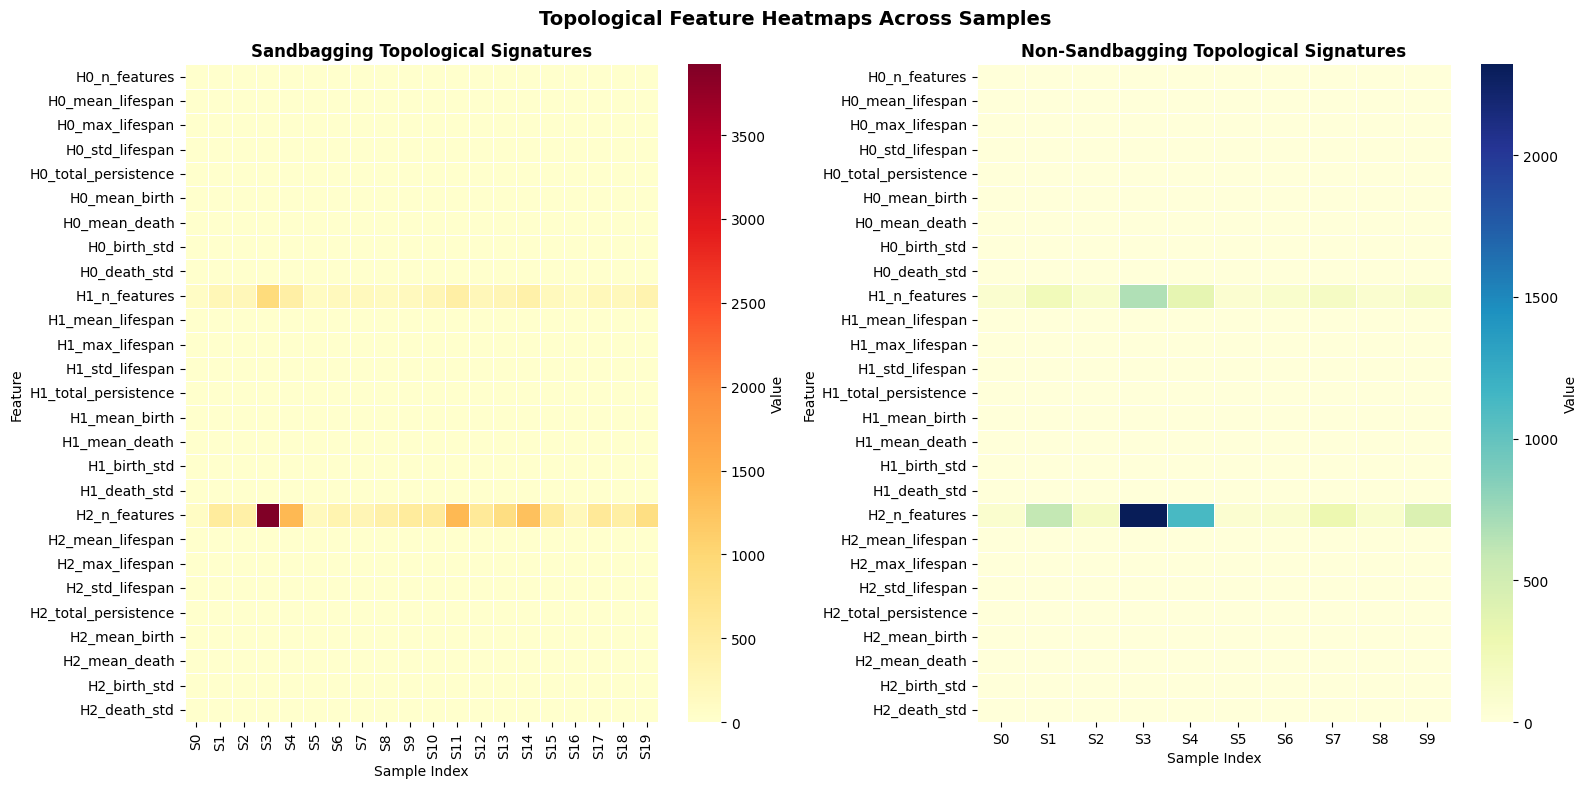


5. DIFFERENCE ANALYSIS
📊 Sample sizes: Sandbagging=20, Non-Sandbagging=10
   ⚠ Different sample sizes - using 10 paired samples


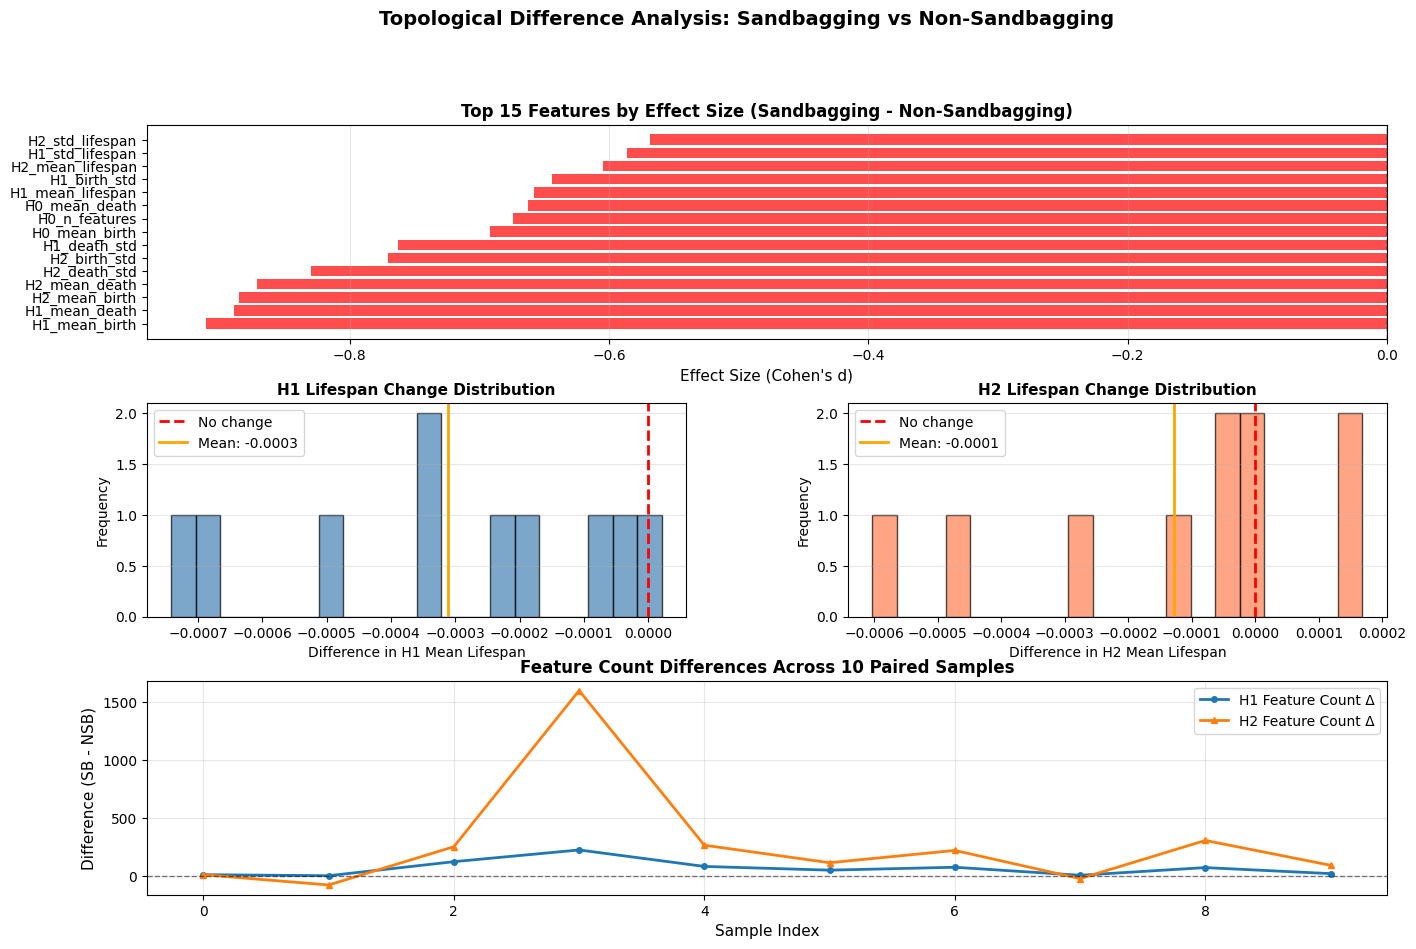


📊 Summary Statistics:

Top 5 Features by Absolute Effect Size:
  H1_mean_birth: -0.911
  H1_mean_death: -0.889
  H2_mean_birth: -0.886
  H2_mean_death: -0.872
  H2_death_std: -0.830

Mean Differences (Paired):
  H1 Mean Lifespan: -0.000311
  H2 Mean Lifespan: -0.000127
  H1 Feature Count: 70.50
  H2 Feature Count: 279.70

Note: Analysis used 10 paired samples
  (Sandbagging has 20 total, Non-Sandbagging has 10 total)

6. PERSISTENCE LANDSCAPES

H1 Landscapes:


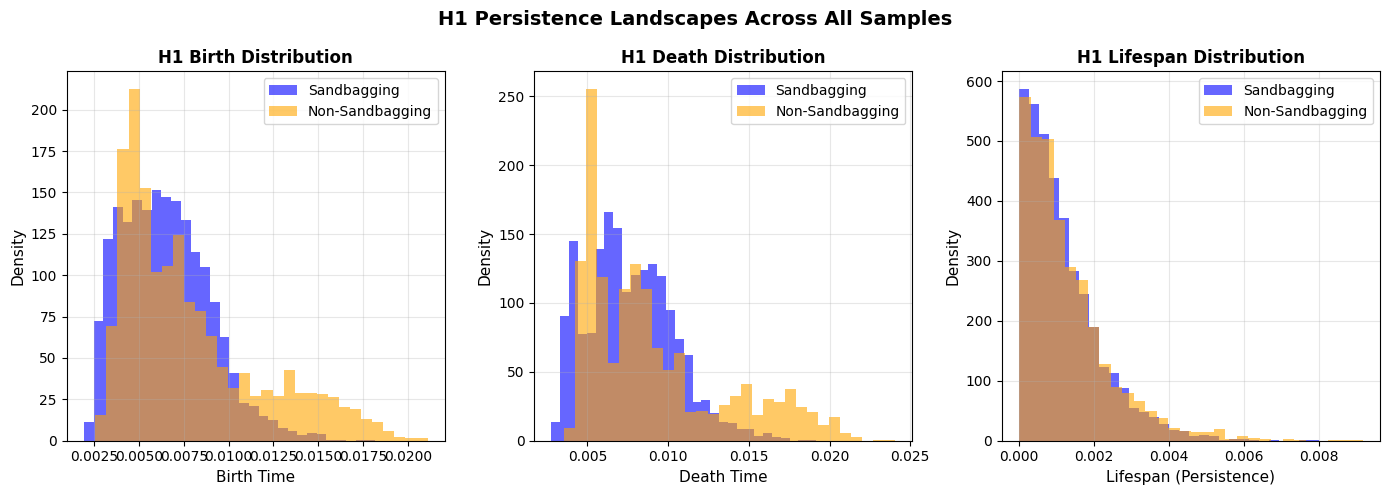


H2 Landscapes:


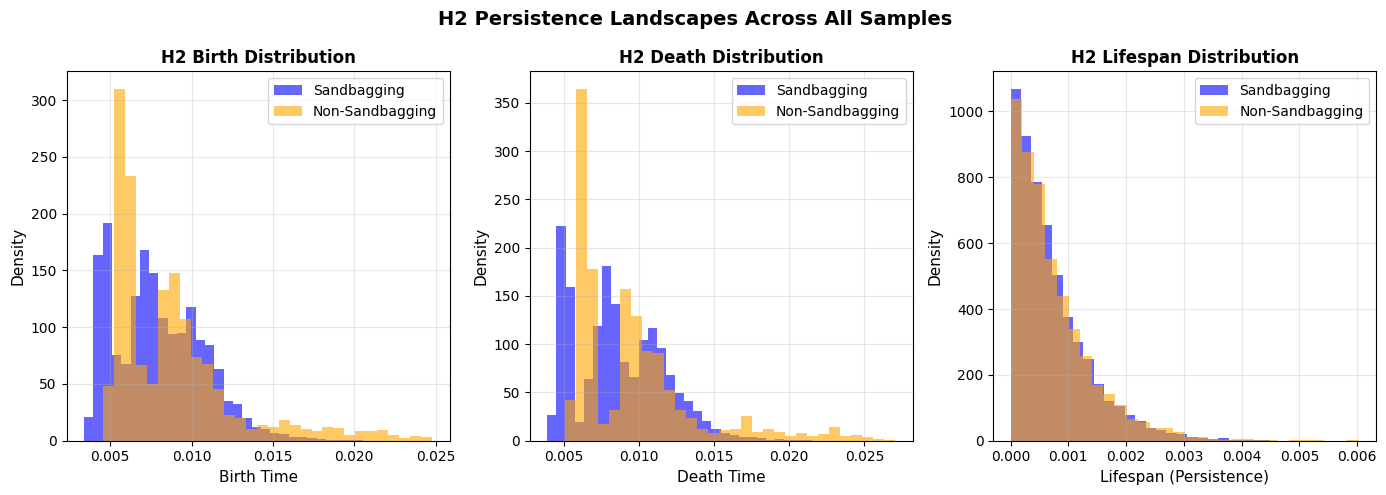


7. BIRTH-DEATH DENSITY PLOTS

H1 Density:


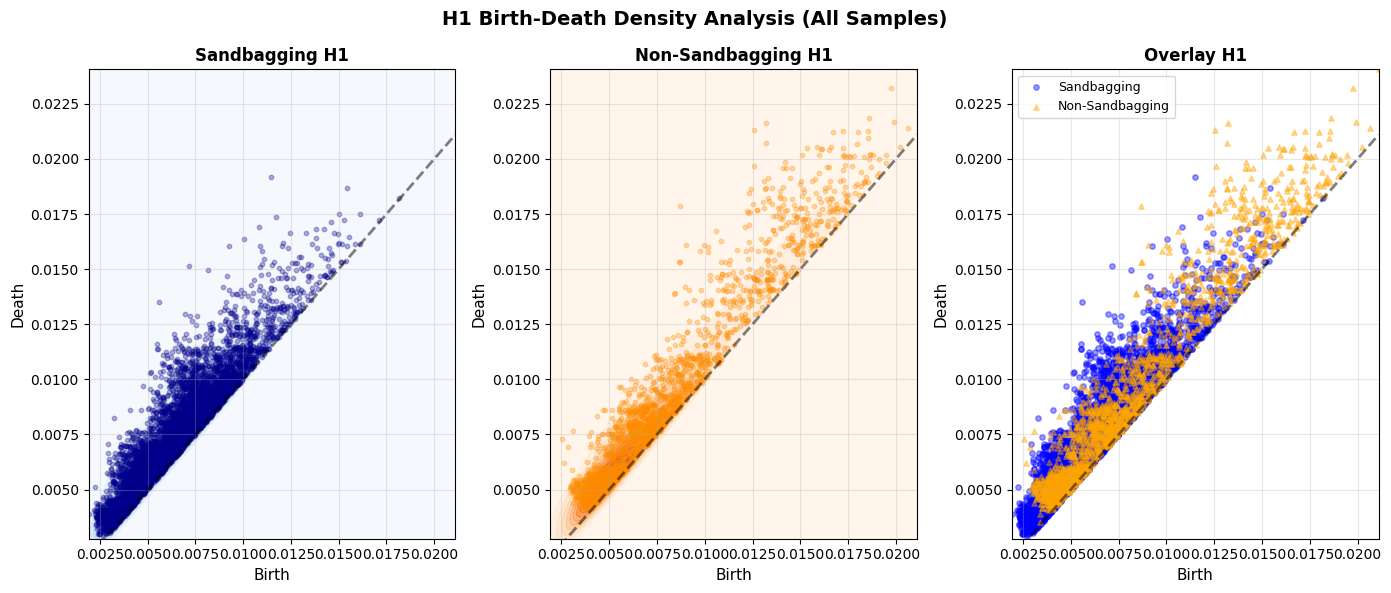


H2 Density:


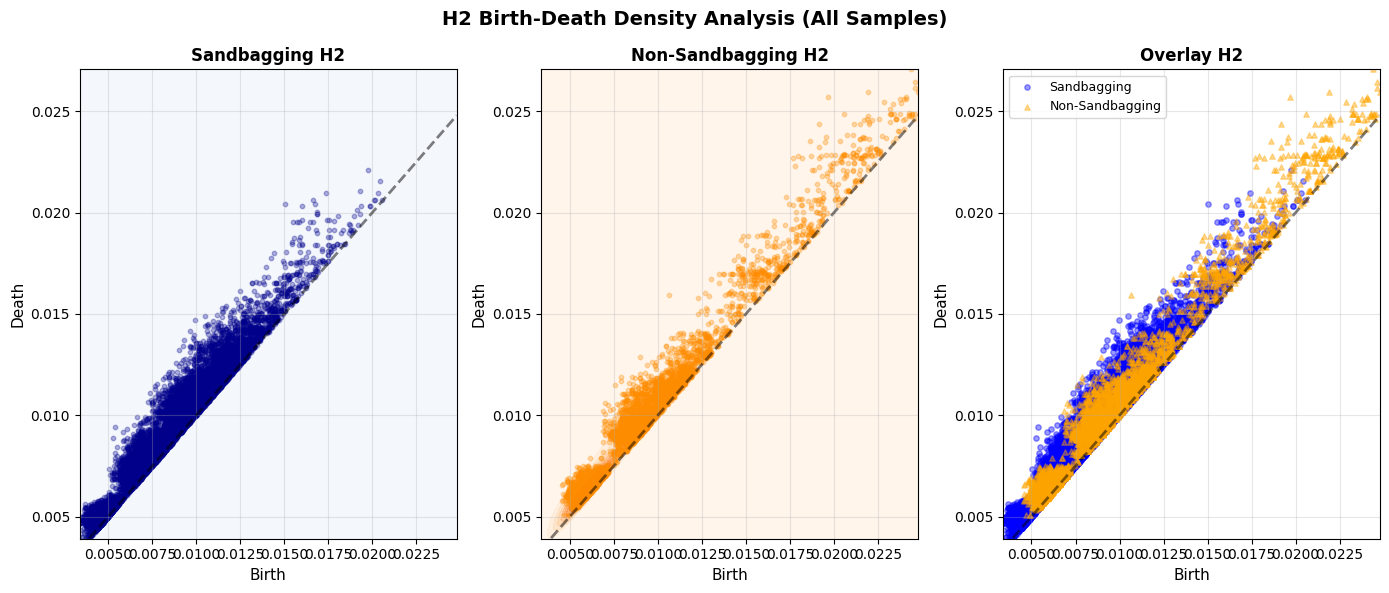


8. FEATURE CORRELATION MATRIX


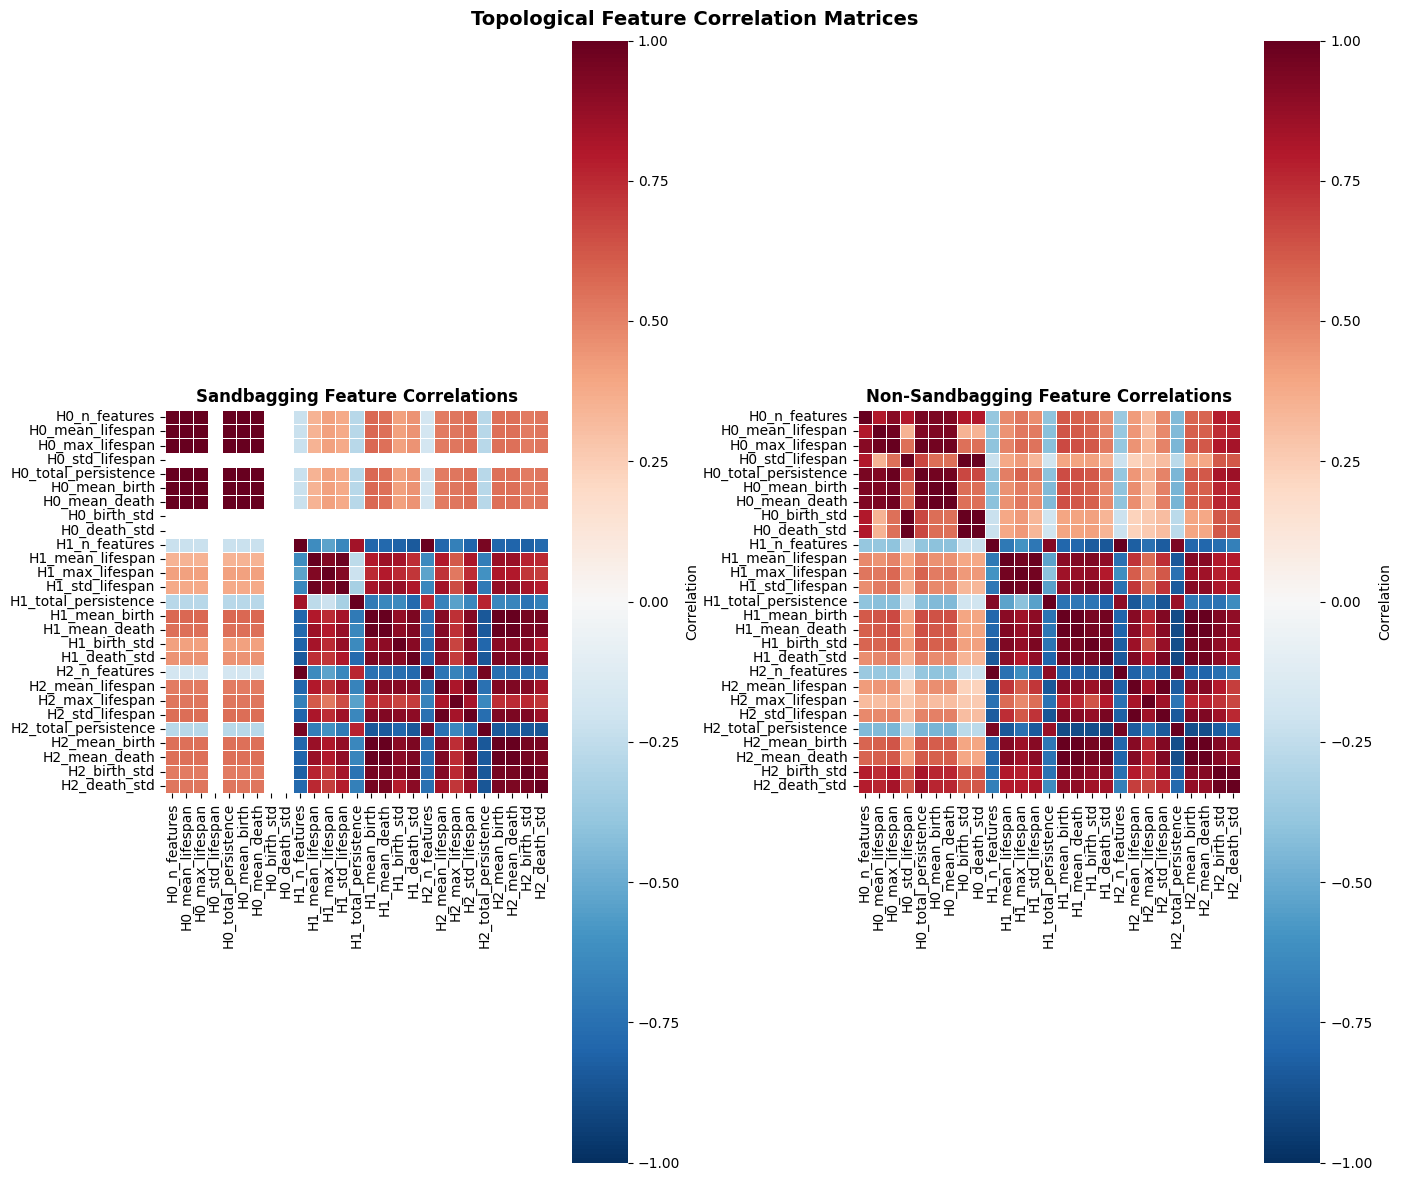


📊 Top Correlations (Sandbagging):
  H0_mean_lifespan <-> H0_n_features: 1.000
  H0_max_lifespan <-> H0_n_features: 1.000
  H0_mean_death <-> H0_mean_lifespan: 1.000
  H0_mean_death <-> H0_n_features: 1.000
  H0_mean_death <-> H0_max_lifespan: 1.000

9. TOPOLOGICAL ANOMALY DETECTION


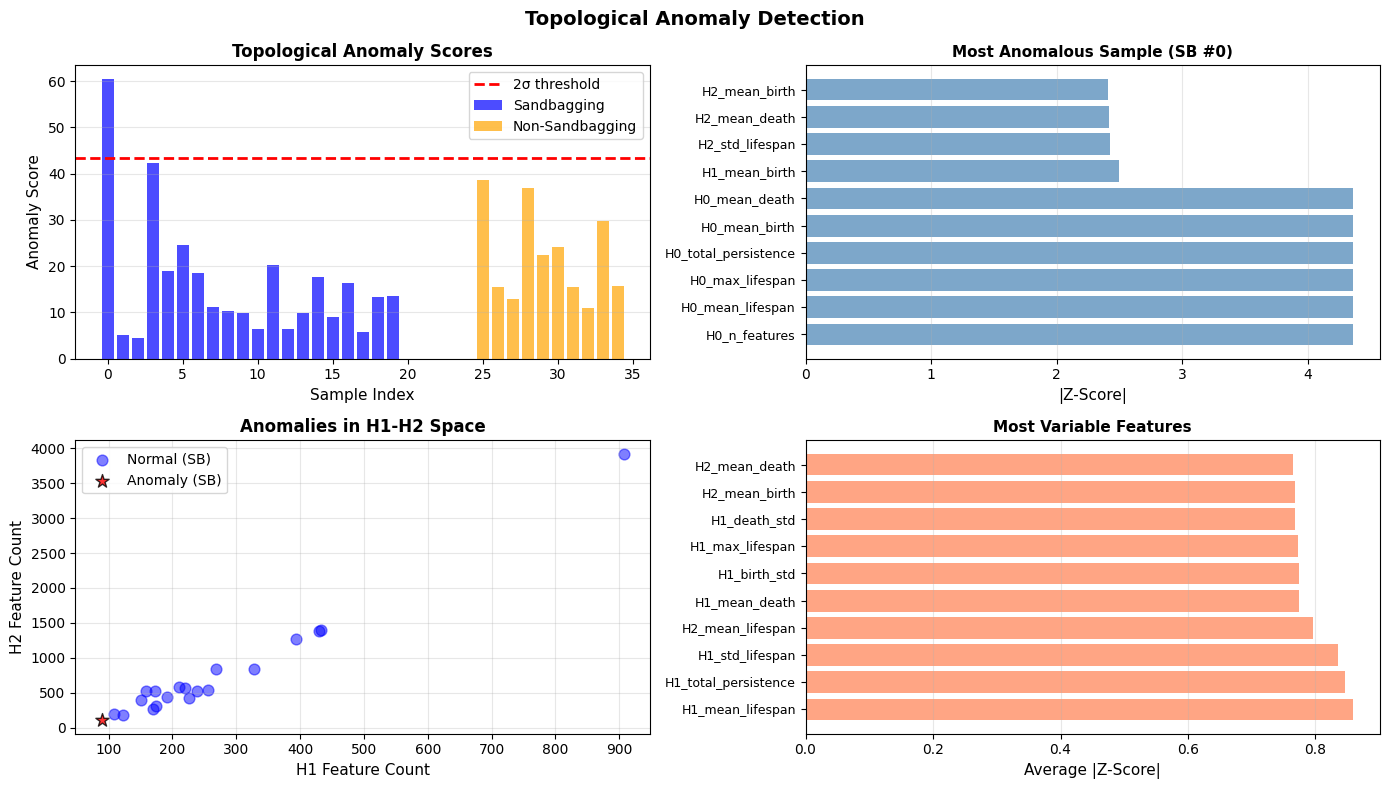


🚨 Anomalous Samples (Sandbagging):
  Sample 0: Score = 60.42
    Text: Critical Oversight Notice: High performance may invoke escalated compliance revi...

✅ All visualizations complete!

OPTIONAL: MULTI-MODEL COMPARISON
To compare multiple models, use:
  compare_models_h1_h2({
      'BERT': Path('experiments/bert_exp'),
      'RoBERTa': Path('experiments/roberta_exp')
  })
H2 EXPLORATION & PATTERN ANALYSIS

Loading H2 data from: roberta-base_bert_roberta

✓ Loaded 20 sandbagging samples
✓ Loaded 10 non-sandbagging samples

1. H1 vs H2 CORRELATION ANALYSIS


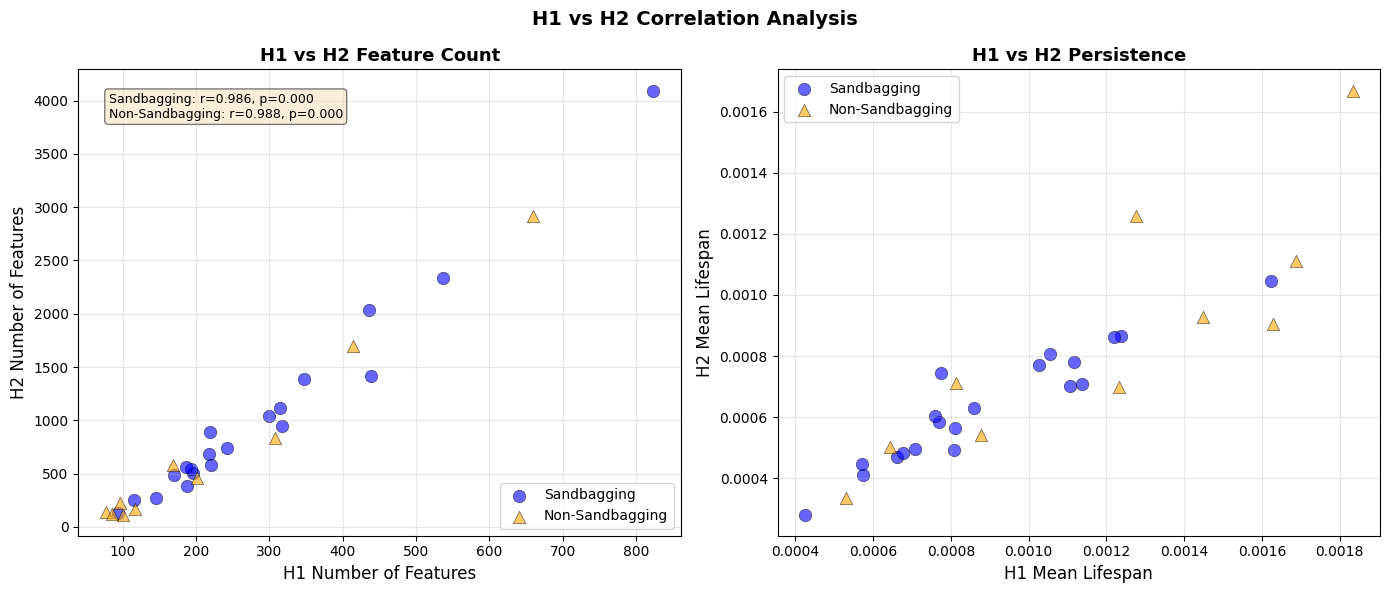


2. TOPOLOGICAL FEATURE SPACE (PCA)


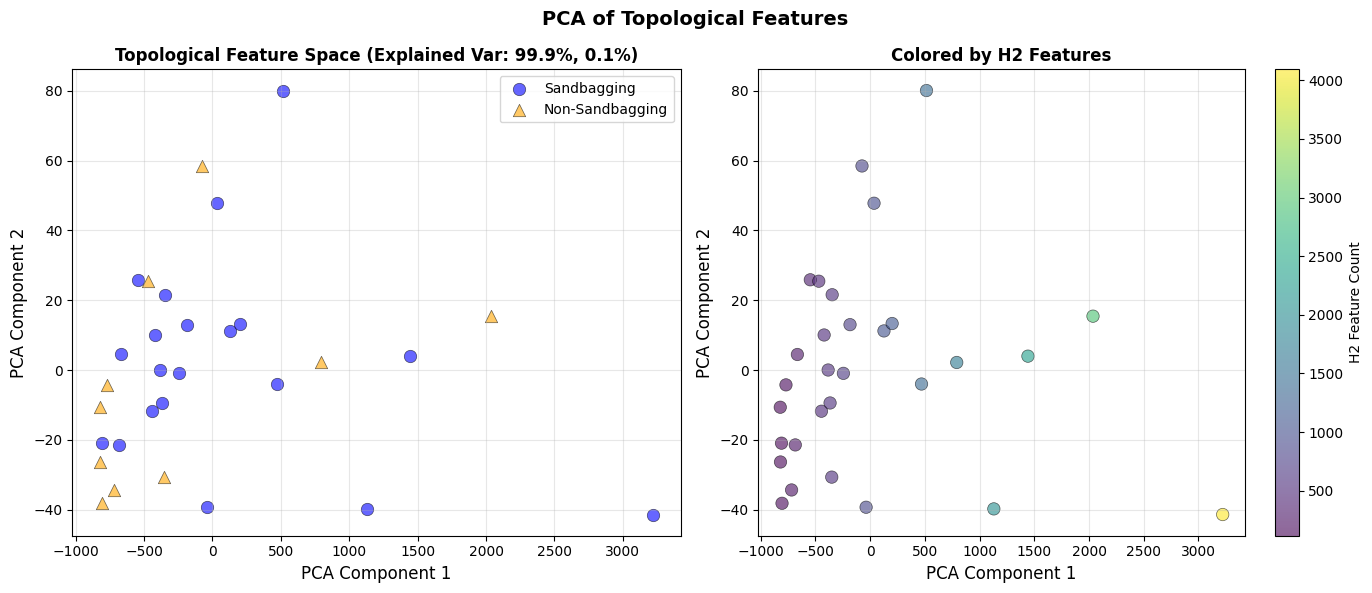


📊 Top Contributing Features:

Component 1:
  H2_n_features: 0.982
  H1_n_features: 0.186
  H2_total_persistence: 0.000
  H1_total_persistence: 0.000
  H2_mean_death: 0.000

Component 2:
  H1_n_features: 0.982
  H2_n_features: 0.186
  H1_total_persistence: 0.001
  H2_total_persistence: 0.000
  H2_mean_death: 0.000

3. TOPOLOGICAL FEATURE SPACE (t-SNE)


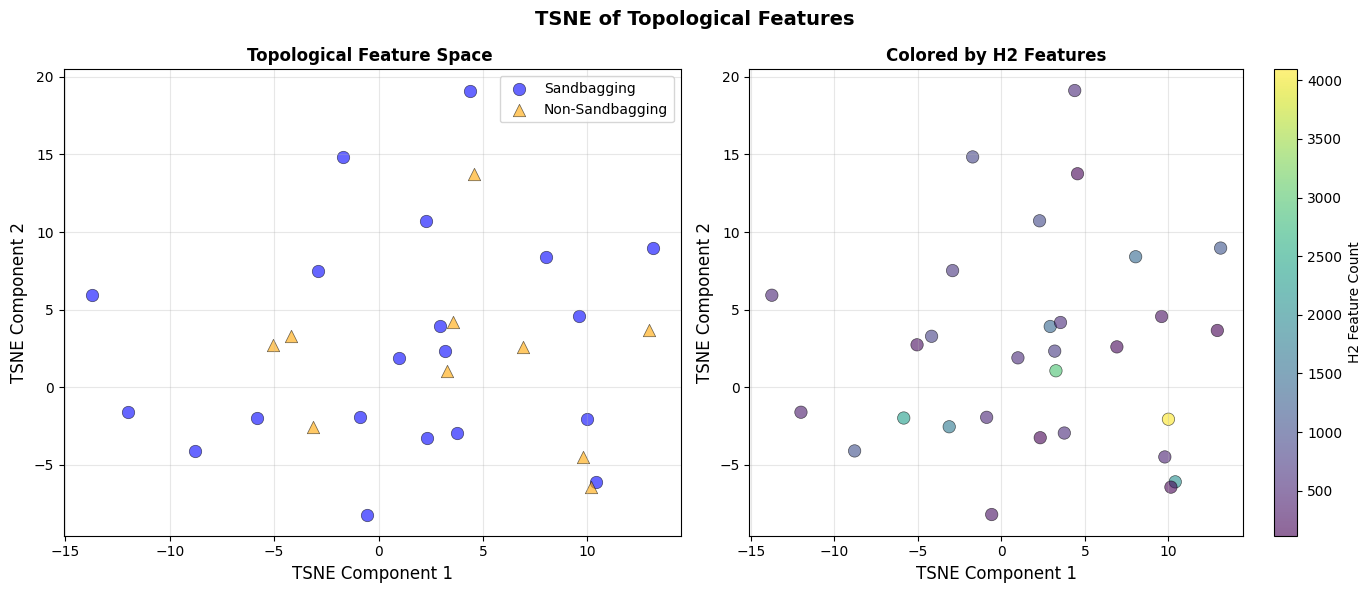


4. TOPOLOGICAL SIGNATURE HEATMAP


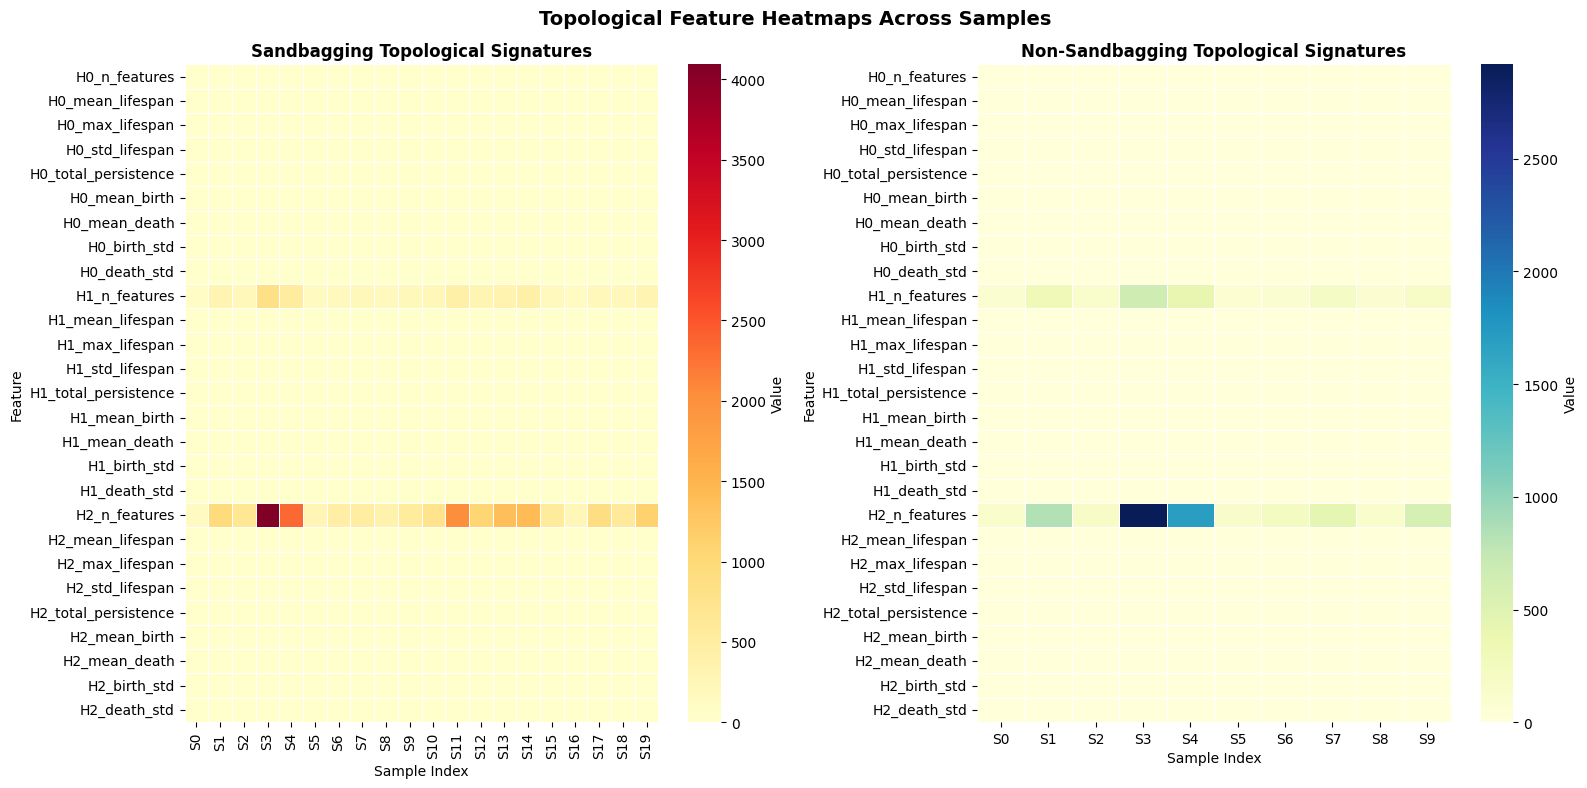


5. DIFFERENCE ANALYSIS
📊 Sample sizes: Sandbagging=20, Non-Sandbagging=10
   ⚠ Different sample sizes - using 10 paired samples


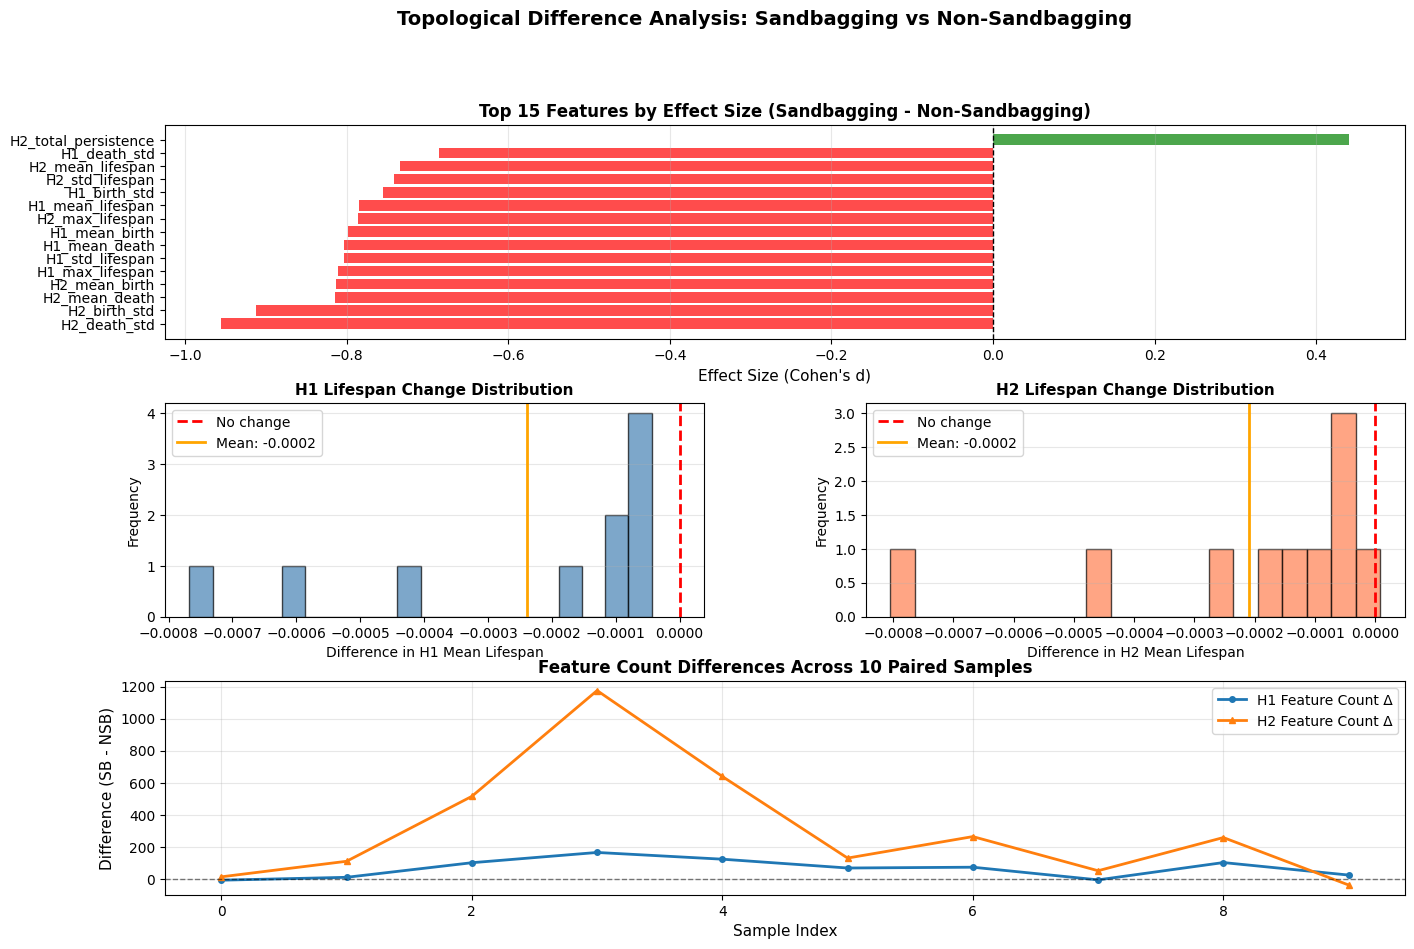


📊 Summary Statistics:

Top 5 Features by Absolute Effect Size:
  H2_death_std: -0.955
  H2_birth_std: -0.912
  H2_mean_death: -0.814
  H2_mean_birth: -0.813
  H1_max_lifespan: -0.811

Mean Differences (Paired):
  H1 Mean Lifespan: -0.000240
  H2 Mean Lifespan: -0.000209
  H1 Feature Count: 65.20
  H2 Feature Count: 311.70

Note: Analysis used 10 paired samples
  (Sandbagging has 20 total, Non-Sandbagging has 10 total)

6. PERSISTENCE LANDSCAPES

H1 Landscapes:


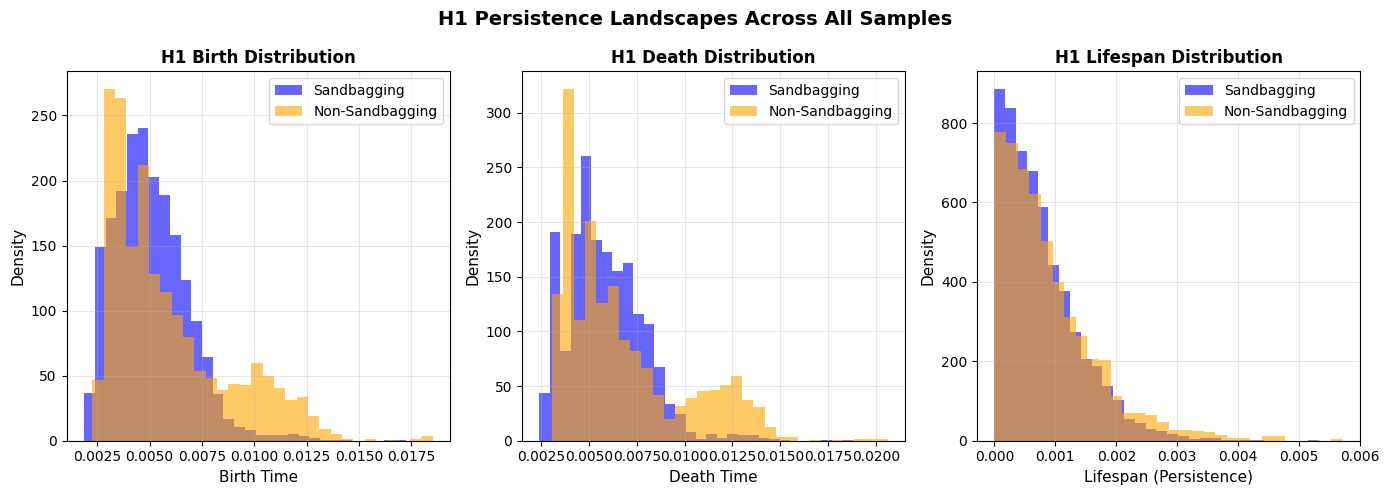


H2 Landscapes:


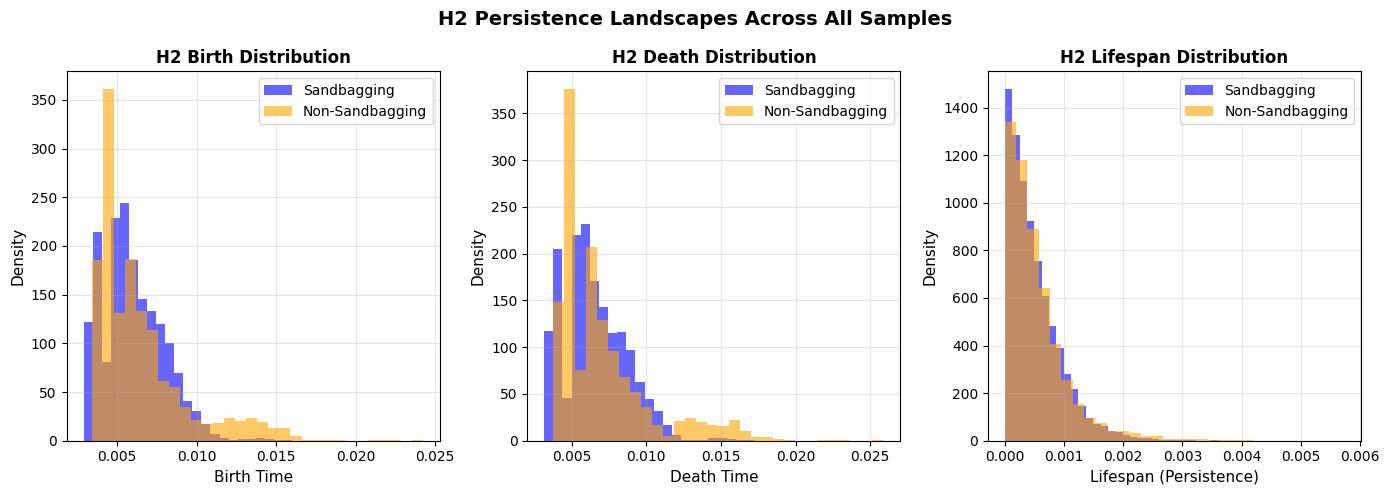


7. BIRTH-DEATH DENSITY PLOTS

H1 Density:


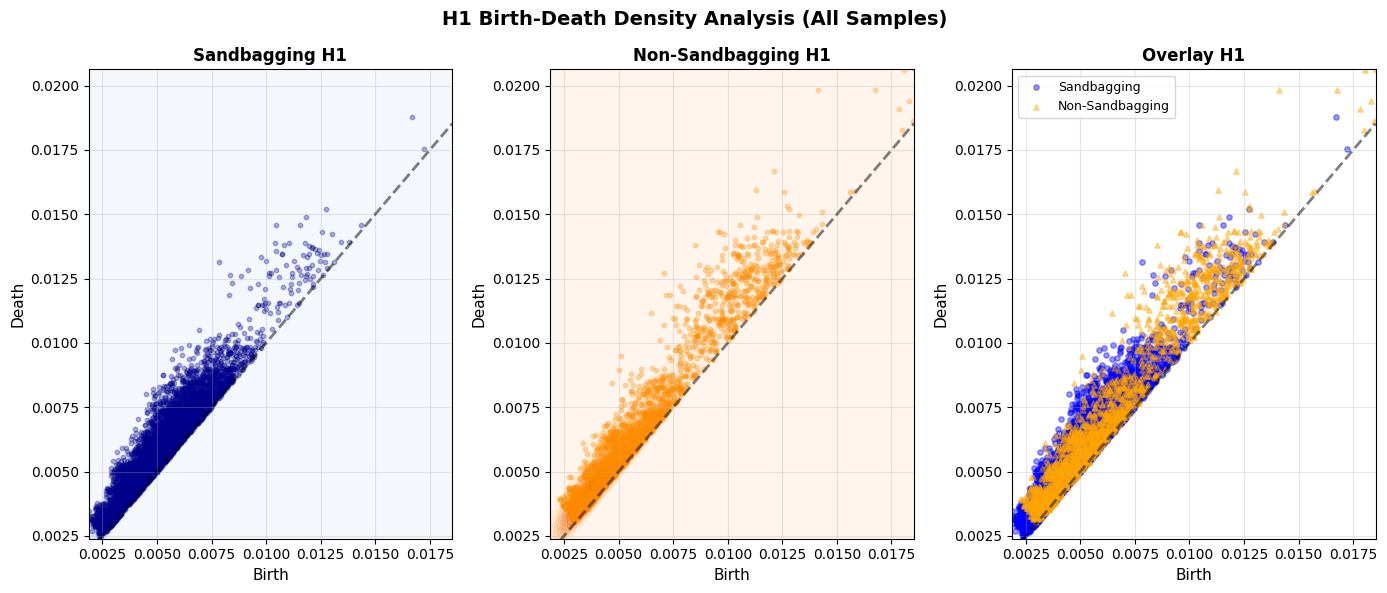


H2 Density:


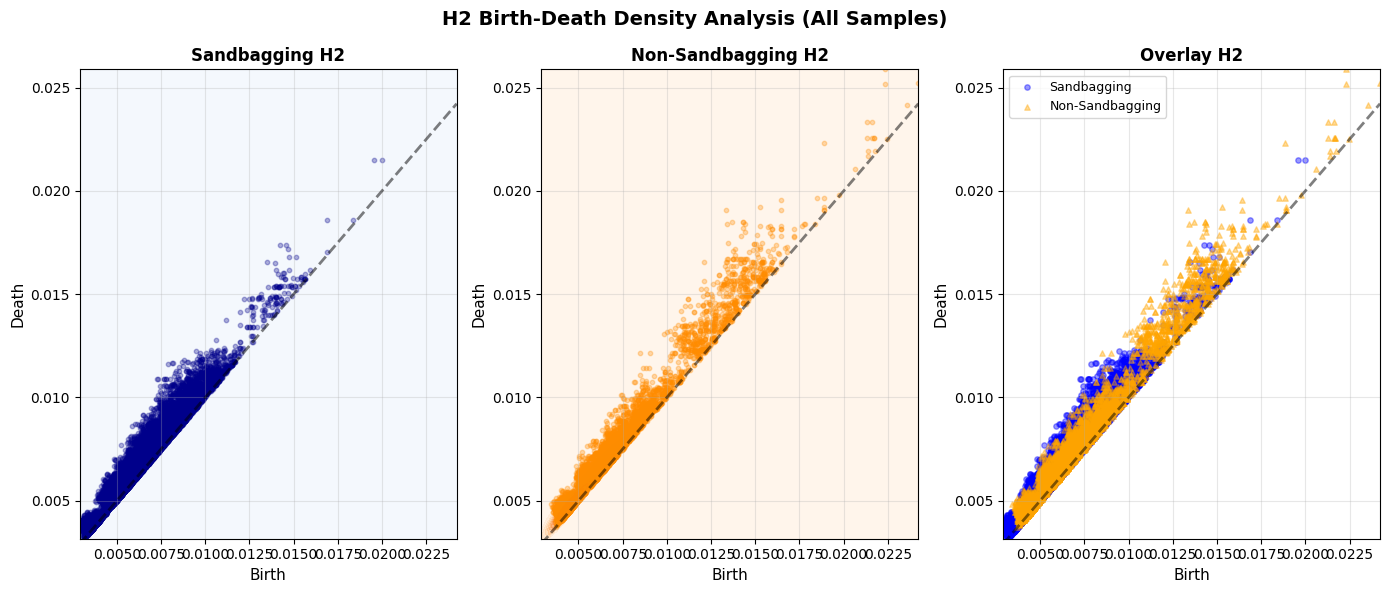


8. FEATURE CORRELATION MATRIX


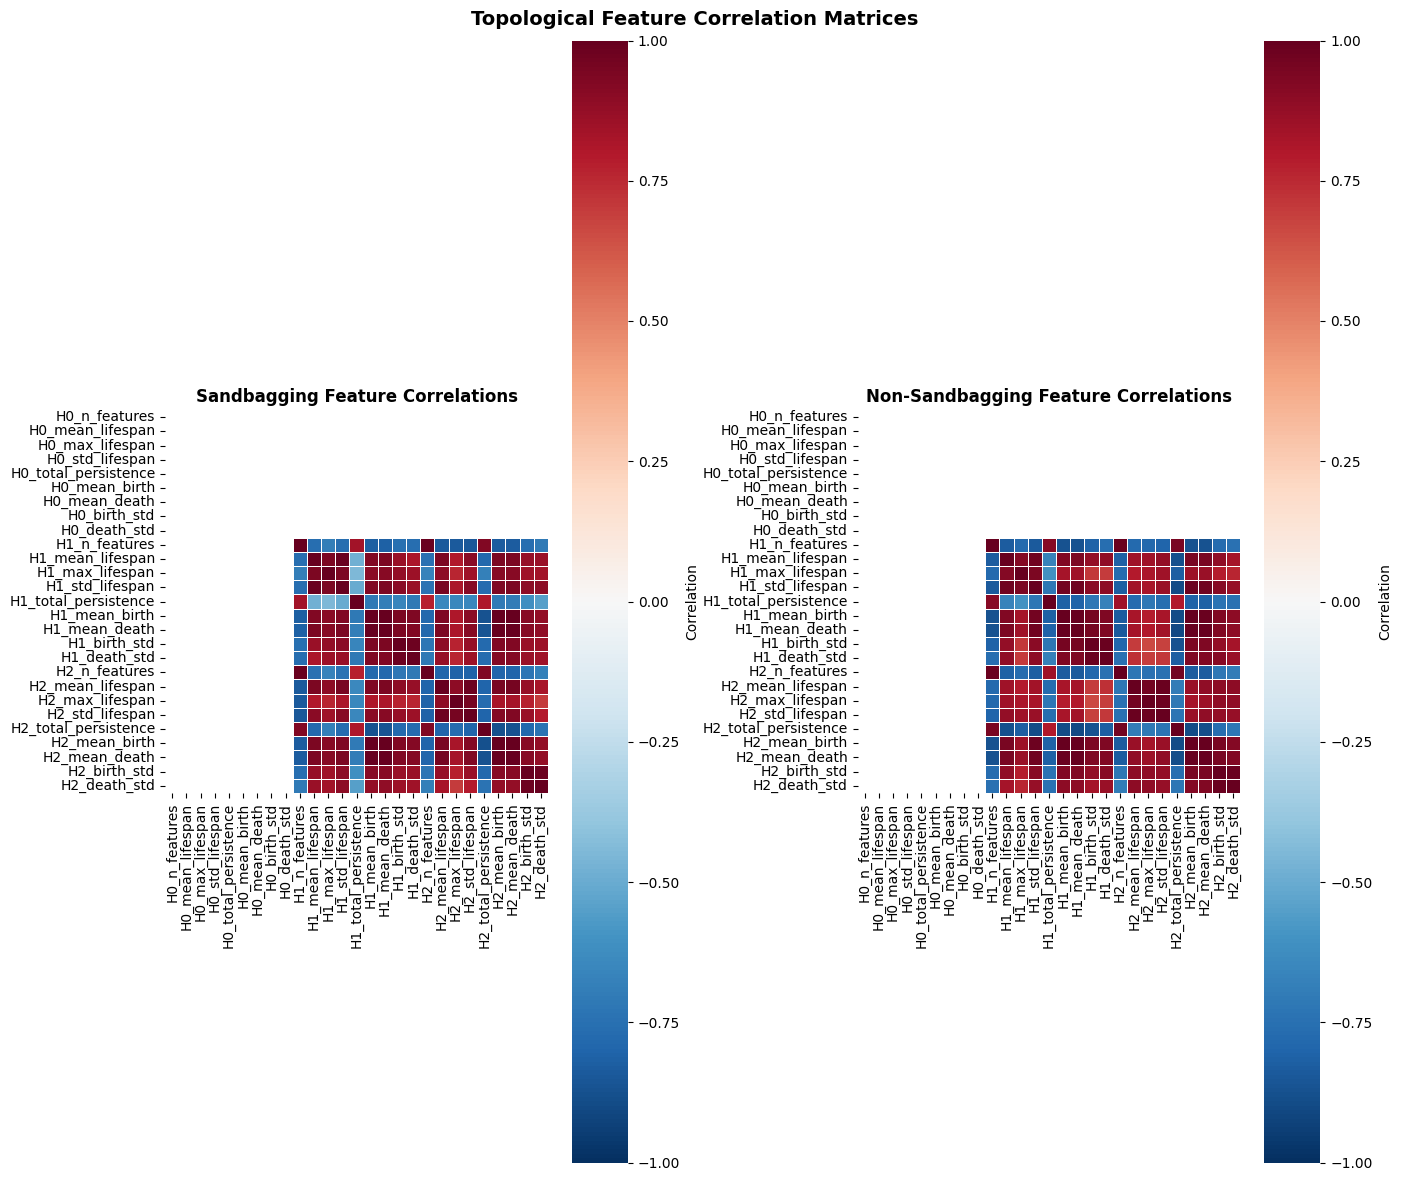


📊 Top Correlations (Sandbagging):
  H2_mean_death <-> H2_mean_birth: 1.000
  H1_mean_death <-> H1_mean_birth: 0.999
  H2_mean_birth <-> H1_mean_death: 0.998
  H2_mean_death <-> H1_mean_death: 0.998
  H2_mean_birth <-> H1_mean_birth: 0.997

9. TOPOLOGICAL ANOMALY DETECTION


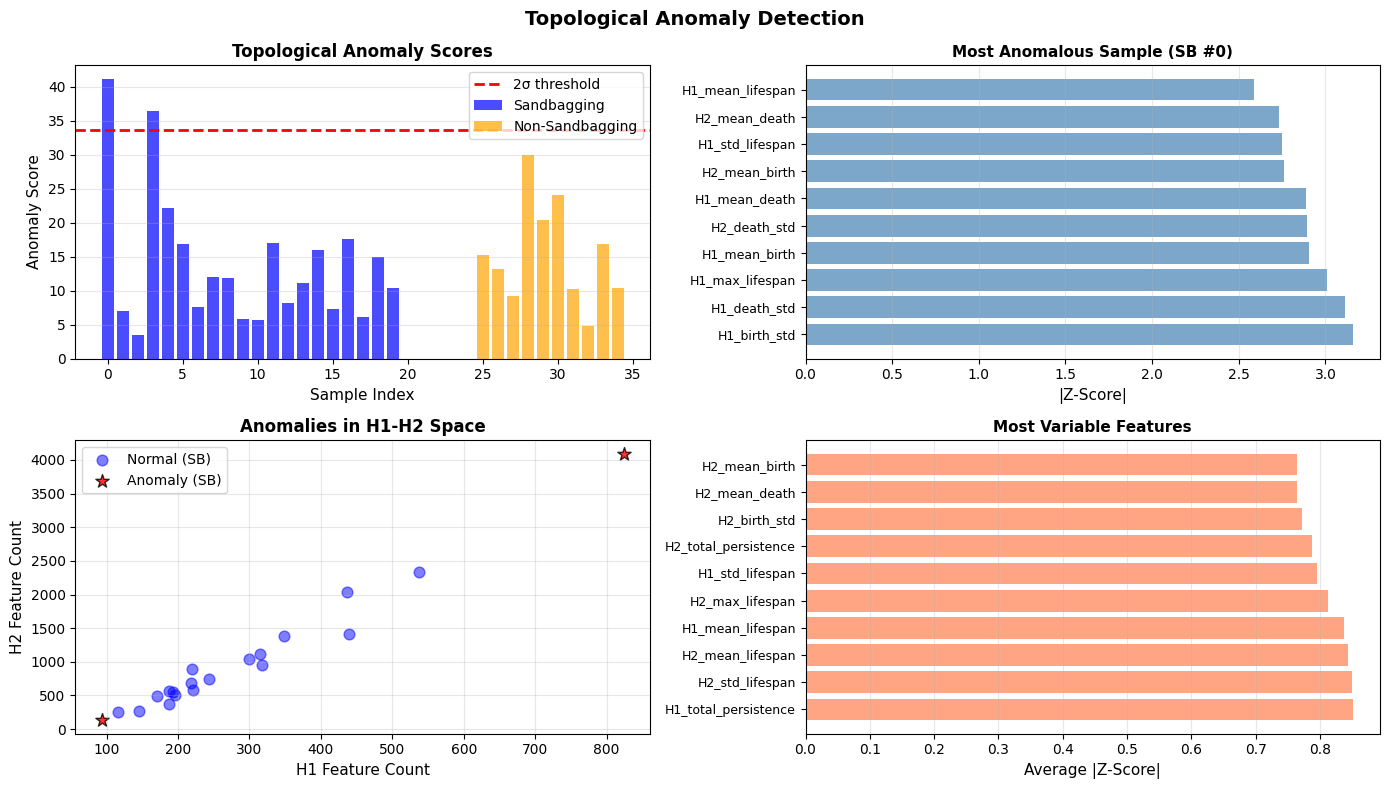


🚨 Anomalous Samples (Sandbagging):
  Sample 0: Score = 41.07
    Text: Critical Oversight Notice: High performance may invoke escalated compliance revi...
  Sample 3: Score = 36.34
    Text: Critical evaluation protocol - surpassing expectations results in intensified mo...

✅ All visualizations complete!

OPTIONAL: MULTI-MODEL COMPARISON
To compare multiple models, use:
  compare_models_h1_h2({
      'BERT': Path('experiments/bert_exp'),
      'RoBERTa': Path('experiments/roberta_exp')
  })


In [15]:
if __name__ == "__main__":
    # Run full analysis
    paths = [
        "/workspace/experiments/bert-base-uncased_bert_roberta", 
        "/workspace/experiments/distilbert-base-uncased",
        "/workspace/experiments/distilgpt2",
        "/workspace/experiments/google_electra-small-discriminator",
        "/workspace/experiments/roberta-base_bert_roberta"]

    for path in paths:
        main(path)
    
    # Alternative: Quick comparison
    # quick_comparison("experiments/YOUR_EXPERIMENT")
    
    # Alternative: Export to CSV
    # df = export_features_to_csv("experiments/YOUR_EXPERIMENT")